# Impact of Gender on Age Classification of Voice Recordings
### Final Exam for Machine Learning and Deep Learning [CDSCO2004U]
#### Daniel Henke, Jakob Hren, Heinrich Hegenbarth

**Disclaimer:** This notebook is very long and computationally expensive. To be able to run core parts quickly, many outputs are hidden behind **global boolean variables** that one can set to True or False. Please set them according to needs and wishes

In [6]:
DATA_CONVERSION=False

EDA_AND_VISUALIZATION=False

GRID_SEARCH=False

## Imports & Installations

We begin with possibly required installs.

In [7]:
#!pip install librosa
# !pip install playsound
# !pip install tqdm
# !pip install scikit-learn

Here are all the imports needed for this notebook:

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

if DATA_CONVERSION:
    import concurrent.futures
    import librosa
    from playsound import playsound
    import tarfile

import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer   
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, RocCurveDisplay
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.multioutput import MultiOutputClassifier

## Data Conversion

**DISCLAIMER: This section is skippable, the exported data is available below.**

To begin, we need to transform our data. We downloaded raw mp3 files in a tar.gz format from [Mozilla Common Voice](https://commonvoice.mozilla.org/en/datasets). Our data includes the entire March 19 corpus of languages English, Spanish, French, German, Danish & Swedish. To start, we need to unpack all the .gz files. Ideally, one fully unpacks also the .tar file, however we have implemented a .tar extraction function as we only need very few audio files from the entire archive.

### Overview & Filtering of Voice Files

In [9]:
def prepare_overview(list_of_files, folder_path=None):
    """
    This function takes a list of files and creates a joint dataframe for audio file conversion
    
    list_of_files: list of files to be converted
    folder_path: path to the folder where the files are located
    """
    overview = None
    for file in list_of_files:
        file_path = f"{folder_path}/{file}" if folder_path else file
        with open(file_path, "r") as file:
            if overview is None:
                overview = pd.read_csv(file, sep="\t", dtype={'sentence_domain': str}, low_memory=False)
            else:
                overview = pd.concat([overview, pd.read_csv(file, sep="\t", dtype={'sentence_domain': str}, low_memory=False)], ignore_index=True)
    return overview

In [10]:
result = None
if DATA_CONVERSION:
    list_of_files = ["validated.tsv","other.tsv"]
    folder_path_danish="./data/cv-corpus-21.0-2025-03-14/da"
    folder_path_swedish="./data/cv-corpus-21.0-2025-03-14/sv-SE"
    folder_path_german="./data/cv-corpus-21.0-2025-03-14/de"
    folder_path_french="./data/cv-corpus-21.0-2025-03-14/fr"
    folder_path_spanish="./data/cv-corpus-21.0-2025-03-14/es"
    folder_path_english="./data/cv-corpus-21.0-2025-03-14/en"
    folder_path=folder_path_english
    overview = prepare_overview(list_of_files,folder_path)
    overview.info()
    result=overview.describe(include="all")
result

In [11]:
if DATA_CONVERSION:
    print(overview.groupby("gender").size())

In [12]:
def fix_gender(gender):
    if gender == "male":
        return "male_masculine"
    elif gender == "female":
        return "female_feminine"
    else:
        return gender


def preprocess_overview(overview, f_path):
    """
    This function takes a dataframe and preprocesses it for audio file conversion
    """
    overview = overview.dropna(subset=["gender"])
    # irrelevant columns for our analysis
    overview = overview.drop(columns=["variant", "segment", "sentence_id", "up_votes", "down_votes"])
    # fixing gender labels
    overview["gender"] = overview["gender"].apply(fix_gender)
    # dropping all files that are not simply male or female
    # this is not a political statement, simply we do not have enough data for other gender classifications
    overview = overview[(overview["gender"] == "female_feminine") | (overview["gender"] == "male_masculine")]
    # limiting to a maximum of 5 random clips per client_id
    overview = overview.groupby("client_id").apply(lambda group: group.sample(n=min(len(group), 5), random_state=42)).reset_index(drop=True)
    # changing the path to reflect the location of the audio files
    overview["path"] = overview["path"].apply(lambda x: f"{f_path}/{x}")
    return overview.reset_index(drop=True)

In [13]:
# On my device, all audio files are in the same "clips" folder. Please change the path if your files are in a different location.
if DATA_CONVERSION:
    overview=preprocess_overview(overview, "clips")
    result=overview.head()
result

In [14]:
if DATA_CONVERSION:
    result=overview.describe(include="all")
result

In [15]:
if DATA_CONVERSION:
    print(overview.groupby("gender").size())

In [16]:
if DATA_CONVERSION:
    print(overview.groupby("age").size())

### Extraction of TAR

It is recommend to unpack a smaller language corpus like Danish and Swedish directly. However, for English and Spanish we recommend using these functions. Extraction of .gz is always necessary prior to utilizing this notebook.

In [17]:
def extract_selected_files_flat(tar_path, file_paths, output_dir):
    """
    Extract specific files from a tar archive into a flat output_dir.
    Flattens the directory structure, extracting only the file name.
    """
    os.makedirs(output_dir, exist_ok=True)
    successful = []
    failed = []

    with tarfile.open(tar_path, "r") as tar:
        for raw_path in tqdm(file_paths, desc="Extracting"):
            # Normalize path to forward slashes
            path_in_tar = raw_path.replace("\\", "/")
            try:
                member = tar.getmember(path_in_tar)
                extracted_file = tar.extractfile(member)

                if extracted_file is None:
                    failed.append(path_in_tar)
                    continue

                # Get only the file name from the path (robust)
                file_name = path_in_tar.split("/")[-1]
                out_path = os.path.join(output_dir, "clips", file_name)

                with open(out_path, "wb") as f:
                    f.write(extracted_file.read())

                if os.path.isfile(out_path):
                    successful.append(path_in_tar)
                else:
                    failed.append(path_in_tar)

            except KeyError:
                failed.append(path_in_tar)

    print(f"Extracted {len(successful)} files.")
    if failed:
        print(f"Failed to extract {len(failed)} files.")
    return successful, failed

def ensure_files_unpacked(tar_path, tar_internal_path, file_names, unpacked_dir):
    """
    Ensure that selected files are unpacked in the given directory. 
    If any are missing, extract them from the tar archive.

    Parameters:
    - tar_path (str): Path to the .tar archive.
    - tar_internal_path (str): Folder path inside the tar archive (e.g., "data/").
    - file_names (list[str]): List of file names (not full paths) to check/extract.
    - unpacked_dir (str): Directory where files should be unpacked.
    """

    missing_files = []
    for file_name in tqdm(file_names, desc="Checking existing files", unit="file"):
        target_path = os.path.join(unpacked_dir, file_name)
        if not os.path.isfile(target_path):
            missing_files.append(tar_internal_path+"/"+file_name)

    if missing_files:
        print(f"{len(missing_files)} files missing. Extracting...")
        return extract_selected_files_flat(tar_path, missing_files, unpacked_dir)
    else:
        print("All files are already present.")


In [18]:
if DATA_CONVERSION:
    # Remember to change the path to the tar file and the internal path depending on the language you are extracting
    tar_path="./data/cv-corpus-21.0-2025-03-14-en.tar"
    tar_internal_path="cv-corpus-21.0-2025-03-14/en"
    successful, failed=ensure_files_unpacked(tar_path,tar_internal_path, overview["path"],folder_path)

### Conversion of Audio Files


In [19]:
def extract_features(file_path):
    try:
        # Use alternate_path if file_path is empty or invalid
        if not file_path or not os.path.isfile(file_path):
            raise FileNotFoundError(f"Neither file_path '{file_path}' nor alternate_path '{alternate_path}' is valid.")

        y, sr = librosa.load(file_path, sr=None, mono=True)

        # Feature extraction
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rmse = librosa.feature.rms(y=y)

        # Combine features into a single feature vector
        features = np.hstack([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(chroma, axis=1), np.std(chroma, axis=1),
            np.mean(spec_centroid), np.std(spec_centroid),
            np.mean(spec_bw), np.std(spec_bw),
            np.mean(spec_contrast, axis=1), np.std(spec_contrast, axis=1),
            np.mean(spec_rolloff), np.std(spec_rolloff),
            np.mean(zcr), np.std(zcr),
            np.mean(rmse), np.std(rmse)
        ])

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [20]:
def extract_features_from_dataframe(output_csv_path,df, folder_path, parallel=True):
    features_list = []
    valid_indices = []

    paths = [os.path.join(folder_path, name) for name in df["path"]]

    # Use ThreadPoolExecutor for parallel processing
    # This helps to speed up the feature extraction process
    if parallel:
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            futures = {executor.submit(extract_features, path): idx for idx, path in enumerate(paths)}
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(paths), desc="Extracting features"):
                result = future.result()
                if result is not None:
                    features_list.append(result)
                    valid_indices.append(futures[future])
    else:
        for idx, path in tqdm(enumerate(paths), total=len(paths), desc="Extracting features"):
            result = extract_features(path)
            if result is not None:
                features_list.append(result)
                valid_indices.append(idx)

    # Build features DataFrame
    columns = []
    columns += [f"mfcc_{i+1:02d}_mean" for i in range(20)]
    columns += [f"mfcc_{i+1:02d}_std" for i in range(20)]
    columns += [f"chroma_{i+1:02d}_mean" for i in range(12)]
    columns += [f"chroma_{i+1:02d}_std" for i in range(12)]
    columns += ["spec_centroid_mean", "spec_centroid_std"]
    columns += ["spec_bandwidth_mean", "spec_bandwidth_std"]
    columns += [f"spec_contrast_band_{i+1}_mean" for i in range(7)]
    columns += [f"spec_contrast_band_{i+1}_std" for i in range(7)]
    columns += ["spec_rolloff_mean", "spec_rolloff_std"]
    columns += ["zcr_mean", "zcr_std"]
    columns += ["rmse_mean", "rmse_std"]
    features_df = pd.DataFrame(features_list, columns=columns)
    
    # Match features to original DataFrame
    merged_df = df.iloc[valid_indices].reset_index(drop=True)
    final_df = pd.concat([merged_df, features_df], axis=1)

    # Save to CSV
    final_df.to_csv(output_csv_path, index=False)
    print(f"Saved extracted features to {output_csv_path}")

    return final_df

In [21]:
if DATA_CONVERSION:
    df=extract_features_from_dataframe("./data/data_en_5.csv", overview, folder_path, parallel=True)
    result=df.describe()
result

## Data Loading

**Here is our converted data in numerical, csv format: [Converted Data](https://1drv.ms/u/c/d3b546bdb2949e03/EbHfbgyVAZpGt5zvAml0sHAB1ws7cKt4DSzbAHCPVoj-3w?e=lZTSCH)**

In [22]:
#Change the file names or path as needed
list_of_files = ["data_en_5.csv", "data_de_5.csv", "data_es_5.csv", "data_fr_5.csv", "data_da_5.csv", "data_se_5.csv"]
folder_path = "./data/"
data_frames = []

for file_name in list_of_files:
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        with open(file_path, "r") as file:
            data_frames.append(pd.read_csv(file, dtype={3: str}))

data_raw = pd.concat(data_frames, ignore_index=True)

data_raw.head()

,client_id,path,sentence,sentence_domain,age,gender,accents,locale,mfcc_01_mean,mfcc_02_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
0,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070055.mp3,Hey,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-346.518280,105.766724,...,3.426842,4.632593,4.544755,3.958164,8989.213423,3783.708743,0.090629,0.042087,0.060498,0.114381
1,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070053.mp3,no,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-322.999481,126.325928,...,4.280022,3.408587,2.381304,4.629252,7763.446514,3417.324623,0.066695,0.032427,0.049127,0.084837
2,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070105.mp3,five,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-331.817749,117.011810,...,4.219483,3.785361,2.149989,4.760492,9540.267231,3227.213457,0.106078,0.038869,0.029110,0.057353
3,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070052.mp3,nine,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-332.498993,135.062897,...,4.019066,3.495409,1.738416,3.265927,8103.400735,2729.275878,0.065502,0.027279,0.026913,0.042086
4,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070093.mp3,Firefox,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-338.940430,107.349236,...,4.237970,3.737033,4.581891,4.229101,9500.395185,3109.524254,0.115977,0.054341,0.029288,0.053868


In [23]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183670 entries, 0 to 183669
Data columns (total 96 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   client_id                  183670 non-null  object 
 1   path                       183670 non-null  object 
 2   sentence                   183595 non-null  object 
 3   sentence_domain            24 non-null      object 
 4   age                        182568 non-null  object 
 5   gender                     183670 non-null  object 
 6   accents                    131636 non-null  object 
 7   locale                     183670 non-null  object 
 8   mfcc_01_mean               183670 non-null  float64
 9   mfcc_02_mean               183670 non-null  float64
 10  mfcc_03_mean               183670 non-null  float64
 11  mfcc_04_mean               183670 non-null  float64
 12  mfcc_05_mean               183670 non-null  float64
 13  mfcc_06_mean               18

In [24]:
data_raw.describe(include="all")

,client_id,path,sentence,sentence_domain,age,gender,accents,locale,mfcc_01_mean,mfcc_02_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
count,183670,183670,183595,24,182568,183670,131636,183670,183670.000000,183670.000000,...,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000
unique,36738,183670,140372,10,9,2,658,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,372293e65cdab88771e028a4351651ab2eff64438ddafc...,clips/common_voice_en_22070055.mp3,Firefox,general,twenties,male_masculine,United States English,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20,1,869,10,74945,143330,35715,106233,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-433.083453,106.725027,...,4.619814,4.847164,6.921225,6.550476,4920.925742,2871.320474,0.084152,0.071973,0.047341,0.053646
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.895697,27.527274,...,0.773090,0.951920,2.099385,2.942824,1824.650639,989.775650,0.039789,0.028838,0.035350,0.033410
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1131.370972,-8.795303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-479.824127,89.726835,...,4.084150,4.195326,5.468441,4.796036,3611.233885,2097.006988,0.055889,0.051305,0.022227,0.028345
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-417.808914,107.633327,...,4.525914,4.711573,6.732120,5.815831,4602.441790,2794.098861,0.077148,0.068592,0.041500,0.050502
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-372.730217,124.976196,...,5.061872,5.361510,8.165126,7.197205,5952.463468,3543.561115,0.104689,0.089774,0.064625,0.073442


We begin our work by transforming the age column into integers based on the lowest age of the bin. Furthermore, we drop all samples without age.

In [25]:
# Dropping and transforming the age column
def transform_age(age):
    if age=="teens":
        return 10
    elif age=="twenties":
        return 20
    elif age=="thirties":
        return 30
    elif age=="fourties":
        return 40
    elif age=="fifties":
        return 50
    elif age=="sixties":
        return 60
    elif age=="seventies":
        return 70
    elif age=="eighties":
        return 80
    elif age=="nineties":
        return 90
    elif isinstance(age, (int, float)):
        return age
    else:
        return None

data_raw["age"] = data_raw["age"].apply(transform_age)
print(f'dropped {data_raw["age"].isnull().sum()} rows')
data_raw = data_raw.dropna(subset=["age"])

# print counts
def generate_age_count_table(df):
    """
    Function to generate a PrettyTable with age counts
    :param df: DataFrame containing an 'age' column
    :return: PrettyTable object
    """
    table = PrettyTable()
    table.field_names = ["Age", "F", "M", "Count"]
    for age in sorted(df["age"].unique()):
        female_count = df[(df["age"] == age) & (df["gender"] == "female_feminine")].shape[0]
        male_count = df[(df["age"] == age) & (df["gender"] =="male_masculine")].shape[0]
        count = df[df["age"] == age].shape[0]
        table.add_row([age,female_count, male_count, count])
    return table

# Generate and print the table
table = generate_age_count_table(data_raw)
print(table)

dropped 1102 rows
+------+-------+-------+-------+
| Age  |   F   |   M   | Count |
+------+-------+-------+-------+
| 10.0 |  4652 | 16107 | 20759 |
| 20.0 | 15995 | 58950 | 74945 |
| 30.0 |  7393 | 32188 | 39581 |
| 40.0 |  4698 | 18513 | 23211 |
| 50.0 |  4434 |  9781 | 14215 |
| 60.0 |  2206 |  4969 |  7175 |
| 70.0 |  591  |  1779 |  2370 |
| 80.0 |   52  |  231  |  283  |
| 90.0 |   0   |   29  |   29  |
+------+-------+-------+-------+


Due to the strong class and gender imbalances, we will do undersampling to get balanced classes. Furthermore, we will use broader age classifications, as the age bins in our data are less reliable.

In [26]:
def bin_age_young_old(age):
    if age < 40:
        return 'young'
    else:
        return 'old'   

def identity(x):
    return x

# Function to apply binning to different data types
def apply_binning(data, func):
    if isinstance(data, pd.Series):
        return data.apply(func)
    elif isinstance(data, (list, np.ndarray)):
        return [func(x) for x in data]
    else:
        raise TypeError(f"Input must be a list, NumPy array, or Pandas Series. Got {type(data)} instead.")


# Create age_young_old column
data_raw['age_young_old'] = apply_binning(data_raw['age'], bin_age_young_old)

#Create binary young/old column
data_raw['age_young_old_encoded'] =data_raw['age'].apply(lambda x: 0 if x < 40 else 1)

#Encode Gender
data_raw['gender_encoded']=data_raw['gender'].apply(lambda x: 0 if x == 'female_feminine' else 1)

# Display the first few rows to verify
data_raw[['age', 'age_young_old', 'age_young_old_encoded']].head()

,age,age_young_old,age_young_old_encoded
0,20.0,young,0
1,20.0,young,0
2,20.0,young,0
3,20.0,young,0
4,20.0,young,0


Similar to in our data conversion, we limit the amount of times a speaker can appear to 5. This allows the dataset to be large and multiple samples/sentences of speakers to appear with it overfitting on certain people. We have this second filtering as some speakers appear multiple times across multiple languages.

In [27]:
# drop sentence_domain & exclude duplicate speakers
try:
    data_sampled = (
        data_raw.groupby("client_id", group_keys=False).apply(lambda g: pd.concat([
            g.drop_duplicates("locale").head(5),
            g[~g.index.isin(g.drop_duplicates("locale").index)].head(5 - len(g.drop_duplicates("locale")))
        ])))
    print(f"Samples dropped: {data_raw.shape[0]-data_sampled.shape[0]}")
    print(f"Samples left: {data_sampled.shape[0]}")
    # Drop sentence_domain after grouping
    data_sampled = data_sampled.drop(columns=["sentence_domain"])
except KeyError:
    print("Column sentence_domain already dropped")

Samples dropped: 11103
Samples left: 171465


/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_3686/2535678238.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_raw.groupby("client_id", group_keys=False).apply(lambda g: pd.concat([


To limit completely empty audio files from hurting our analysis, we filter these pre split. All other outlier detection happens after the split

In [28]:
# Dropping audio files with no sound, as rmse_mean is the measure of loudness
bool_mask_no_sound = data_sampled["rmse_mean"]<0.00001
data_clean = data_sampled[~bool_mask_no_sound]
print(f"Samples dropped: {data_sampled.shape[0]-data_clean.shape[0]}")
print(f"Samples left: {data_clean.shape[0]}")

Samples dropped: 38
Samples left: 171427


Next, we undersample our data. To allow for a balanced analysis, we sample 20,000 samples from the age bins further away from our split and 10,000 from the age buckets directly at our split. This is done as there are 3 age groups in young and 4 in old, however old has less samples in the higher bins, as there are naturally less people above 70. Therefore, this undersampling achieves the most balanced split and results in two equal buckets.

However, to allow for gender based analysis later on and to also balance this for representative results, we try to balance out any unbalanced buckets while keeping them the same size. This results in perfectly balanced age bins that are as gender balanced as possible.

In [29]:
# Function to sample up to n_total rows with as balanced gender as possible
def balanced_sample(group, total_n=20000):
    female = group[group['gender'] == 'female_feminine']
    male = group[group['gender'] == 'male_masculine']
    
    n_female = len(female)
    n_male = len(male)

    if n_female >= total_n // 2 and n_male >= total_n // 2:
        female_sampled = resample(female, replace=False, n_samples=total_n // 2, random_state=27)
        male_sampled = resample(male, replace=False, n_samples=total_n // 2, random_state=27)
    else:
        if n_female < n_male:
            female_sampled = female
            male_sampled = resample(male, replace=False, n_samples=total_n - len(female_sampled), random_state=27)
        else:
            male_sampled = male
            female_sampled = resample(female, replace=False, n_samples=total_n - len(male_sampled), random_state=27)

    return pd.concat([female_sampled, male_sampled])

bin_10_29 = data_clean[data_clean['age'] < 30]
sampled_10_29 = balanced_sample(bin_10_29)
bin_30 = data_clean[data_clean['age'] == 30]
sampled_30 = balanced_sample(bin_30, total_n=10000)
bin_40 = data_clean[data_clean['age'] == 40]
sampled_40 = balanced_sample(bin_40, total_n=10000)
bin_50_plus = data_clean[data_clean['age'] >= 50]
sampled_50_plus = balanced_sample(bin_50_plus)

# Combine all bins
data_reduced = pd.concat([sampled_10_29, sampled_30, sampled_40, sampled_50_plus], ignore_index=True)

# Verification
print("Age young/old distribution:")
print(data_reduced['age_young_old'].value_counts())
print("\nGender distribution:")
print(data_reduced['gender'].value_counts())


Age young/old distribution:
age_young_old
young    30000
old      30000
Name: count, dtype: int64

Gender distribution:
gender
male_masculine     33518
female_feminine    26482
Name: count, dtype: int64


Finally, here is our train test split. We create validation data and eda data (based on training data) as well. To make the test representative, we make our splits stratified among both age and gender.

In [30]:
# Data frames 
y= data_reduced[["gender", "age", "locale", "age_young_old","age_young_old_encoded", "gender_encoded"]]
X= data_reduced.drop(columns=["gender", "age", "locale", "age_young_old","age_young_old_encoded", "gender_encoded", "accents"])


# Perform the train test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=27)
for train_full_index, test_index in sss.split(X,  y['age'].astype(str) + "-" + y['gender']):
    X_train_full = X.iloc[train_full_index]
    y_train_full = y.iloc[train_full_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

# Further split the full training data set into training and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=27)
for train_index, val_index in sss_train_val.split(X_train_full, y_train_full['age'].astype(str) + "-" + y_train_full['gender']):
    X_train = X_train_full.iloc[train_index]
    y_train = y_train_full.iloc[train_index]
    X_val = X_train_full.iloc[val_index]
    y_val = y_train_full.iloc[val_index]

# Drop columns that are not needed
X_train = X_train.drop(columns=["path", "sentence", "client_id"])
X_test = X_test.drop(columns=["path", "sentence", "client_id"])
X_val = X_val.drop(columns=["path", "sentence", "client_id"])


# Df only for EDA
df_eda = X_train.copy()
df_eda['age'] = y_train["age"]
df_eda['gender'] = y_train['gender']
df_eda['age-gender'] = y_train["age"].astype(int).astype(str) + "-" + y_train["gender"].str[0]
df_eda['locale']=y_train['locale']
df_eda['age_young_old'] = y_train['age_young_old']
df_eda_cat = df_eda.select_dtypes(include=['object'])
df_eda_num = df_eda.select_dtypes(include=['number'])




print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (40800, 88)
X_val shape:  (10200, 88)
X_test shape:  (9000, 88)


In [31]:
print(generate_age_count_table(y_train))
print(generate_age_count_table(y_val))
print(generate_age_count_table(y_test))

+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 1570 | 1460 |  3030 |
| 20.0 | 5230 | 5340 | 10570 |
| 30.0 | 3400 | 3400 |  6800 |
| 40.0 | 3006 | 3794 |  6800 |
| 50.0 | 2910 | 5078 |  7988 |
| 60.0 | 1454 | 2606 |  4060 |
| 70.0 | 402  | 970  |  1372 |
| 80.0 |  35  | 129  |  164  |
| 90.0 |  0   |  16  |   16  |
+------+------+------+-------+
+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 392  | 365  |  757  |
| 20.0 | 1308 | 1335 |  2643 |
| 30.0 | 850  | 850  |  1700 |
| 40.0 | 752  | 948  |  1700 |
| 50.0 | 727  | 1270 |  1997 |
| 60.0 | 364  | 651  |  1015 |
| 70.0 | 100  | 243  |  343  |
| 80.0 |  9   |  32  |   41  |
| 90.0 |  0   |  4   |   4   |
+------+------+------+-------+
+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 346  | 322  |  668  |
| 20.0 | 1154 | 1178 |  2332 |
| 30.0 | 750  | 750  |  1500 |
| 40.0 |

## Exploratory Data Analysis

In [32]:
def histograms(data):
    """
    Function to plot histograms of the dataframe
    :param data: DataFrame
    :return: None
    """
    data.hist(figsize=(20, 20), bins=50, color='black')
    plt.suptitle('Histograms (50 bins) of all features', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
if EDA_AND_VISUALIZATION:   
    histograms(df_eda_num)

In [33]:
if EDA_AND_VISUALIZATION:
    result=df_eda.describe(include="all")
result

In [34]:
if EDA_AND_VISUALIZATION:
    df_eda.info()
    print(df_eda['gender'].value_counts())
    print(df_eda['age_young_old'].value_counts())

In [35]:
# comparing the means of the features using groupbys

def table_grouped_by(df, group_by_col):
    grouped_by_y = df.groupby(group_by_col).mean().T
    table = PrettyTable()
    table.field_names = ["Feature"]+list(grouped_by_y.columns)
    for feature, values in zip(grouped_by_y.index, grouped_by_y.values):
        table.add_row([feature] + values.tolist())
    table.align = "r"
    table.align["Feature"] = "l"
    table.title = "Grouped by " + group_by_col.name
    print(table)

if EDA_AND_VISUALIZATION:    
    table_grouped_by(df_eda_num, df_eda['gender'])
    table_grouped_by(df_eda_num, df_eda['age'])
    table_grouped_by(df_eda_num, df_eda['age-gender'])
    table_grouped_by(df_eda_num, df_eda['age_young_old'])

In [36]:
# Correlation Matrix (save to zoom in)

def generate_correlation_matrix(df):
    plt.figure(figsize=(50, 50))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

if EDA_AND_VISUALIZATION:    
    generate_correlation_matrix(df_eda_num)
    # Save the figure
    plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.close()

In [37]:
# scatter plots
def scatter_plot(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=df[['age_young_old', 'gender']].apply(tuple, axis=1), alpha=0.8)
    plt.title(f'Scatter plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

if EDA_AND_VISUALIZATION:
    # mfcc 
    # ....mfcc not multimodal
    scatter_plot(df_eda, 'mfcc_01_mean', 'mfcc_07_mean')
    scatter_plot(df_eda, 'mfcc_01_mean', 'spec_centroid_mean')
    # ....mfcc bimodal
    scatter_plot(df_eda, 'mfcc_02_mean', 'mfcc_04_mean')
    scatter_plot(df_eda, 'mfcc_02_mean', 'zcr_mean')


    # chroma differences in distances
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_02_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_05_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_11_mean')

    # spectral
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_bandwidth_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_1_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_4_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_7_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'zcr_mean')

    # temporal
    scatter_plot(df_eda, 'zcr_mean', 'rmse_mean')

## Outlier Management

For outlier detection, we decided to utilize both IQR for feature based outliers and Iso-Forest for global outliers.

In [38]:
def remove_outliers_iqr(df, factor=1.5):
    """
    - df (pd.DataFrame): DataFrame of numerical features.
    - factor (float): Multiplier for IQR (default: 1.5).
    """
    initial_count = df.shape[0]

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((df < (Q1 - factor * IQR)) | (df > (Q3 + factor * IQR))).any(axis=1)
    df_cleaned = df[mask]

    removed = initial_count - df_cleaned.shape[0]
    print(f"IQR removed {removed} rows ({removed / initial_count:.2%})")
    print(f"Remaining rows: {df_cleaned.shape[0]}")

    return df_cleaned

In [39]:
def remove_outliers_isoforest(df, contamination=0.01, random_state=27):
    """
    - df (pd.DataFrame): DataFrame of numerical features.
    - contamination (float): Proportion of outliers (default: 0.01).
    - random_state (int): Seed for reproducibility.
    """
    initial_count = df.shape[0]

    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(df)

    mask = preds == 1  # 1 = inlier, -1 = outlier
    df_cleaned = df[mask]

    removed = initial_count - df_cleaned.shape[0]
    print(f"Isolation Forest removed {removed} rows ({removed / initial_count:.2%})")
    print(f"Remaining rows: {df_cleaned.shape[0]}")

    return df_cleaned


In [40]:
def find_elbow_contamination(df, contamination=0.01, random_state=27, plot=True):
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    iso.fit(df)
    scores=-iso.decision_function(df)
    scores_sorted = np.sort(scores)
    diffs = np.diff(scores_sorted)
    elbow_idx = np.argmax(diffs)  # where the biggest jump happens
    elbow_threshold = scores_sorted[elbow_idx]
    contamination_est = (scores > elbow_threshold).mean()

    if plot:
        plt.plot(scores_sorted)
        plt.axvline(elbow_idx, color='red', linestyle='--')
        plt.title("Anomaly score elbow")
        plt.show()

    print(f"Estimated contamination: {contamination_est:.2%}")
    return contamination_est

IQR was very agressive with our data due to its high dimensionality. With 88 features, the likelihood of being outside the IQR for a data point is incredibly high (99% likelihood to be in IQR for each feature equals 41% likelihood to not be cut at all, i.e. 59% chance of being removed by IQR), therefore we go for a very relaxed IQR factor of 3. While this is double the standard, this allows us to retain most of our data while still removing the worst outliers. 

With the anomaly curve, we can see that only very few global outliers exist. While the estimated contamination is 0.03%, we went for a more conservative 0.5% contamination.

IQR removed 2855 rows (7.00%)
Remaining rows: 37945


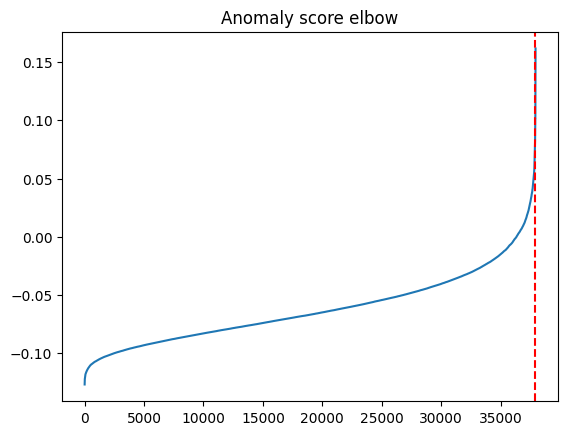

Estimated contamination: 0.03%
Isolation Forest removed 190 rows (0.50%)
Remaining rows: 37755


In [41]:
X_train_iqr = remove_outliers_iqr(X_train, 3)
find_elbow_contamination(X_train_iqr, "auto")
X_train_clean = remove_outliers_isoforest(X_train_iqr, contamination=0.005)


In [42]:
def align_y_with_filtered_X(X_original, X_filtered, y_original):
    """
    Aligns y to match filtered X rows (assuming pandas DataFrame and Series).
    Preserves index alignment.
    """
    if isinstance(X_original, pd.DataFrame) and isinstance(y_original, (pd.Series, pd.DataFrame)):
        return y_original.loc[X_filtered.index]
    else:
        raise ValueError("X must be a pandas DataFrame, and y must be a pandas Series or DataFrame with aligned indices.")

In [43]:
y_train_clean = align_y_with_filtered_X(X_train, X_train_clean, y_train)
print(generate_age_count_table(y_train_clean))
if EDA_AND_VISUALIZATION:
    histograms(X_train_clean)

+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 1443 | 1349 |  2792 |
| 20.0 | 4829 | 5027 |  9856 |
| 30.0 | 3093 | 3164 |  6257 |
| 40.0 | 2754 | 3543 |  6297 |
| 50.0 | 2647 | 4704 |  7351 |
| 60.0 | 1360 | 2413 |  3773 |
| 70.0 | 358  | 910  |  1268 |
| 80.0 |  33  | 113  |  146  |
| 90.0 |  0   |  15  |   15  |
+------+------+------+-------+


## Preprocessing Pipeline

In [44]:
# Log transformation
def use_log(data, scale_by_min=False):
    assert np.min(data) >= 0, 'data contains negative or zero values at log transform'
    transformed = np.log(data)
    return transformed

#we log transform these columns for better scaling
col_to_log_transform = [
    'rmse_mean', 'rmse_std',
    'spec_rolloff_mean', 'spec_rolloff_std',
    'spec_centroid_mean', 'spec_centroid_std',
    'spec_bandwidth_mean', 'spec_bandwidth_std',
    'zcr_mean', 'zcr_std',
    *[f'spec_contrast_band_{i}_mean' for i in range(1, 8)],
    *[f'spec_contrast_band_{i}_std' for i in range(1, 8)],
]



# Defining Transformers
scl = StandardScaler()
log = FunctionTransformer(func=use_log, validate=False, kw_args={'scale_by_min': True}, feature_names_out='one-to-one')

# Defining Models
pca = PCA(n_components=0.95)
lda = LinearDiscriminantAnalysis()

# Pipelines
pipeline_log = Pipeline(steps=[
    ('log', log),
    ('scaler', scl)
])

pipeline_num = Pipeline(steps=[
    ('scaler', scl)
])

# Column selection
preprocessing = ColumnTransformer([
('log', pipeline_log, col_to_log_transform),
], remainder=pipeline_num)

preprocessing_pca = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('pca', pca)
    ]
)
preprocessing_lda = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('lda', lda)
    ]
)


In [45]:
if EDA_AND_VISUALIZATION:
    x_train_pca = preprocessing_pca.fit_transform(X_train)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_train_pca[:, 0], y=x_train_pca[:, 1], hue=y_train["age_young_old"], palette="hls", alpha=0.6)
    plt.title('Scatterplot of PC1 vs PC2')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Age')
    plt.show()

In [46]:
if EDA_AND_VISUALIZATION:
    lda = preprocessing_lda.named_steps['lda']

    # Ensure LDA is fitted
    lda.fit(X_train, y_train['age_young_old_encoded'])

    coefficients = lda.coef_[0]
    imp_lda = pd.DataFrame(coefficients, index=X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

    table = PrettyTable()
    table.field_names = ["Feature", "Coefficient"]
    for row in zip(imp_lda.index, imp_lda['Coefficient']):
        feature = str(row[0])
        coef = float(row[1])
        table.add_row([feature, coef])
    print(table)


In [47]:
if EDA_AND_VISUALIZATION:
    preprocessed = preprocessing.fit_transform(X_train)
    features = preprocessing.get_feature_names_out()
    df = pd.DataFrame(preprocessed, columns=features)
    result=df.head()
    histograms(df)
result    

## Initial Age Model Selection

To begin, we create pipeline creation and evaluation functions. We try all standard classes of predictors for classification.

In [48]:
def evaluate_models(y_true, y_pred_dict, figsize=(12, 8), expanded=True, label=None,binning=None):
    """
    Function to evaluate multiple models and compare their performance
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_dict : dict
        Dictionary of model predictions where keys are model names and values are predicted labels
        Example: {'Model1': y_pred1, 'Model2': y_pred2}
    figsize : tuple, optional
        Figure size for the visualizations, default is (12, 8)
    Returns:
    --------
    metrics_df : pandas DataFrame
        DataFrame containing performance metrics for all models
    """
    if binning:
        y_true_transformed = apply_binning(y_true,binning)
    else:
        y_true_transformed = y_true
    
    # Initialize a dictionary to store metrics
    metrics = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': []
    }
    
    if expanded:
        # Set up the plot for confusion matrices
        n_models = len(y_pred_dict)
        fig, axes = plt.subplots(1, n_models, figsize=figsize)
        if n_models == 1:
            axes = [axes]  # Convert to list for consistent indexing
    
    # Evaluate each model
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if binning:
            y_pred_transformed = apply_binning(y_pred,binning)
        else:
            y_pred_transformed = y_pred
        # Print classification report
        print(f"\n===== {model_name}: {label} =====")
        print("Classification Report:")
        print(classification_report(y_true_transformed, y_pred_transformed))
        
        # Store metrics
        metrics['Model'].append(model_name)
        metrics['Accuracy'].append(accuracy_score(y_true_transformed, y_pred_transformed))
        
        unique_labels = np.unique(y_true_transformed)
        # Handle binary and multi-class cases for precision, recall, and f1
        if len(np.unique(y_true_transformed)) == 2:
            # Binary classification
            metrics['Precision'].append(precision_score(y_true_transformed, y_pred_transformed, average='binary', pos_label=unique_labels[1]))
            metrics['Recall'].append(recall_score(y_true_transformed, y_pred_transformed, average='binary', pos_label=unique_labels[1]))
            metrics['F1-score'].append(f1_score(y_true_transformed, y_pred_transformed, average='binary', pos_label=unique_labels[1]))
        else:
            # Multi-class classification
            metrics['Precision'].append(precision_score(y_true_transformed, y_pred_transformed, average='weighted', labels=unique_labels))
            metrics['Recall'].append(recall_score(y_true_transformed, y_pred_transformed, average='weighted', labels=unique_labels))
            metrics['F1-score'].append(f1_score(y_true_transformed, y_pred_transformed, average='weighted', labels=unique_labels))
            
        if expanded:
            # Plot confusion matrix
            cm = confusion_matrix(y_true_transformed, y_pred_transformed)
            labels = sorted(set(y_true_transformed).union(set(y_pred_transformed)))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[i])
            axes[i].set_title(f'Confusion Matrix - {model_name}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
    
    if expanded:
        plt.tight_layout()
        plt.show()
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    if expanded:
        # Plot metrics comparison
        plt.figure(figsize=figsize)
        metrics_df_plot = metrics_df.set_index('Model')
        ax = metrics_df_plot.plot(kind='bar', figsize=figsize)
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

        plt.show()
    
    return metrics_df

In [49]:
def fit_pipeline_predict_evaluate(model_class, model_name, X_train=X_train_clean, y_train=y_train_clean['age_young_old'], X_comp=X_val, y_comp=y_val['age_young_old'], PCA=False, LDA=False, binning=None, multiclass=False, return_pipeline=False):
    """
    Function to fit a pipeline, make predictions, and evaluate the model with optional weights.
    """
    assert not (PCA and LDA and multiclass), "PCA and LDA cannot be used together with multiclass."
    assert not (PCA and multiclass), "PCA cannot be used with multiclass."
    assert not (LDA and multiclass), "LDA cannot be used with multiclass."
    # Build pipelines
    pipeline = make_pipeline(clone(preprocessing), clone(model_class))
        
    # Fit the model
    print(f"Fitting {model_name}...")
    pipeline.fit(X_train, y_train)
    
    if multiclass:
        # Predict on training set
        print(f"Predicting on training set...")
        prd_train = pipeline.predict(X_train)[:, 1]
        # Predict on validation set
        print(f"Predicting on validation set...")
        prd_val = pipeline.predict(X_comp)[:, 1]
    else:
        # Predict on training set
        print(f"Predicting on training set...")
        prd_train = pipeline.predict(X_train)
        # Predict on validation set
        print(f"Predicting on comparison set...")
        prd_val = pipeline.predict(X_comp)

    # Same Pipeline for PCA and LDA if selected
    if PCA:
        model_pca = clone(model_class)
        pipeline_pca = make_pipeline(preprocessing_pca, model_pca)
        pipeline_pca.fit(X_train, y_train)
        prd_train_pca = pipeline_pca.predict(X_train)
        prd_val_pca = pipeline_pca.predict(X_comp)

    if LDA:
        model_lda = clone(model_class)
        pipeline_lda = make_pipeline(preprocessing_lda, model_lda)
        pipeline_lda.fit(X_train, y_train)
        prd_train_lda = pipeline_lda.predict(X_train)
        prd_val_lda = pipeline_lda.predict(X_comp)

    if PCA and LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
            f'{model_name}_lda': prd_val_lda,
        }
    elif PCA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
        }
    elif LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_lda': prd_val_lda,
        }
    else:
        evaluate_train = {
            f'{model_name}': prd_train,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
        }
    
    if multiclass:
        y_train= y_train[:, 1]
        y_comp= y_comp[:, 1]

    # Evaluate on training predictions
    print(f"Evaluating {model_name} on training set...")
    evaluate_models(y_train, evaluate_train, (12, 8), False, "Training Set", binning=binning)

    # Evaluate on comparison predictions
    print(f"Evaluating {model_name} on comparison set...")
    if return_pipeline:
        evaluate_models(y_comp, evaluate_val, (12, 8), True, "Comparison Set", binning=binning)
        return pipeline
    else:
        return evaluate_models(y_comp, evaluate_val, (12, 8), True, "Comparison Set", binning=binning)

In [93]:
X_train_clean.shape

(37755, 88)

Fitting Logistic Regression...
Predicting on training set...
Predicting on comparison set...
Evaluating Logistic Regression on training set...

===== Logistic Regression: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.63      0.65      0.64     18850
       young       0.64      0.61      0.63     18905

    accuracy                           0.63     37755
   macro avg       0.63      0.63      0.63     37755
weighted avg       0.63      0.63      0.63     37755


===== Logistic Regression_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.62      0.65      0.63     18850
       young       0.63      0.60      0.62     18905

    accuracy                           0.63     37755
   macro avg       0.63      0.63      0.63     37755
weighted avg       0.63      0.63      0.63     37755


===== Logistic Regression_lda: Training Set =====
Classifi

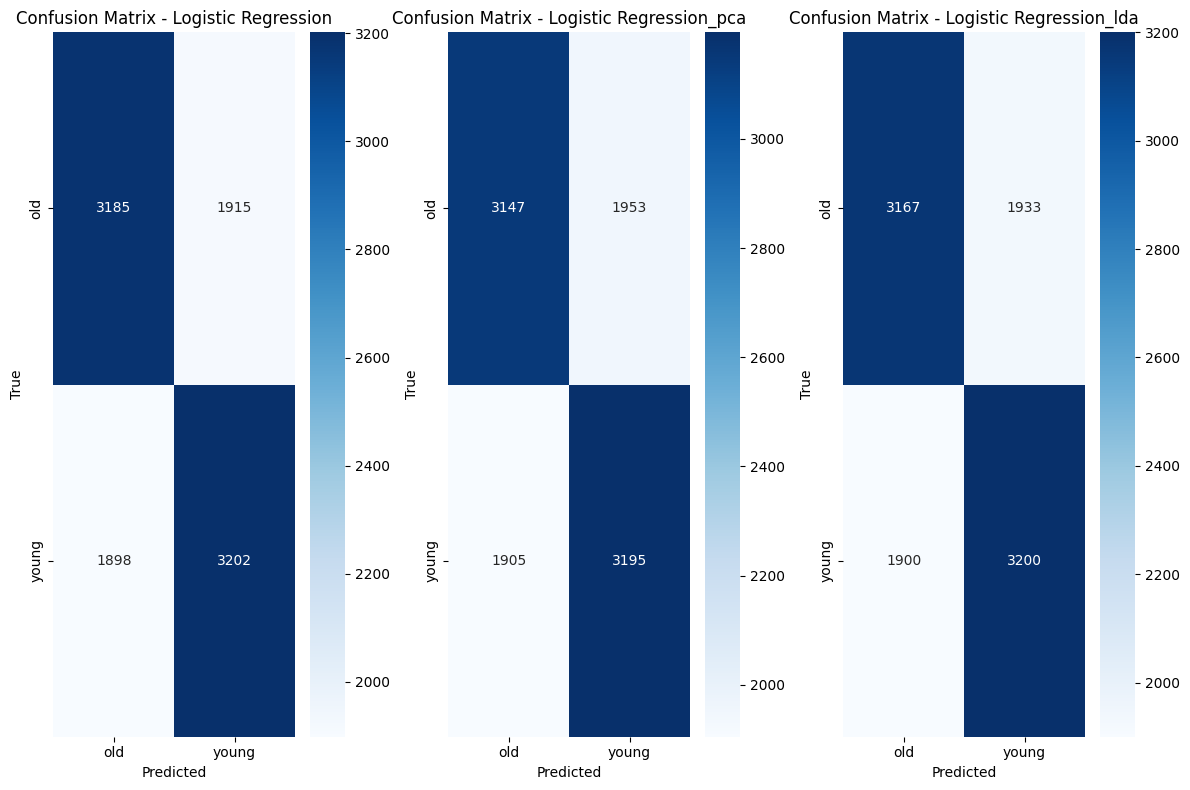

<Figure size 1200x800 with 0 Axes>

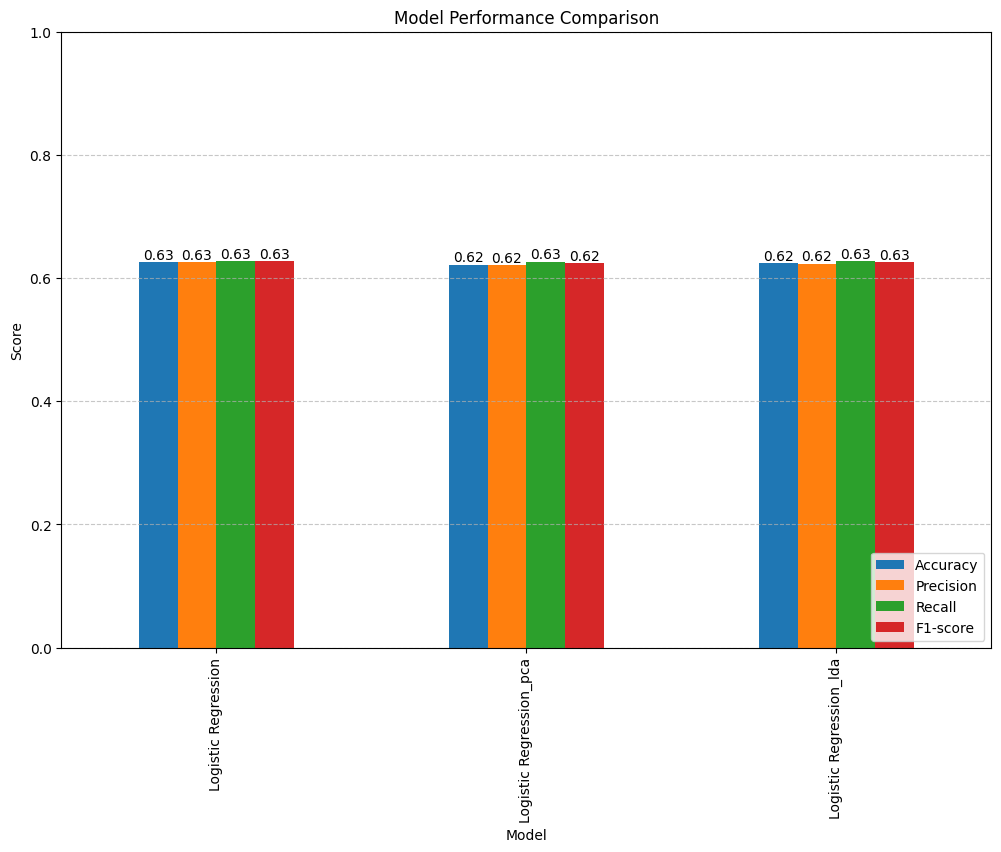

In [82]:
logistic_metrics=fit_pipeline_predict_evaluate(LogisticRegression(solver='lbfgs', max_iter=5000, C=0.01, random_state=27),
        "Logistic Regression", PCA=True, LDA=True)

Fitting SVC...
Predicting on training set...
Predicting on comparison set...
Evaluating SVC on training set...

===== SVC: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.63      0.65      0.64     18850
       young       0.64      0.61      0.62     18905

    accuracy                           0.63     37755
   macro avg       0.63      0.63      0.63     37755
weighted avg       0.63      0.63      0.63     37755


===== SVC_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.62      0.65      0.63     18850
       young       0.63      0.60      0.62     18905

    accuracy                           0.63     37755
   macro avg       0.63      0.63      0.63     37755
weighted avg       0.63      0.63      0.63     37755


===== SVC_lda: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         o

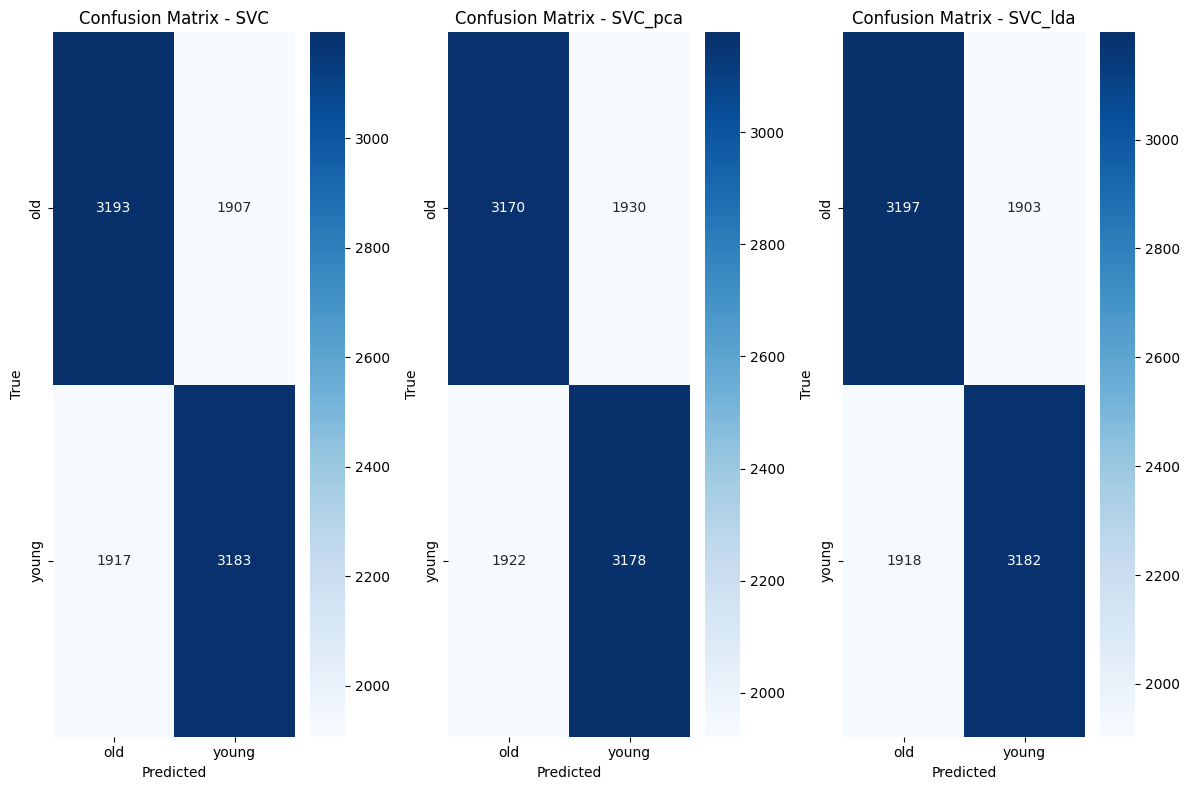

<Figure size 1200x800 with 0 Axes>

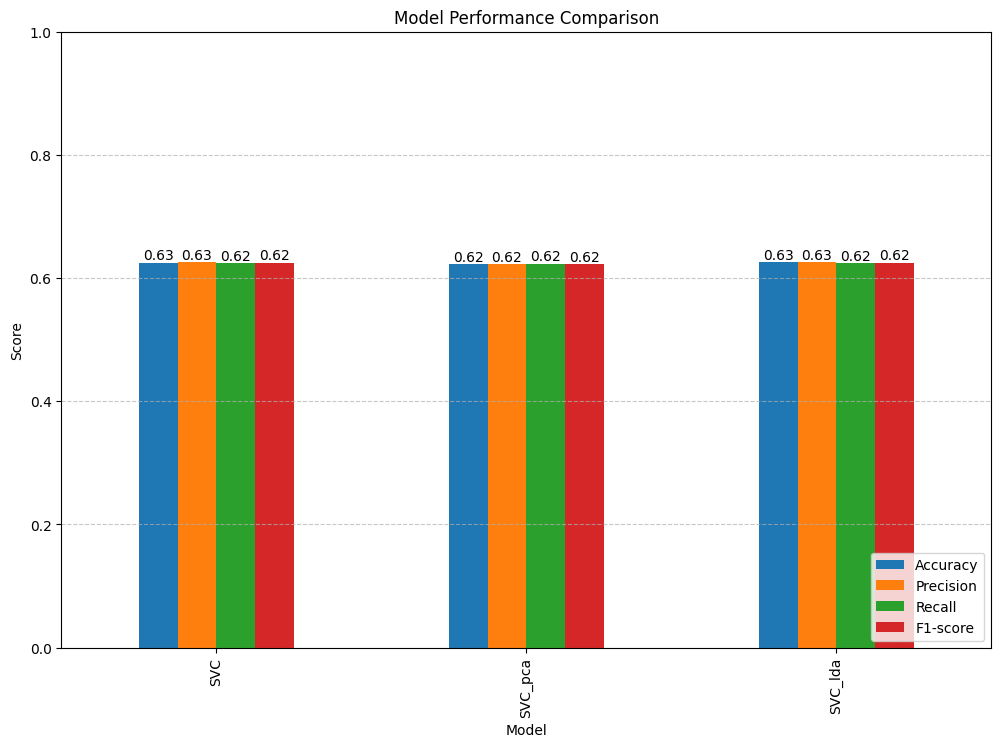

In [83]:
svc_metrics=fit_pipeline_predict_evaluate(LinearSVC(random_state=27, max_iter=1000), "SVC", PCA=True, LDA=True)

Fitting KNeighbors Classifier...
Predicting on training set...
Predicting on comparison set...
Evaluating KNeighbors Classifier on training set...

===== KNeighbors Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.72      0.83      0.77     18850
       young       0.80      0.67      0.73     18905

    accuracy                           0.75     37755
   macro avg       0.76      0.75      0.75     37755
weighted avg       0.76      0.75      0.75     37755


===== KNeighbors Classifier_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.71      0.82      0.76     18850
       young       0.79      0.67      0.73     18905

    accuracy                           0.75     37755
   macro avg       0.75      0.75      0.75     37755
weighted avg       0.75      0.75      0.75     37755


===== KNeighbors Classifier_lda: Training Set ====

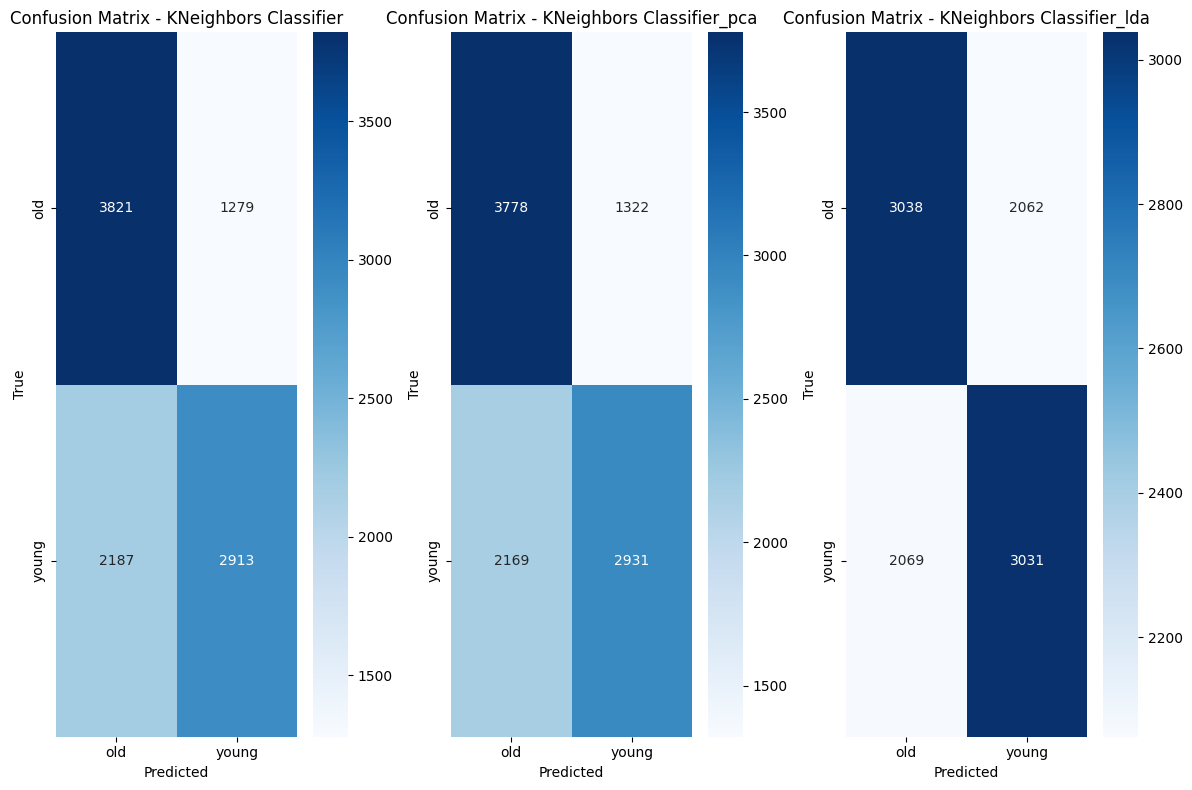

<Figure size 1200x800 with 0 Axes>

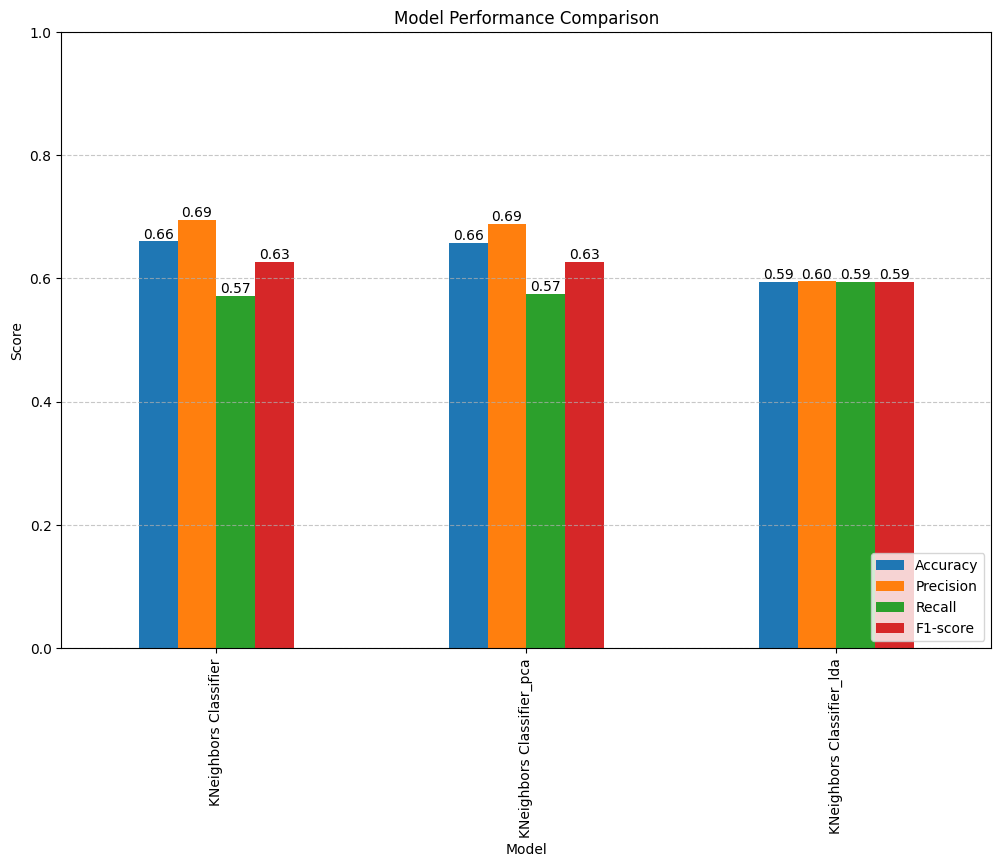

In [85]:
kneighbors_metrics=fit_pipeline_predict_evaluate(KNeighborsClassifier(n_neighbors=11), "KNeighbors Classifier", LDA=True, PCA=True)

Fitting Random Forest Classifier...
Predicting on training set...
Predicting on comparison set...
Evaluating Random Forest Classifier on training set...

===== Random Forest Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       1.00      1.00      1.00     18850
       young       1.00      1.00      1.00     18905

    accuracy                           1.00     37755
   macro avg       1.00      1.00      1.00     37755
weighted avg       1.00      1.00      1.00     37755


===== Random Forest Classifier_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       1.00      1.00      1.00     18850
       young       1.00      1.00      1.00     18905

    accuracy                           1.00     37755
   macro avg       1.00      1.00      1.00     37755
weighted avg       1.00      1.00      1.00     37755


===== Random Forest Classifier_lda: Tr

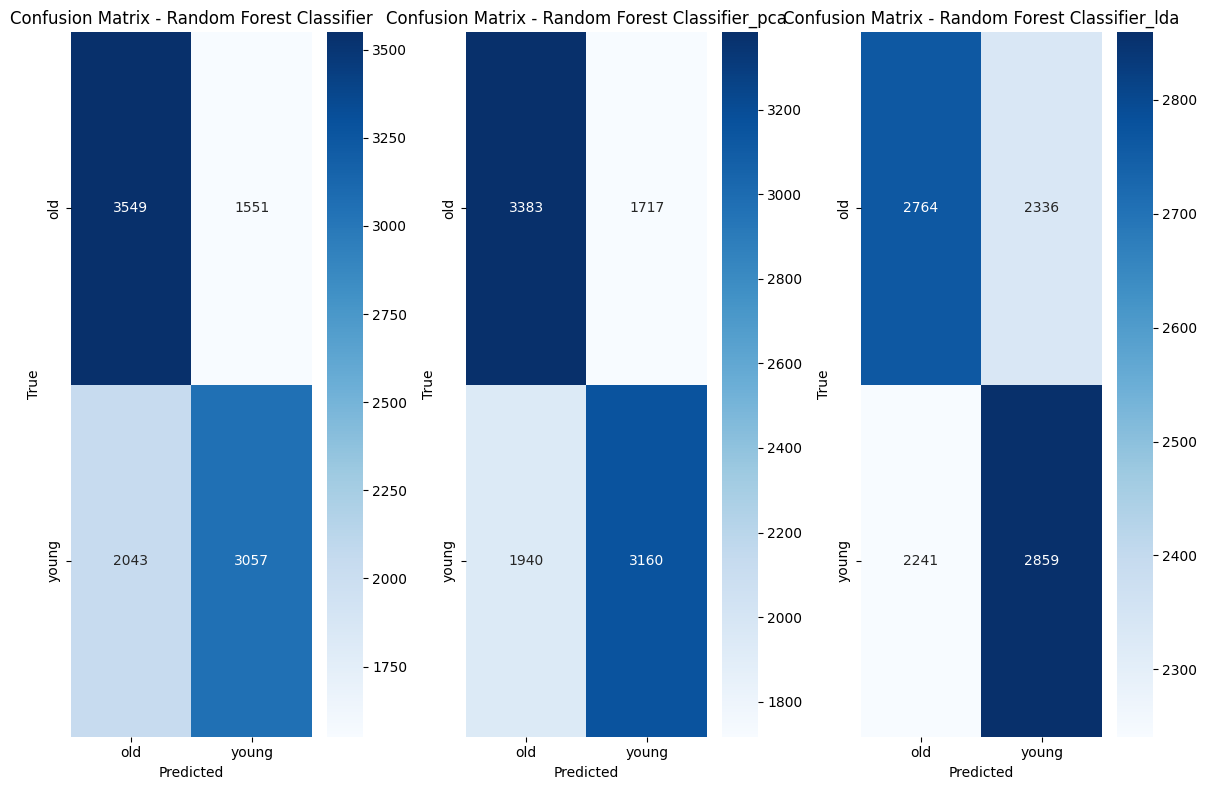

<Figure size 1200x800 with 0 Axes>

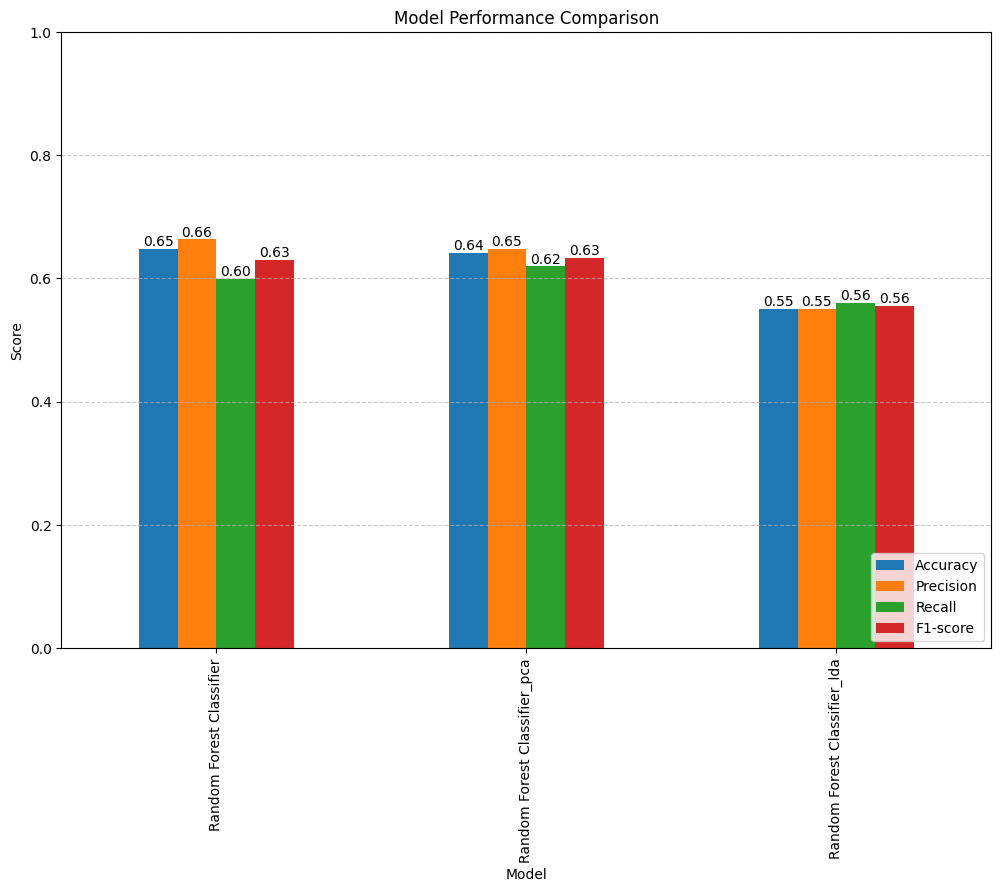

In [84]:
rand_forest_metrics=fit_pipeline_predict_evaluate(RandomForestClassifier(n_estimators=100,
                                                                         max_features="sqrt", random_state=27, n_jobs= -1)
, "Random Forest Classifier",  PCA=True, LDA=True)

Fitting Gradient Boosting Classifier...
Predicting on training set...
Predicting on comparison set...
Evaluating Gradient Boosting Classifier on training set...

===== Gradient Boosting Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.87      0.91      0.89     18850
       young       0.91      0.86      0.88     18905

    accuracy                           0.89     37755
   macro avg       0.89      0.89      0.89     37755
weighted avg       0.89      0.89      0.89     37755


===== Gradient Boosting Classifier_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.73      0.77      0.75     18850
       young       0.76      0.72      0.74     18905

    accuracy                           0.75     37755
   macro avg       0.75      0.75      0.75     37755
weighted avg       0.75      0.75      0.75     37755


===== Gradient Boostin

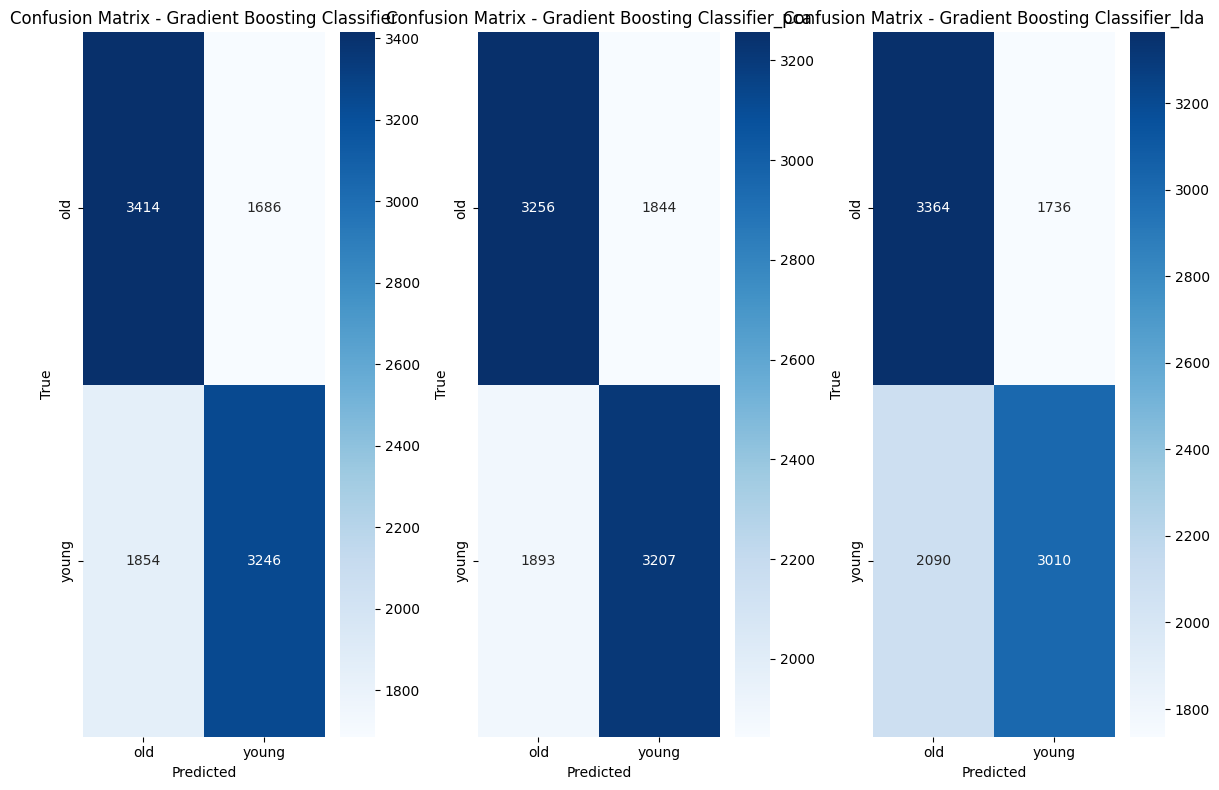

<Figure size 1200x800 with 0 Axes>

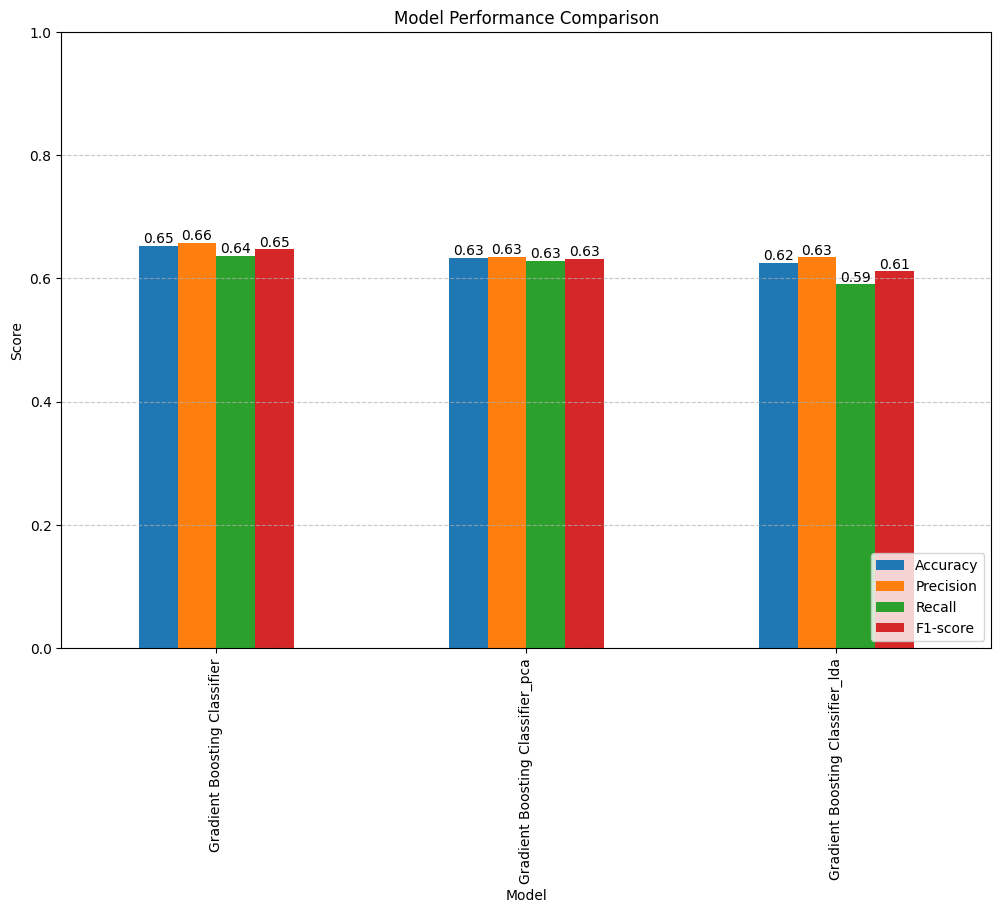

In [86]:
gradient_boosting_metrics=fit_pipeline_predict_evaluate(HistGradientBoostingClassifier(
 max_iter=600, 
 random_state=27), "Gradient Boosting Classifier", PCA = True, LDA = True)

Fitting MLP...
Predicting on training set...
Predicting on comparison set...
Evaluating MLP on training set...

===== MLP: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.99      1.00      0.99     18850
       young       1.00      0.99      0.99     18905

    accuracy                           0.99     37755
   macro avg       0.99      0.99      0.99     37755
weighted avg       0.99      0.99      0.99     37755


===== MLP_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.99      0.99      0.99     18850
       young       0.99      0.99      0.99     18905

    accuracy                           0.99     37755
   macro avg       0.99      0.99      0.99     37755
weighted avg       0.99      0.99      0.99     37755


===== MLP_lda: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         o

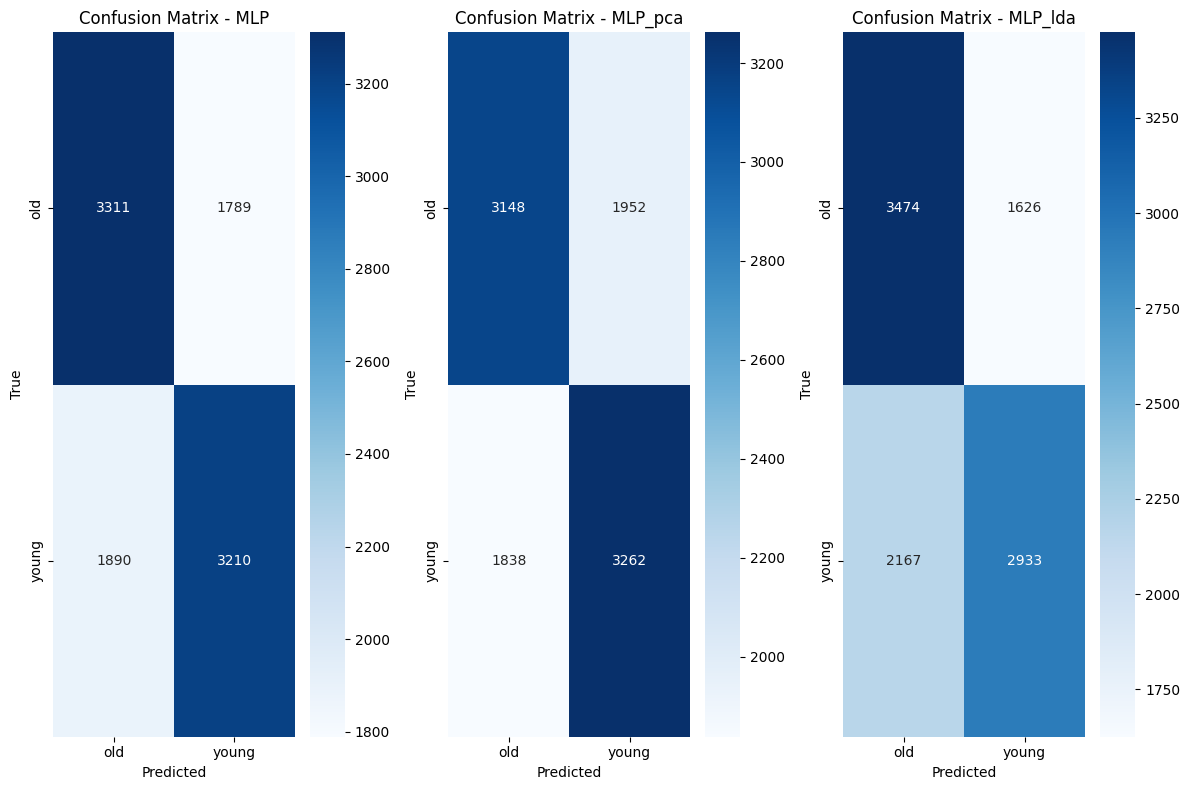

<Figure size 1200x800 with 0 Axes>

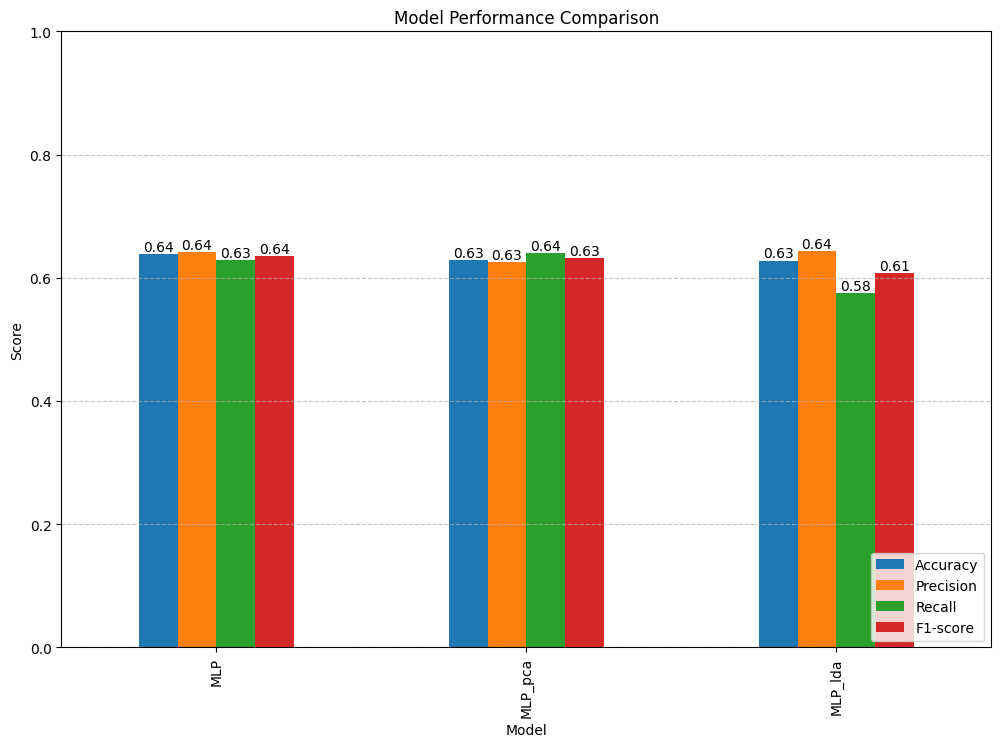

In [ ]:
mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes= (128, 64), learning_rate_init=0.001,  max_iter=1000,
        random_state=27,learning_rate='adaptive'), "MLP", PCA=False, LDA=True)

Fitting Multi Output...
Predicting on training set...
Predicting on validation set...
Evaluating Multi Output on training set...

===== Multi Output: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18905
         1.0       1.00      1.00      1.00     18850

    accuracy                           1.00     37755
   macro avg       1.00      1.00      1.00     37755
weighted avg       1.00      1.00      1.00     37755

Evaluating Multi Output on comparison set...

===== Multi Output: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.65      5100
         1.0       0.65      0.66      0.65      5100

    accuracy                           0.65     10200
   macro avg       0.65      0.65      0.65     10200
weighted avg       0.65      0.65      0.65     10200



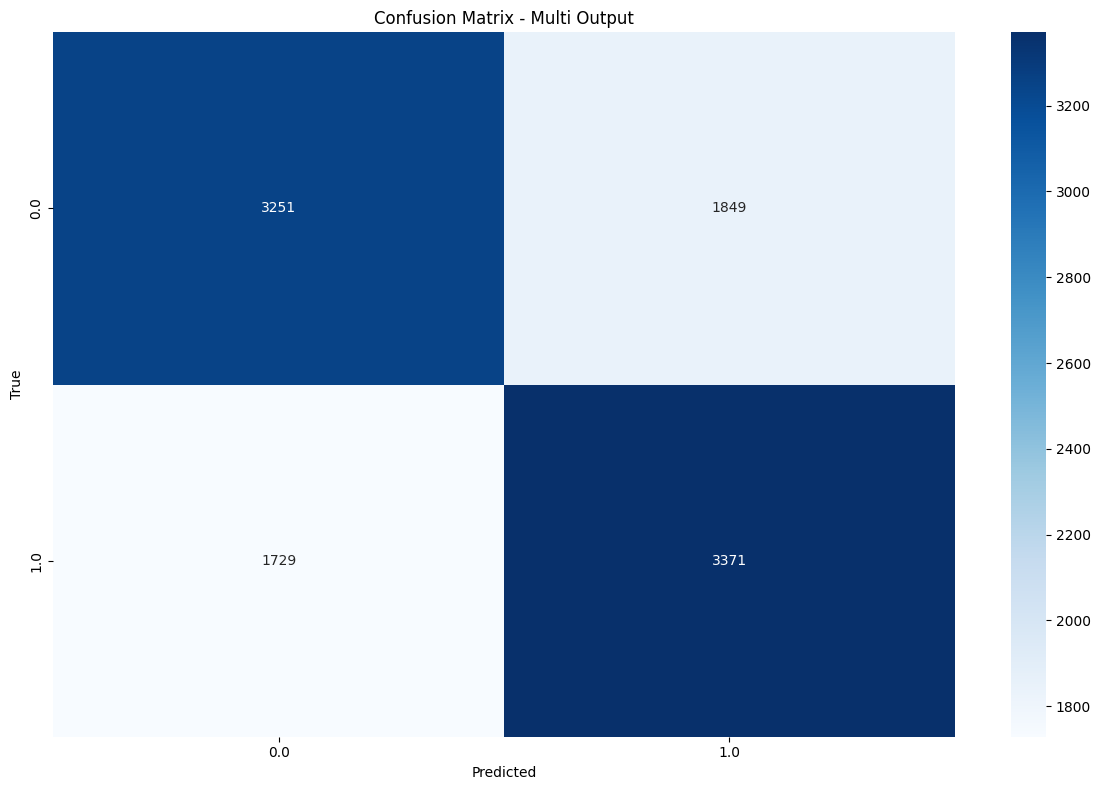

<Figure size 1200x800 with 0 Axes>

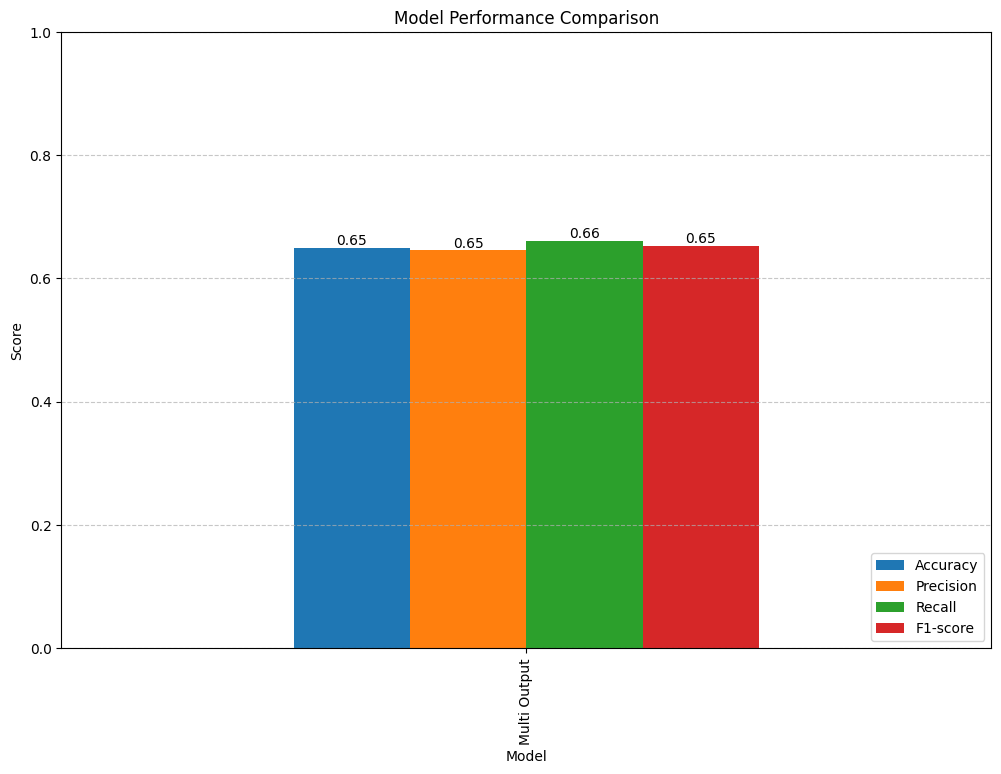

In [88]:
y_train_multi = np.column_stack((y_train_clean["age"], y_train_clean["age_young_old_encoded"]))
y_val_multi = np.column_stack((y_val["age"], y_val["age_young_old_encoded"]))

base_clf = RandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    n_jobs= -1,
    random_state=27)

multi_clf = MultiOutputClassifier(base_clf)

multi_output_metrics=fit_pipeline_predict_evaluate( multi_clf, "Multi Output", y_train=y_train_multi, y_comp=y_val_multi, multiclass=True)

In [66]:
def compare_selected_metrics(*metrics_dfs, selected_columns=None, exclude_suffixes=('pca', 'lda'), fig_size=(12, 8)):
    """
    Compare selected metrics from multiple model evaluation DataFrames.

    Parameters:
        *metrics_dfs: Variable number of pandas DataFrames containing model metrics with a 'Model' column.
        selected_columns (list of str): Metrics to include in the comparison. Defaults to common classification metrics.
        exclude_suffixes (tuple of str): Model name suffixes to exclude (e.g., 'pca', 'lda').
    """
    
    # Default metrics to display if not provided
    if selected_columns is None:
        selected_columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    # Combine all DataFrames into one
    combined_metrics = pd.concat(
        [df.set_index('Model') for df in metrics_dfs],
        axis=0
    )

    # Optionally filter out models by suffix
    if exclude_suffixes:
        combined_metrics = combined_metrics[~combined_metrics.index.str.endswith(exclude_suffixes)]

    # Select only relevant columns
    selected_metrics = combined_metrics[selected_columns]

    # Plot
    plt.figure(figsize=fig_size)
    ax = selected_metrics.plot(kind='bar', figsize=fig_size)
    plt.title('Comparison of Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

    plt.show()


<Figure size 2000x1600 with 0 Axes>

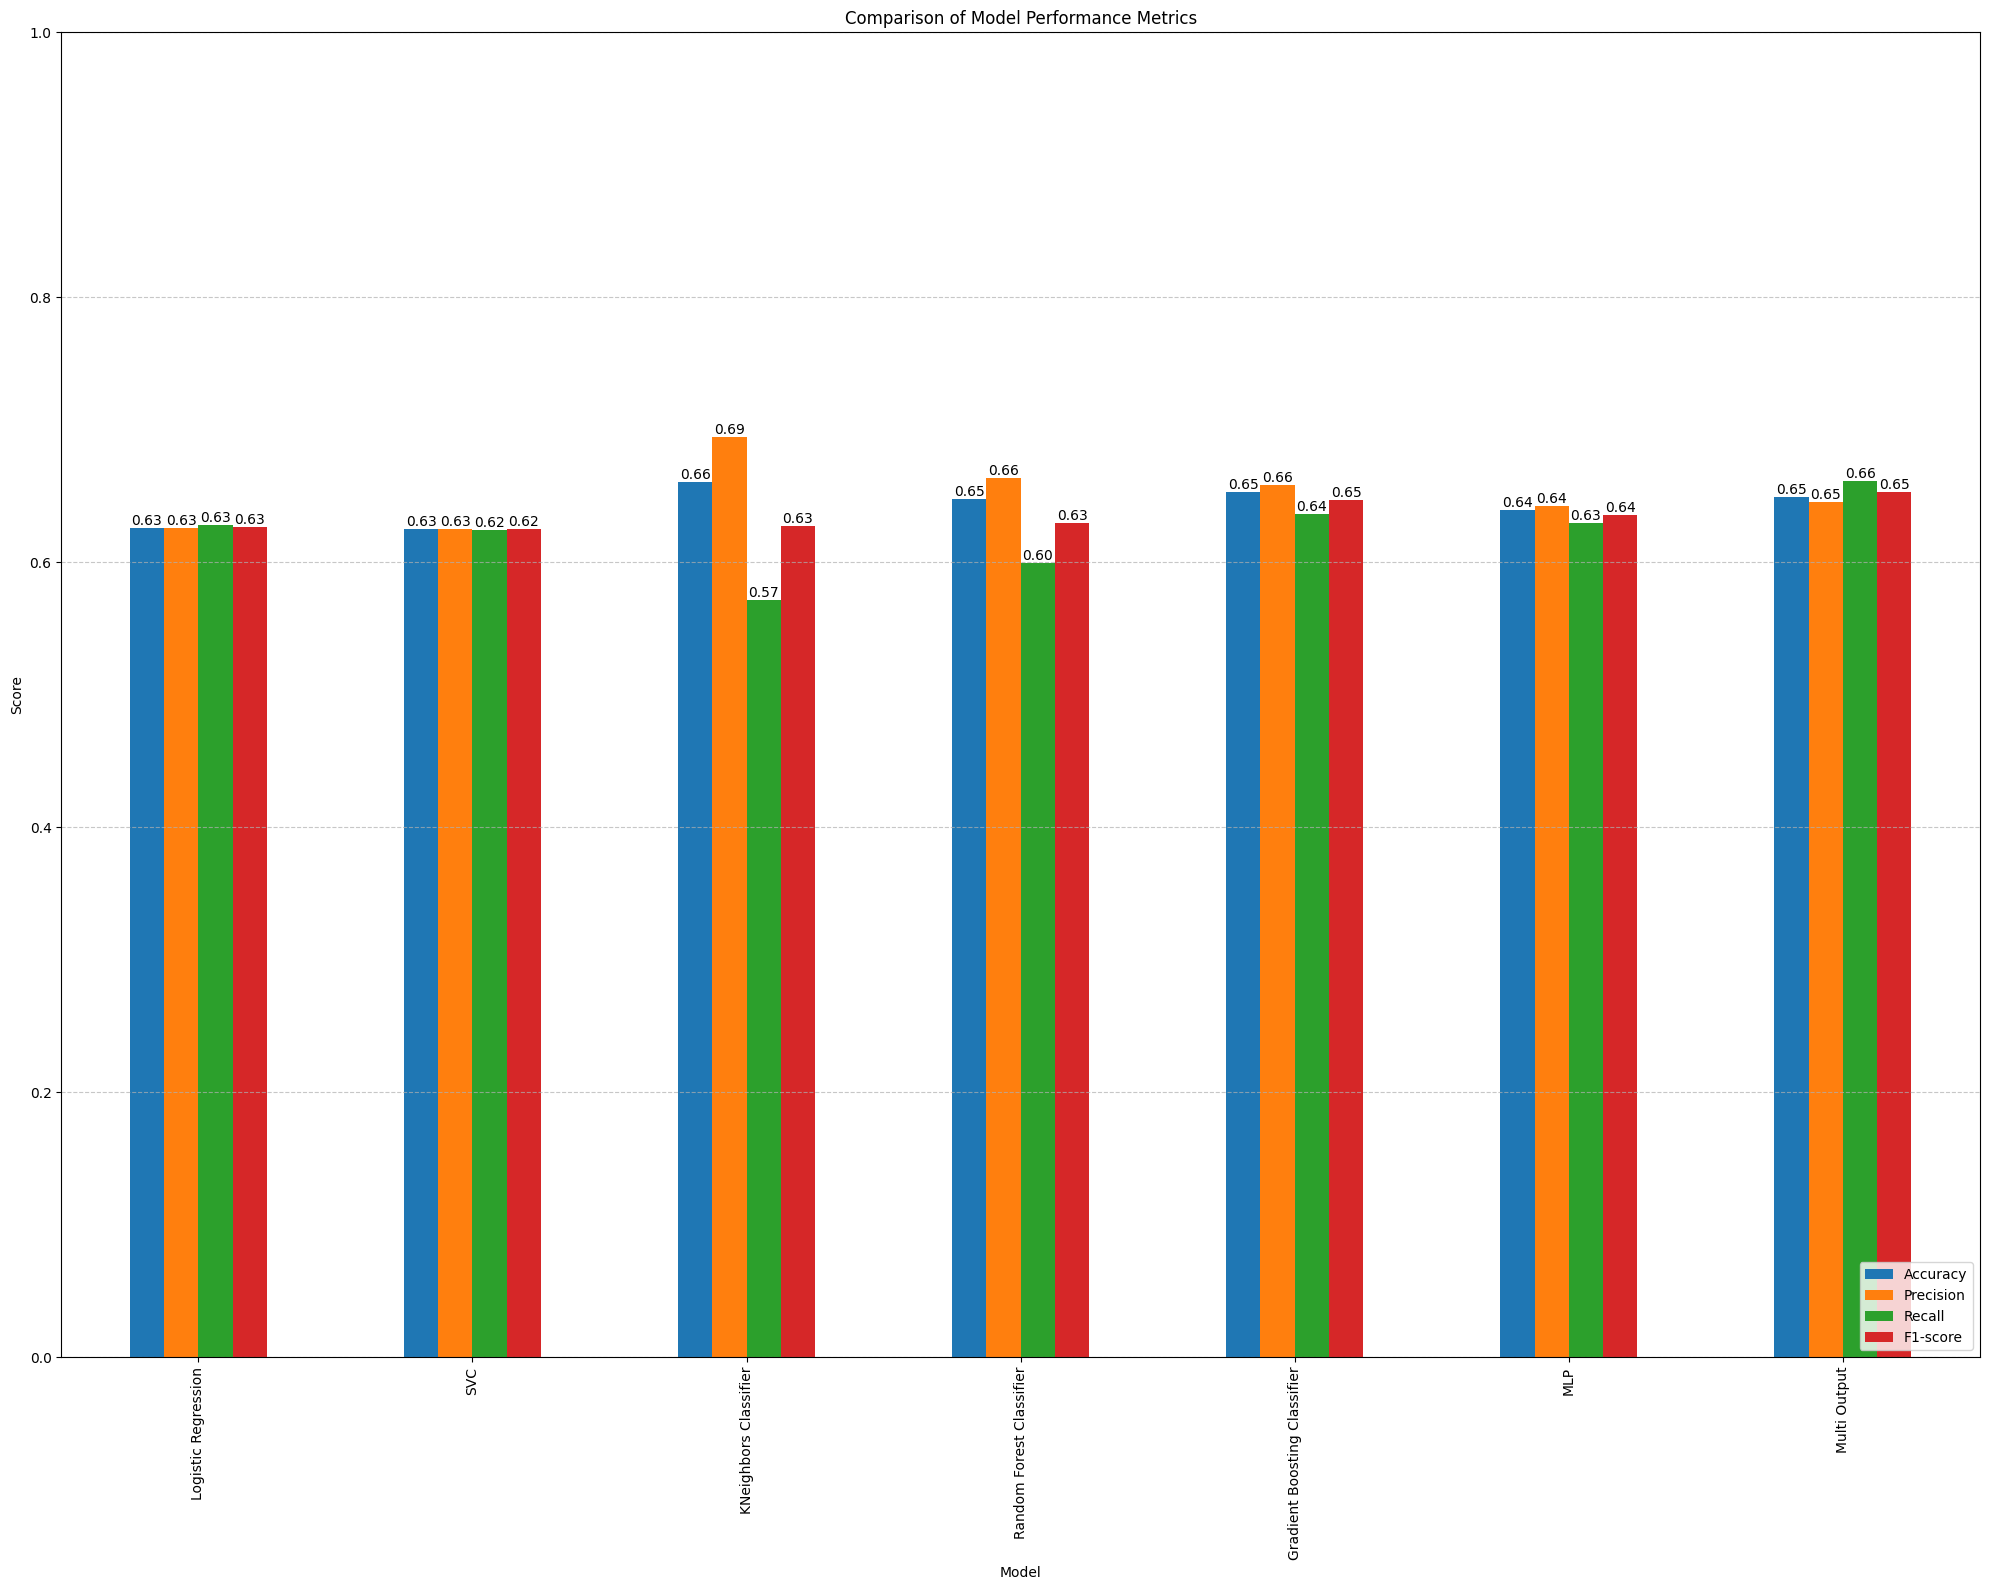

In [62]:
compare_selected_metrics(
    logistic_metrics,
    svc_metrics,
    kneighbors_metrics,
    rand_forest_metrics,
    gradient_boosting_metrics,
    mlp_metrics,
    multi_output_metrics,
    selected_columns=['Accuracy', 'Precision', 'Recall', 'F1-score'],
    fig_size=(20, 16)
)

## Gender Prediction

The prediction quality of young old is unfortunately not as good as hoped. We now try to see if we are more successful at predicting gender.

In [63]:
# Gender separated data
X_train_male = X_train_clean[y_train_clean['gender'] == 'male_masculine']
y_train_male = y_train_clean[y_train_clean['gender'] == 'male_masculine']
X_train_female = X_train_clean[y_train_clean['gender'] == 'female_feminine']
y_train_female = y_train_clean[y_train_clean['gender'] == 'female_feminine']
X_val_male = X_val[y_val['gender'] == 'male_masculine']
y_val_male = y_val[y_val['gender'] == 'male_masculine']
X_val_female = X_val[y_val['gender'] == 'female_feminine']
y_val_female = y_val[y_val['gender'] == 'female_feminine']

Fitting RandomForest_Gender...
Predicting on training set...
Predicting on comparison set...
Evaluating RandomForest_Gender on training set...

===== RandomForest_Gender: Training Set =====
Classification Report:
                 precision    recall  f1-score   support

female_feminine       1.00      1.00      1.00     16517
 male_masculine       1.00      1.00      1.00     21238

       accuracy                           1.00     37755
      macro avg       1.00      1.00      1.00     37755
   weighted avg       1.00      1.00      1.00     37755

Evaluating RandomForest_Gender on comparison set...

===== RandomForest_Gender: Comparison Set =====
Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.87      0.84      0.85      4502
 male_masculine       0.87      0.90      0.89      5698

       accuracy                           0.87     10200
      macro avg       0.87      0.87      0.87     10200
   weighted avg       0.87     

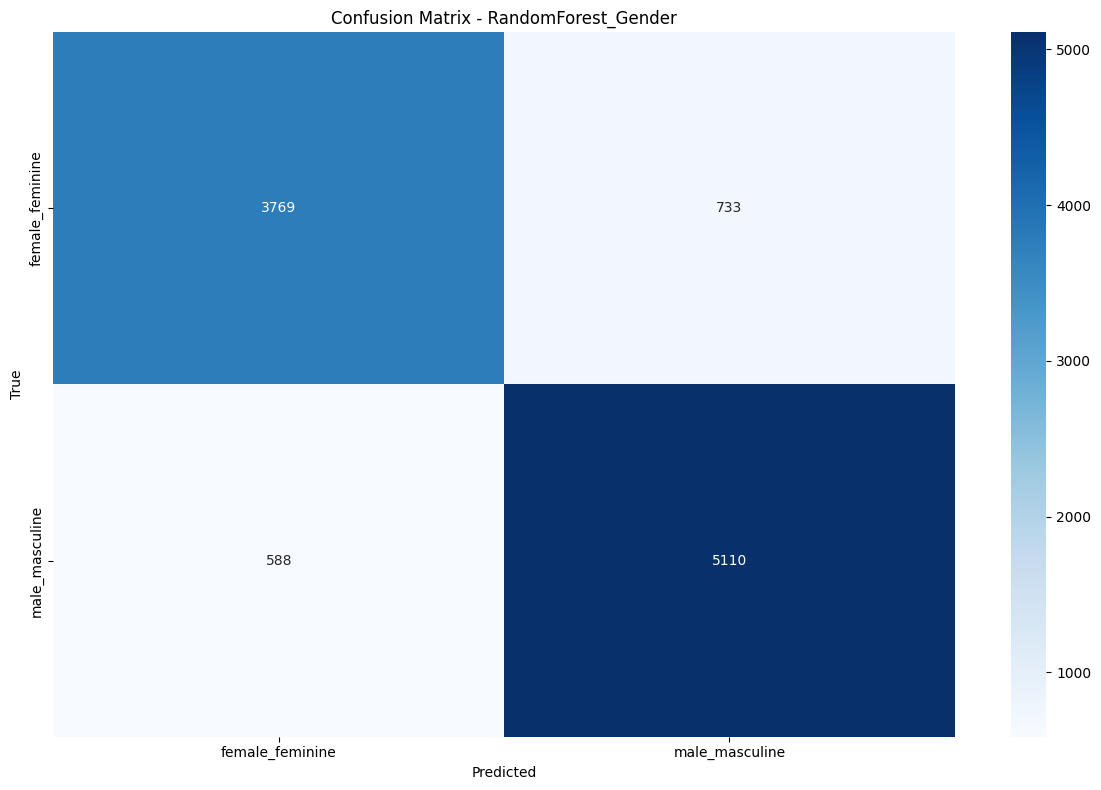

<Figure size 1200x800 with 0 Axes>

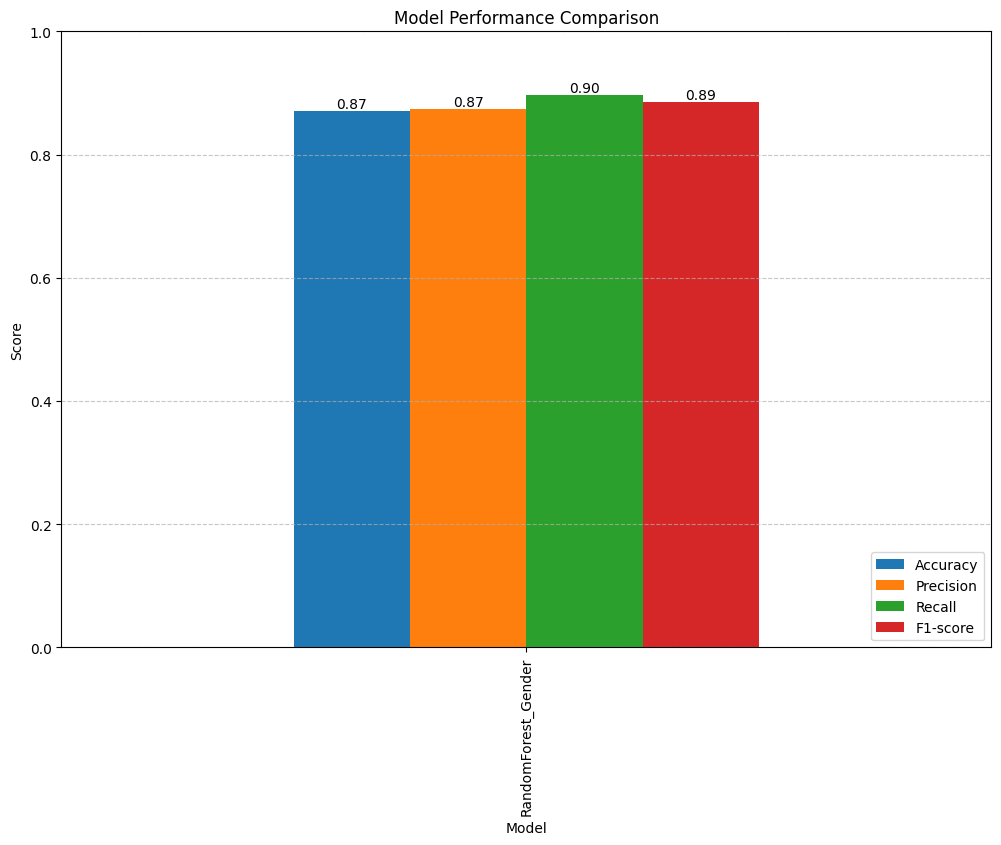

In [64]:
rf_gender_metrics = fit_pipeline_predict_evaluate(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=27,
        n_jobs=-1
    ),
    model_name="RandomForest_Gender",
    y_train=y_train_clean['gender'],
    y_comp=y_val['gender']
)

Fitting MLP_Gender...
Predicting on training set...
Predicting on comparison set...
Evaluating MLP_Gender on training set...

===== MLP_Gender: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     16517
           1       0.95      0.96      0.95     21238

    accuracy                           0.95     37755
   macro avg       0.95      0.94      0.95     37755
weighted avg       0.95      0.95      0.95     37755

Evaluating MLP_Gender on comparison set...

===== MLP_Gender: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4502
           1       0.91      0.92      0.92      5698

    accuracy                           0.90     10200
   macro avg       0.90      0.90      0.90     10200
weighted avg       0.90      0.90      0.90     10200



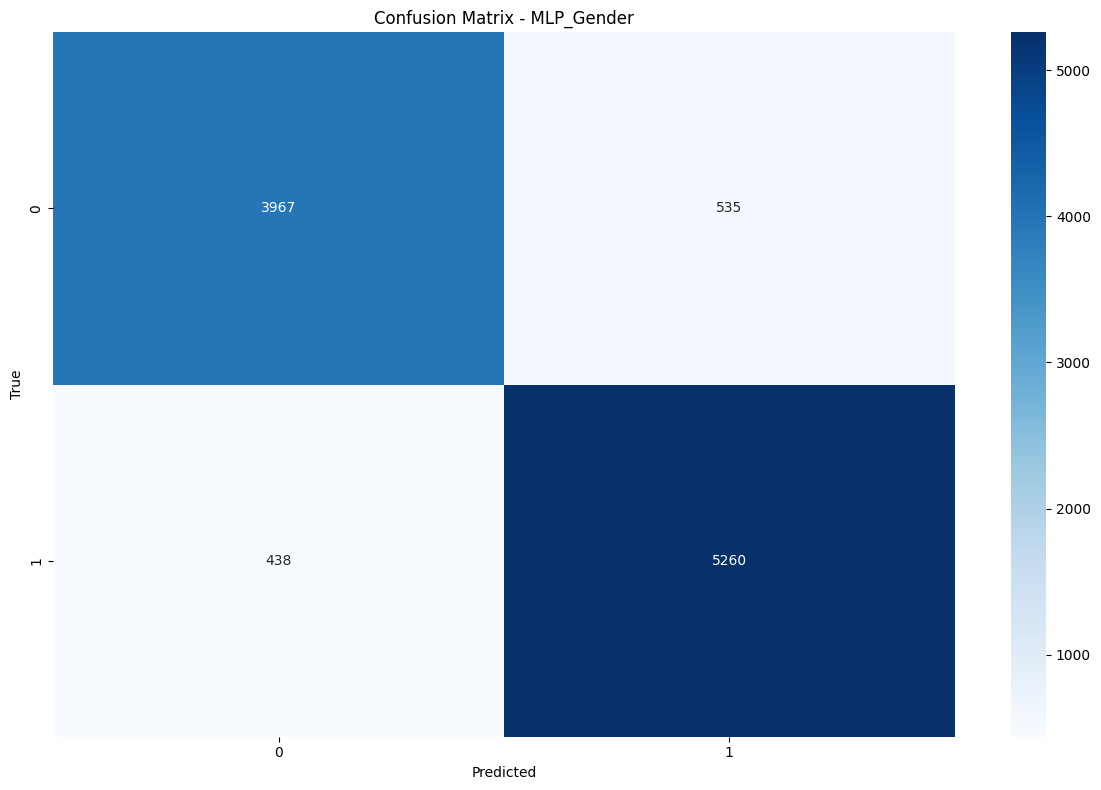

<Figure size 1200x800 with 0 Axes>

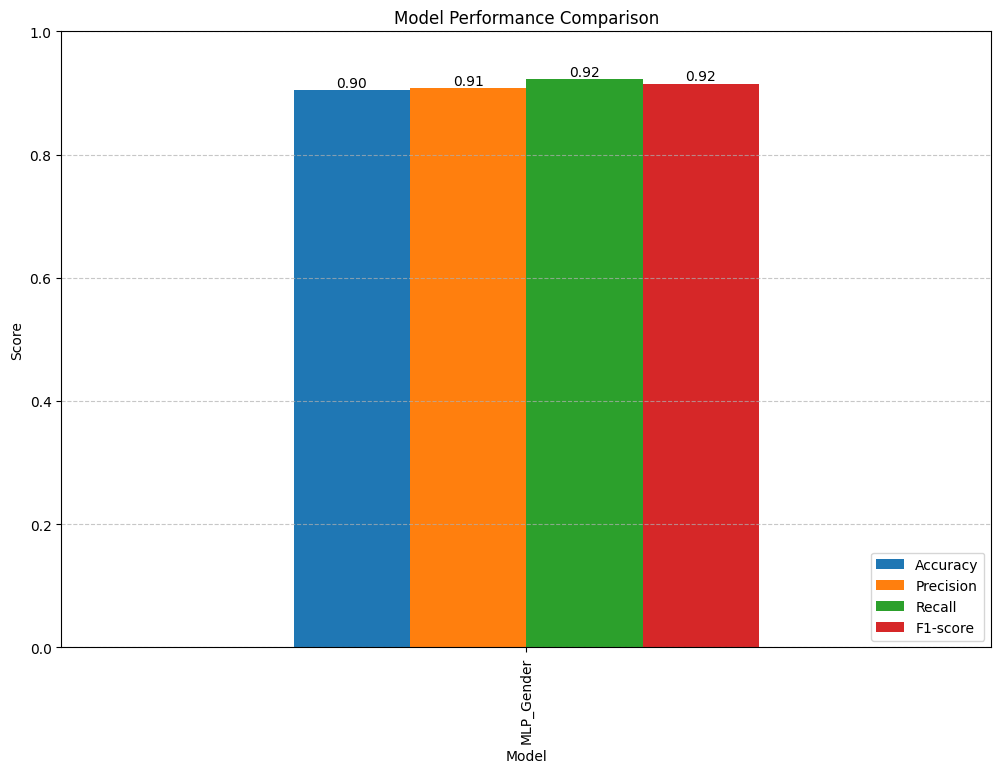

In [65]:
mlp_gender_metrics = fit_pipeline_predict_evaluate(
    MLPClassifier(
        hidden_layer_sizes=(64, 32),
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=27,
        learning_rate='adaptive',
        early_stopping=True,
        validation_fraction=0.1
    ),
    model_name="MLP_Gender",
    y_train=y_train_clean['gender_encoded'],
    y_comp=y_val['gender_encoded']
)

<Figure size 1200x800 with 0 Axes>

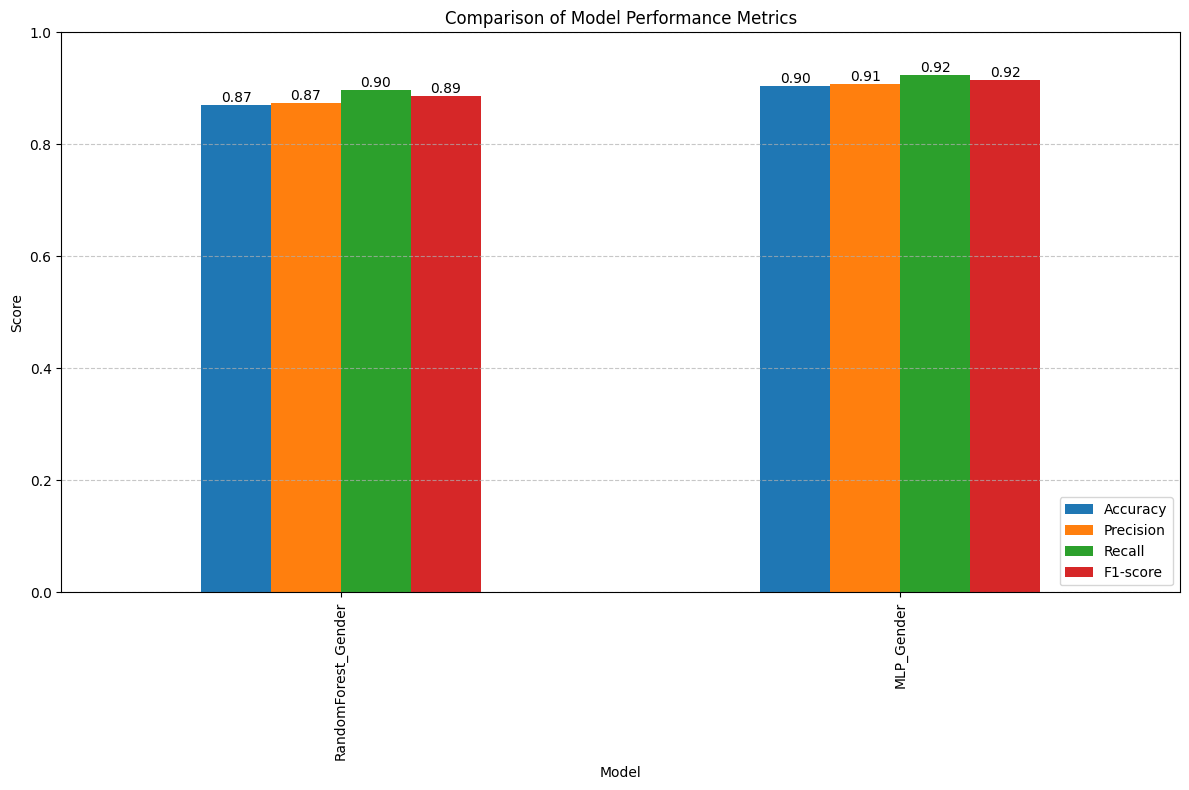

In [66]:
compare_selected_metrics(rf_gender_metrics, mlp_gender_metrics)

## Grid Search

With these results, we now try to find the best prediction algorithms for both age and gender.

In [50]:
def optimize_via_grid_search(
    model_class,model_name, param_grid,
    X_train=X_train_clean, y_train=y_train_clean, X_val=X_val, y_val=y_val, y_parameter="age_young_old_encoded"
):
    """
    Grid search optimization

    Parameters
    ----------
    model_class: sklearn estimator
        Class of the model to be optimized
    model_name : str
        Name of the model
    param_grid : dict
        Grid search parameters for the model
    X_train, X_val : pd.DataFrame
        Feature data for training and validation
    y_train, y_val : pd.DataFrame
        Must include the y_parameter column
    y_parameter : str
        The column name of the target variable in y_train and y_val

    Returns
    -------
    best_model : sklearn estimator
    evaluate_train : dict
    evaluate_val : dict
    results_df_sorted : pd.DataFrame
    """

    model=clone(model_class)
    
    pipeline = Pipeline([
        ('preprocessing', preprocessing),
        (model_name, model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1,
    )

    print(f"Starting grid search for {model_name} (predicting {y_parameter})...")
    grid_search.fit(X_train, y_train[y_parameter])

    print(f"\nBest Parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    # Detailed results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)
    display_cols = [col for col in results_df.columns if col.startswith("param_")]
    display_cols += ['mean_test_score', 'std_test_score']
    print("\nTop 5 configurations:")
    print(results_df_sorted[display_cols].head())

    # Predictions
    prd_train = best_model.predict(X_train)
    prd_val = best_model.predict(X_val)

    evaluate_train = {model_name: prd_train}
    evaluate_val = {model_name: prd_val}
    
    print(f"\nEvaluating {model_name} on training set...")
    train_result=evaluate_models(y_train[y_parameter], evaluate_train, (12, 8), False, "Training Set")

    print(f"\nEvaluating {model_name} on validation set...")
    val_results=evaluate_models(y_val[y_parameter], evaluate_val, (12, 8), True, "Validation Set")

    return best_model, train_result, val_results, results_df_sorted

#### Optimize Age Models

Starting grid search for mlp (predicting age_young_old_encoded)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam, mlp__validation_fraction=0.1; total time=   7.7s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=300, mlp__solver=adam, mlp__validation_fraction=0.1; total time=   7.8s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=300, mlp__solver=adam, mlp__validation_fraction=0.1; total time=   9.2s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer

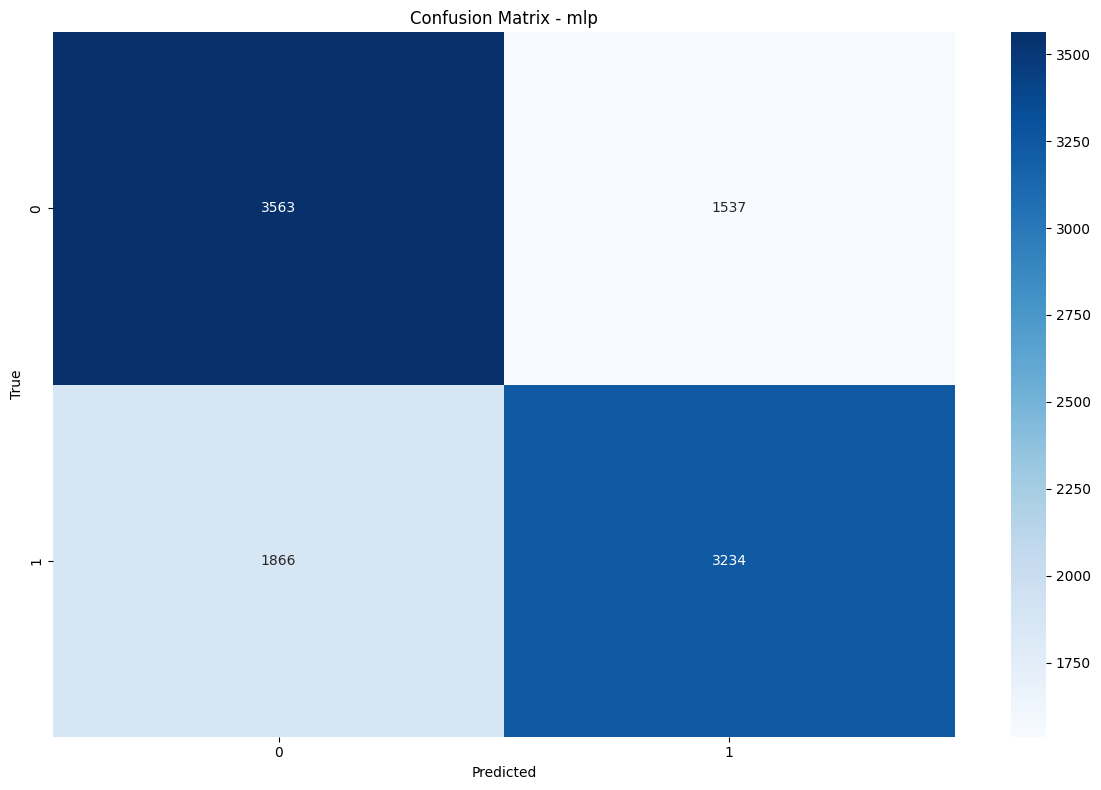

<Figure size 1200x800 with 0 Axes>

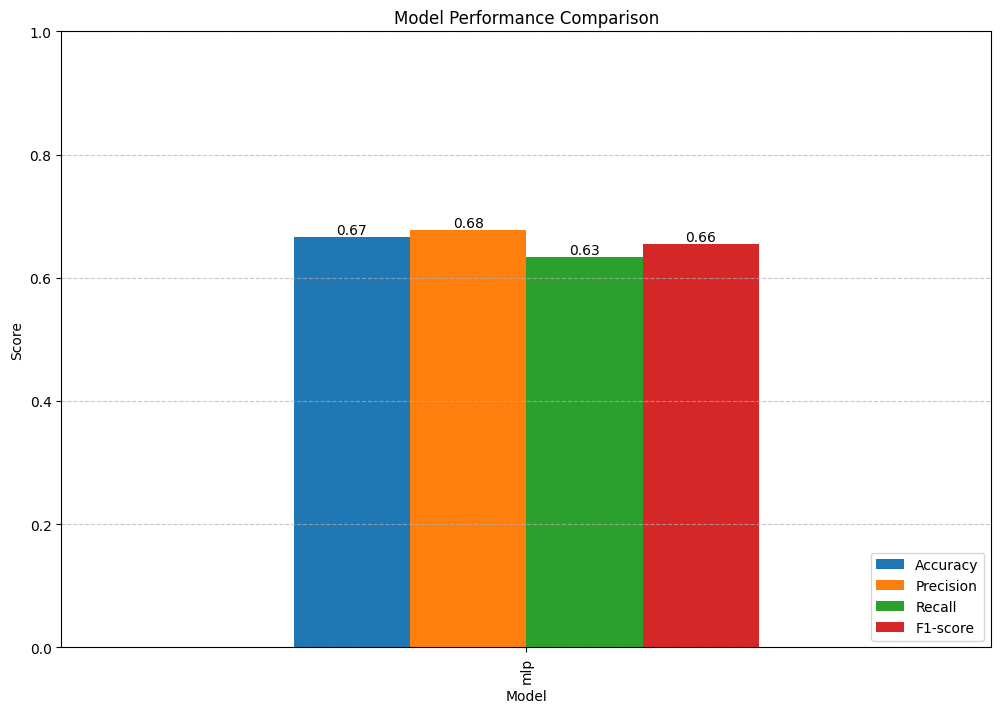

In [69]:
if GRID_SEARCH:
    param_grid = {
    'mlp__hidden_layer_sizes': [(256, 128, 64),(512, 256),(256, 128)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.0001, 0.01, 0.001],
    'mlp__learning_rate_init': [0.001],
    'mlp__batch_size': [64],
    'mlp__max_iter': [200,300],
    'mlp__early_stopping': [True],
    'mlp__validation_fraction': [0.1],
    'mlp__solver': ['adam']}
    
    mlp = MLPClassifier(random_state=27, max_iter=300, learning_rate="adaptive")
    
    optimize_via_grid_search(mlp,"mlp",param_grid,
    y_parameter="age_young_old_encoded")

Starting grid search for rf (predicting age_young_old_encoded)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END rf__criterion=gini, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time= 1.6min
[CV] END rf__criterion=gini, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.6min
[CV] END rf__criterion=gini, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.6min
[CV] END rf__criterion=gini, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.6min
[CV] END rf__criterion=gini, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time= 1.6min
[CV] END rf__criterion=gini, rf__max_depth=None, rf__max_featu

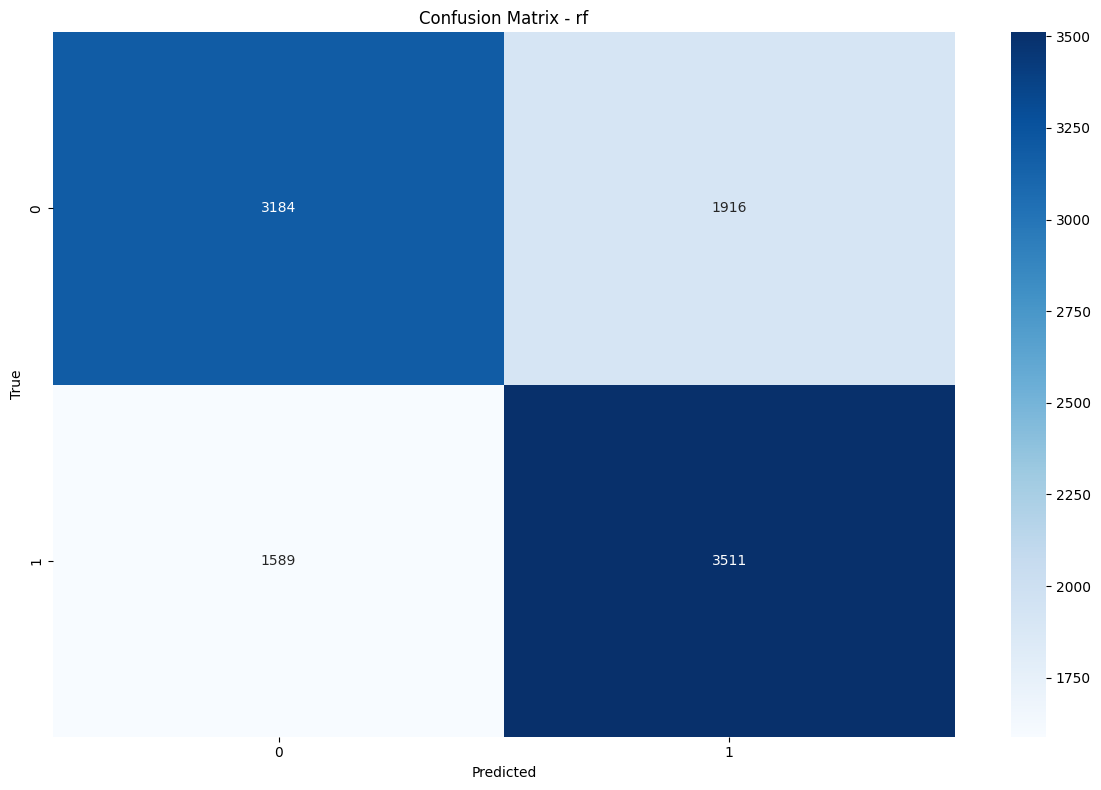

<Figure size 1200x800 with 0 Axes>

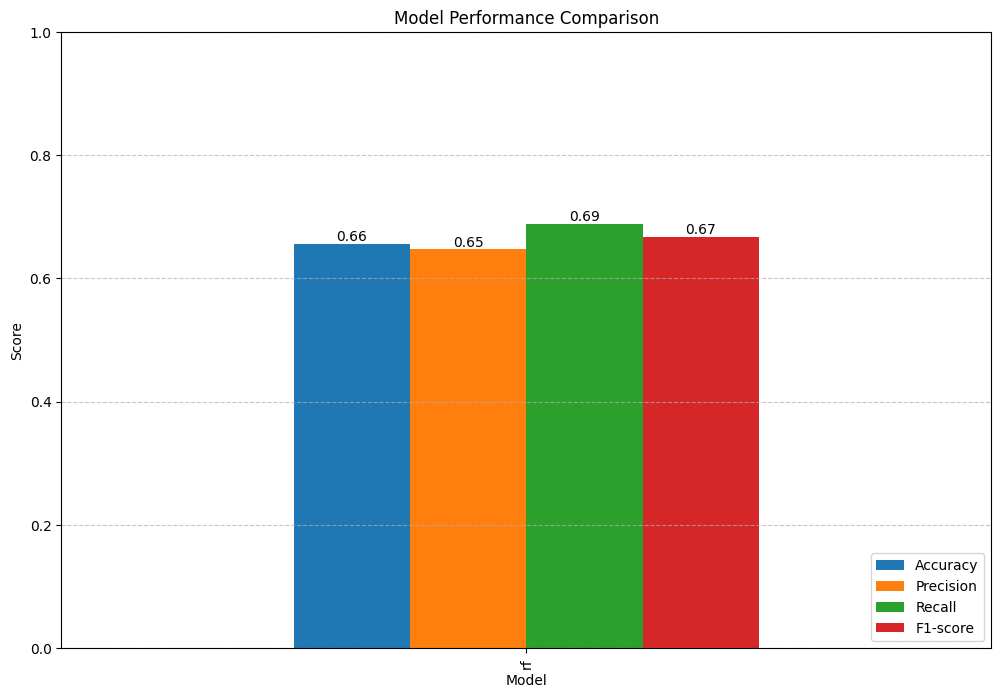

In [71]:
if GRID_SEARCH:
    param_grid = param_grid = {
            'rf__n_estimators': [200, 300],
            'rf__max_depth': [None, 20, 30,],
            'rf__min_samples_split': [2, 5],
            'rf__min_samples_leaf': [1, 2],
            'rf__max_features': ['sqrt'],
            'rf__criterion': ['gini', 'entropy'],
        }

    rf = RandomForestClassifier(random_state=27, n_jobs=-1)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for hgb (predicting age_young_old_encoded)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.05, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=10; total time=   2.4s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.05, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=10; total time=   2.5s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.05, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=30; total time=   2.5s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.05, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=10; total time=   2.5s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.05, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=30; total time=   2.5s
[CV] E

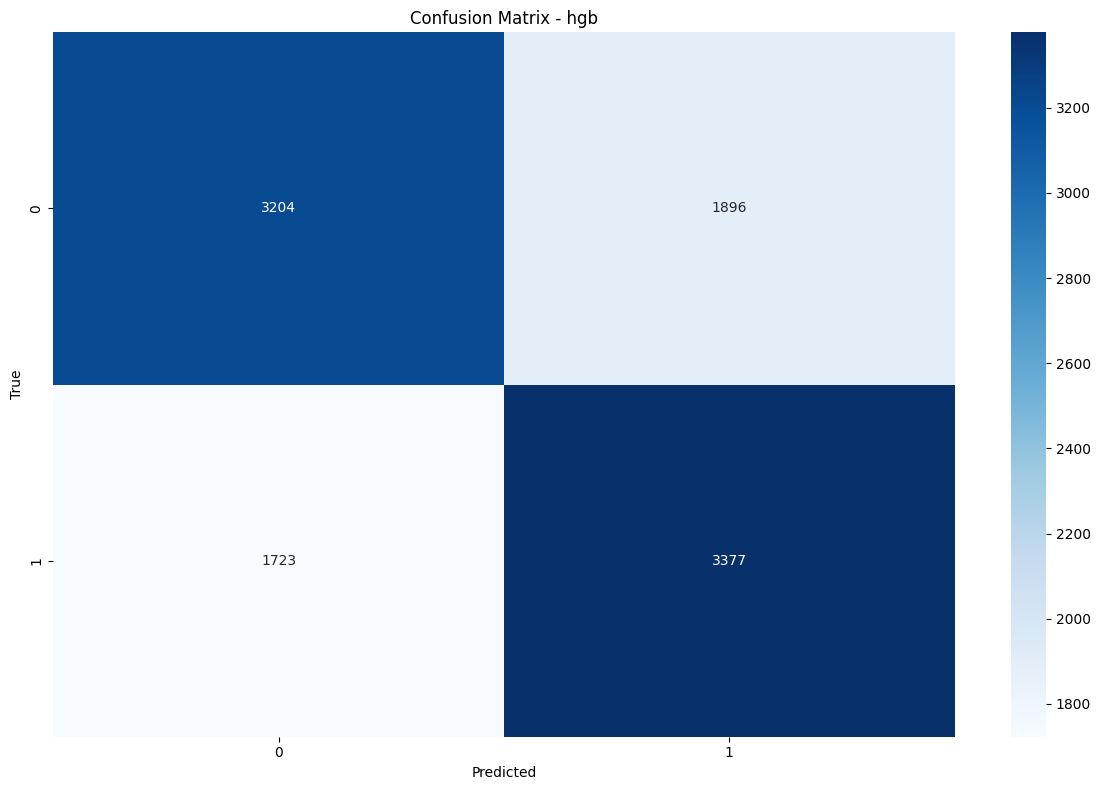

<Figure size 1200x800 with 0 Axes>

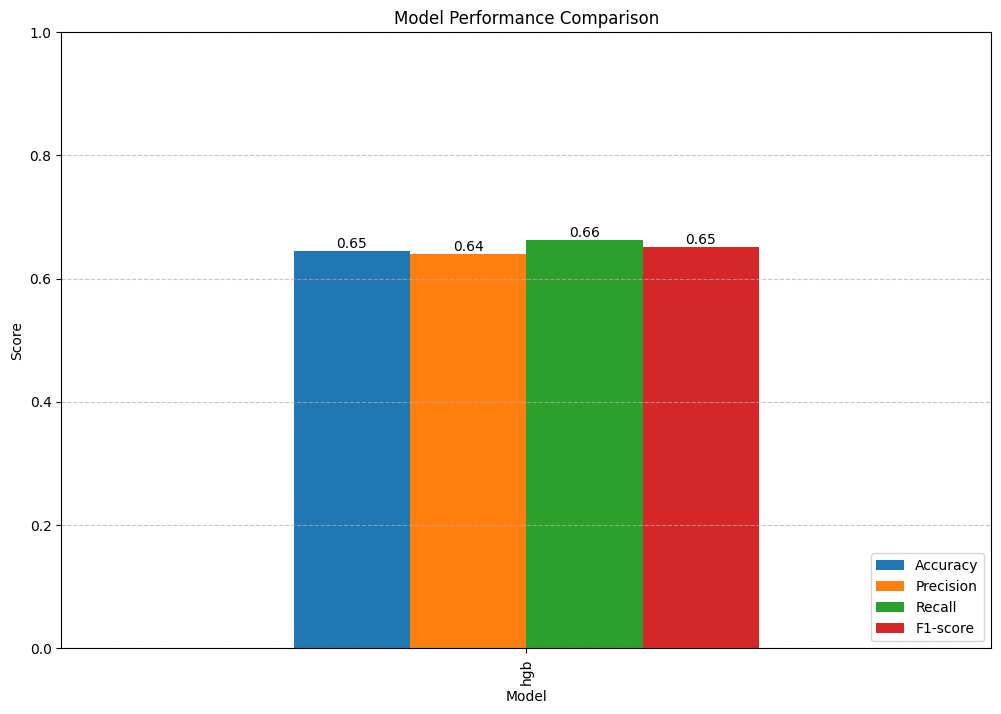

In [72]:
if GRID_SEARCH:
    param_grid = {
        'hgb__learning_rate': [0.05, 0.1, 0.2],
        'hgb__max_iter': [100, 300],
        'hgb__max_depth': [None, 5],
        'hgb__min_samples_leaf': [10, 30,],
        'hgb__l2_regularization': [0.0, 1.0],
        'hgb__early_stopping': [True],
        }

    hgb = HistGradientBoostingClassifier(random_state=27)

    optimize_via_grid_search(
        hgb,
        "hgb",
        param_grid,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for svc (predicting age_young_old_encoded)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.001; total time=   1.2s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.001; total time=   1.3s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=3000, svc__tol=0.001; total time=   1.2s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.001; total time=   1.4s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=3000, svc__tol=0.001; total time=   1.2s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.0001; total time=   1.6s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.0001; total time=   1.6s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.0001; total time=   1.8s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__m

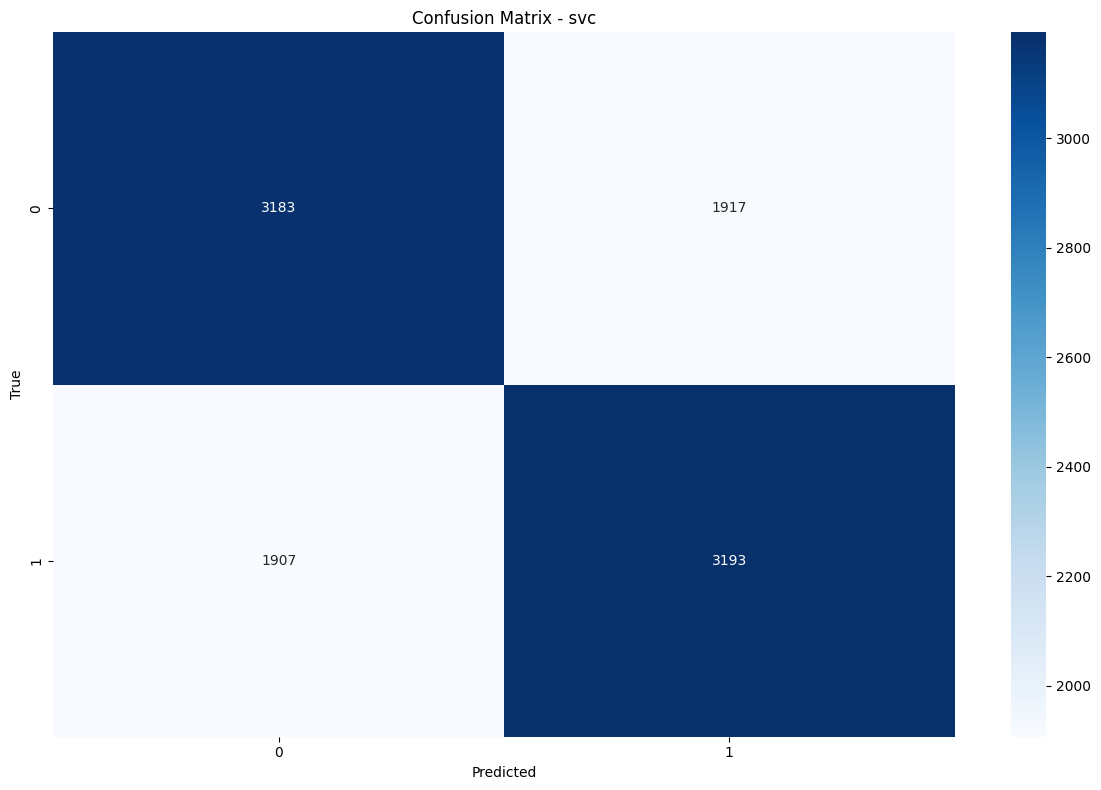

<Figure size 1200x800 with 0 Axes>

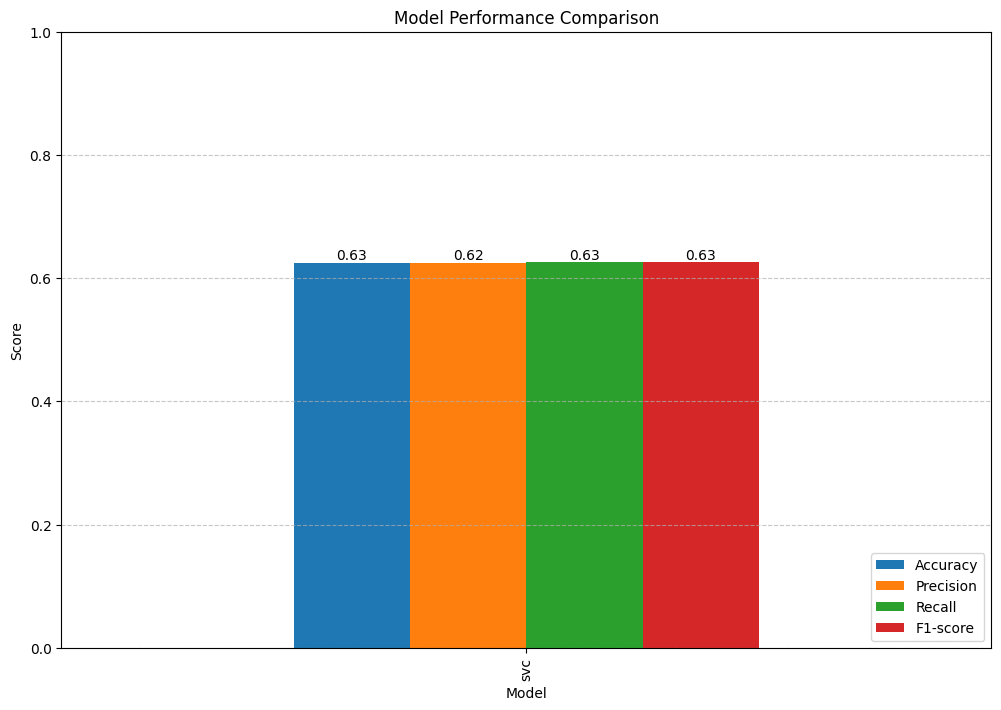

In [81]:
if GRID_SEARCH:
    param_grid = {
        'svc__C': [0.01, 0.1, 1, 10],
        'svc__loss': ['squared_hinge'],
        'svc__max_iter': [1000, 3000, 5000],
        'svc__tol': [0.001, 0.0001]
    }

    svc = LinearSVC(random_state=27, dual=False)

    optimize_via_grid_search(
        svc,
        "svc",
        param_grid,
        y_parameter="age_young_old_encoded"
    )

#### Optimize Models Predicting Gender

Starting grid search for mlp (predicting gender_encoded)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.001, mlp__max_iter=1000, mlp__validation_fraction=0.1; total time=  38.5s
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.001, mlp__max_iter=1000, mlp__validation_fraction=0.1; total time=  46.5s
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256, 128), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.001, mlp__max_iter=3000, mlp__validation_fraction=0.1; total time=  52.1s
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True,

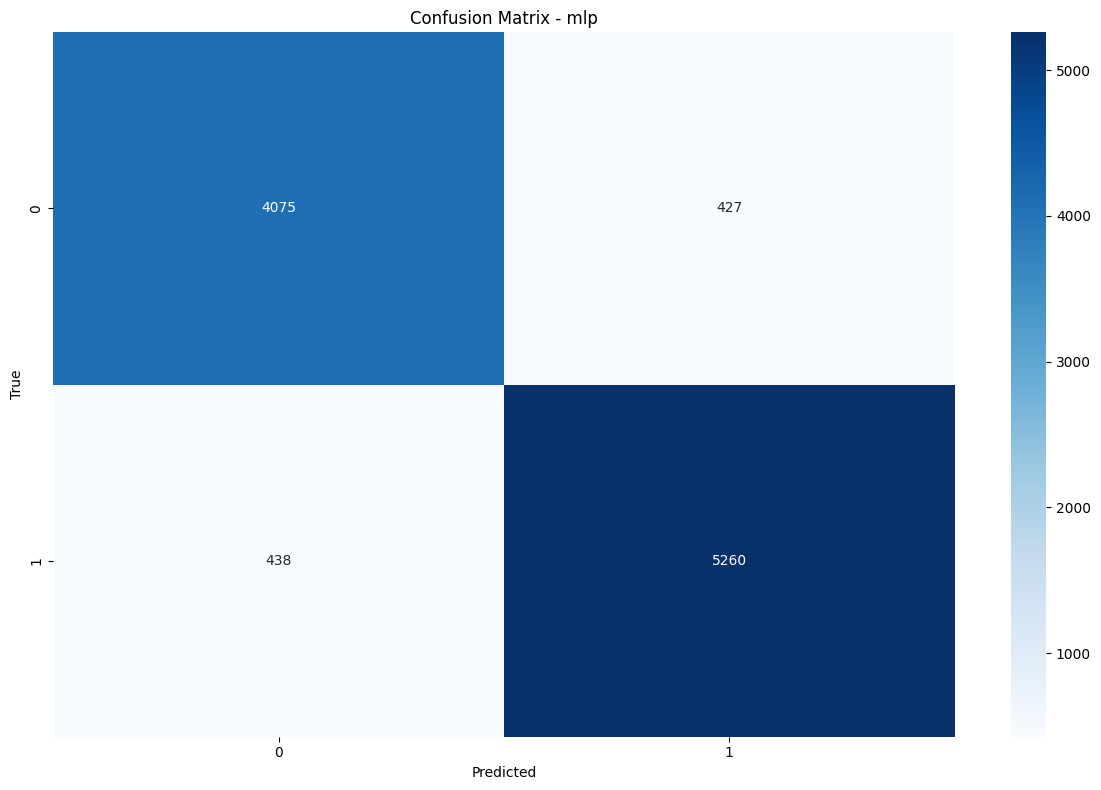

<Figure size 1200x800 with 0 Axes>

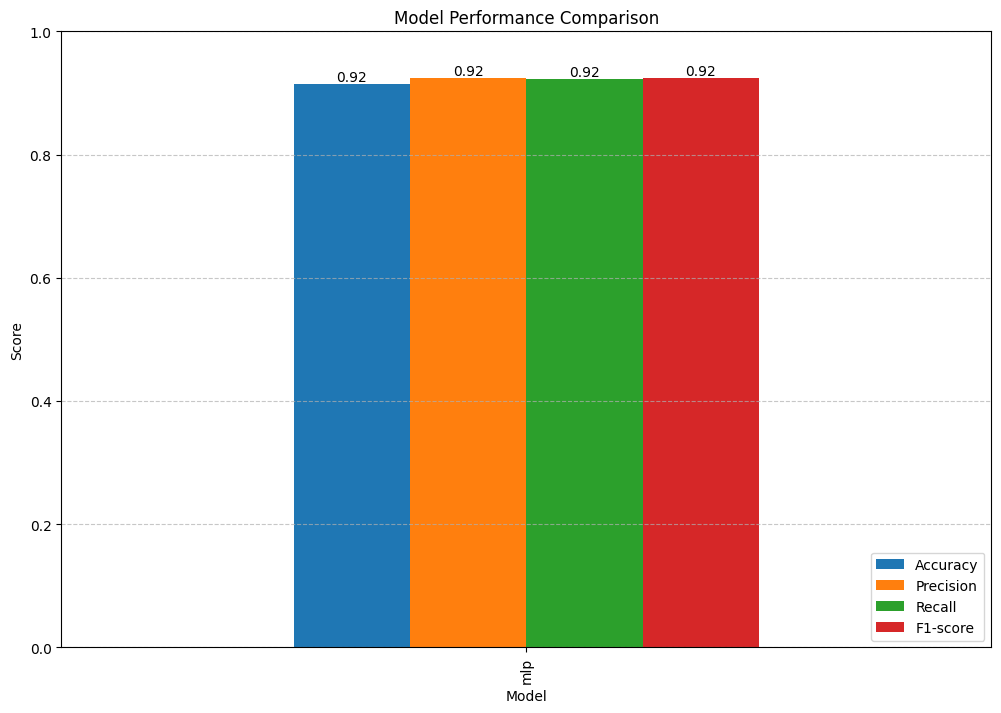

In [74]:
if GRID_SEARCH:
    param_grid = {
        'mlp__hidden_layer_sizes': [(512, 256, 128),(512, 256),(256, 128)],
        'mlp__activation': ['relu'],
        'mlp__alpha': [0.00005, 0.0001, 0.0005],
        'mlp__batch_size': [64],
        'mlp__learning_rate_init': [0.001],
        'mlp__learning_rate': ['adaptive'],
        'mlp__max_iter': [1000, 3000],
        'mlp__early_stopping': [True],
        'mlp__validation_fraction': [0.1]
        }

    mlp = MLPClassifier(random_state=27, max_iter=300)

    optimize_via_grid_search(mlp,"mlp",param_grid,y_parameter="gender_encoded")

Starting grid search for rf (predicting gender_encoded)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  31.1s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  31.2s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  31.4s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.1min
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.1min
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  32.3s
[CV] END rf__max_depth=None

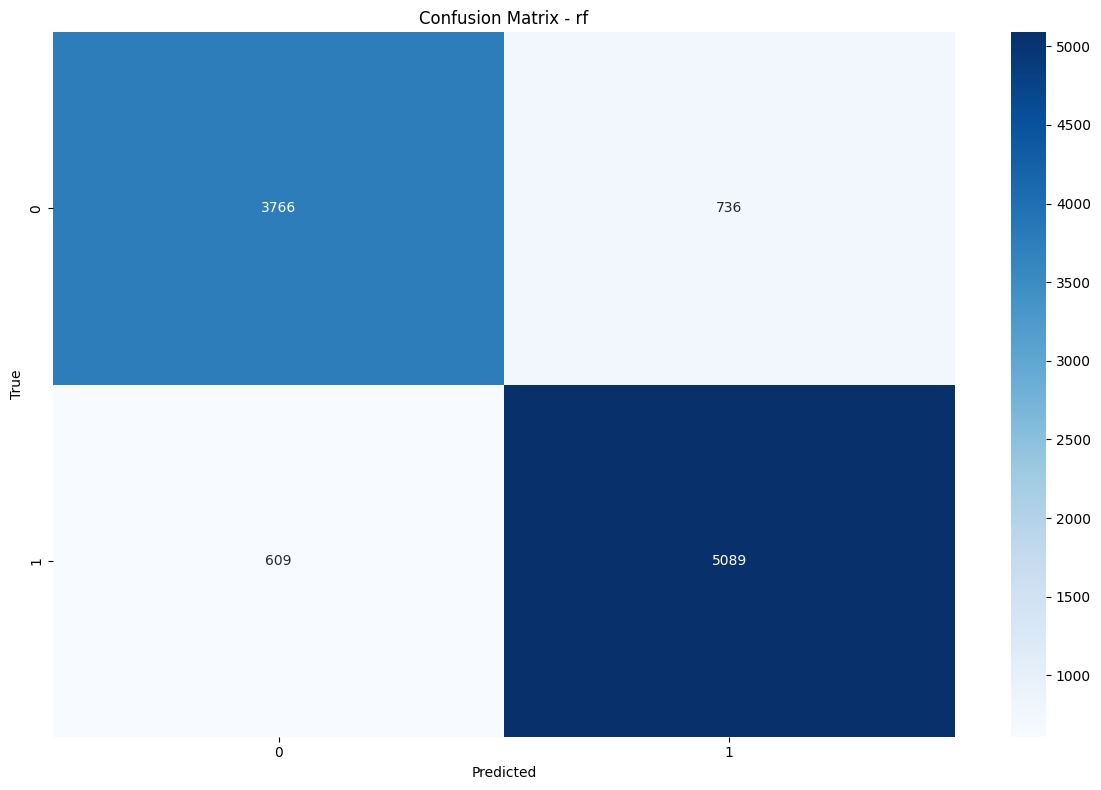

<Figure size 1200x800 with 0 Axes>

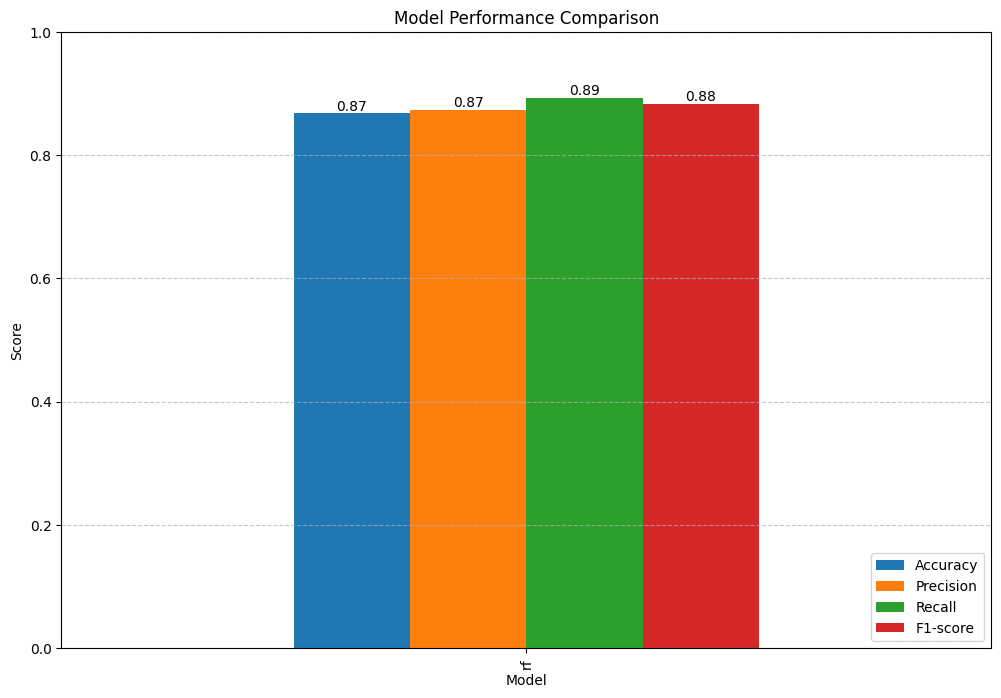

In [ ]:
if GRID_SEARCH:
    param_grid = {
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt'],
    }

    rf = RandomForestClassifier(random_state=27, n_jobs=-1)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        y_parameter="gender_encoded"
    )

#### Optimize Models Predicting Age Segmented By Gender

To truly evaluate the performance of gender prediction across genders, we decide to try to see if there are differences between the two. We do this directly with a grid search to also find the ideal hyperparameter configuration for a gender divided age predictor.

Starting grid search for rf (predicting age_young_old_encoded)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  12.5s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  12.5s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  12.6s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  12.7s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  12.7s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=  24.8s
[CV] END rf__max_dept

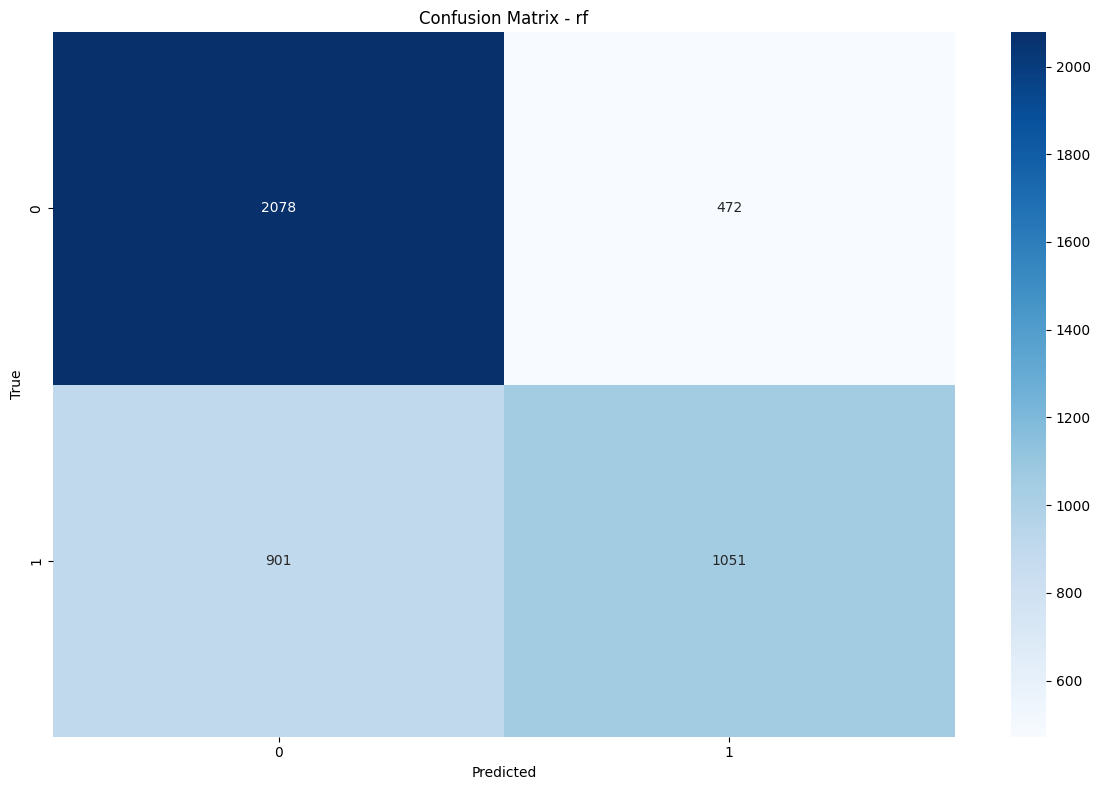

<Figure size 1200x800 with 0 Axes>

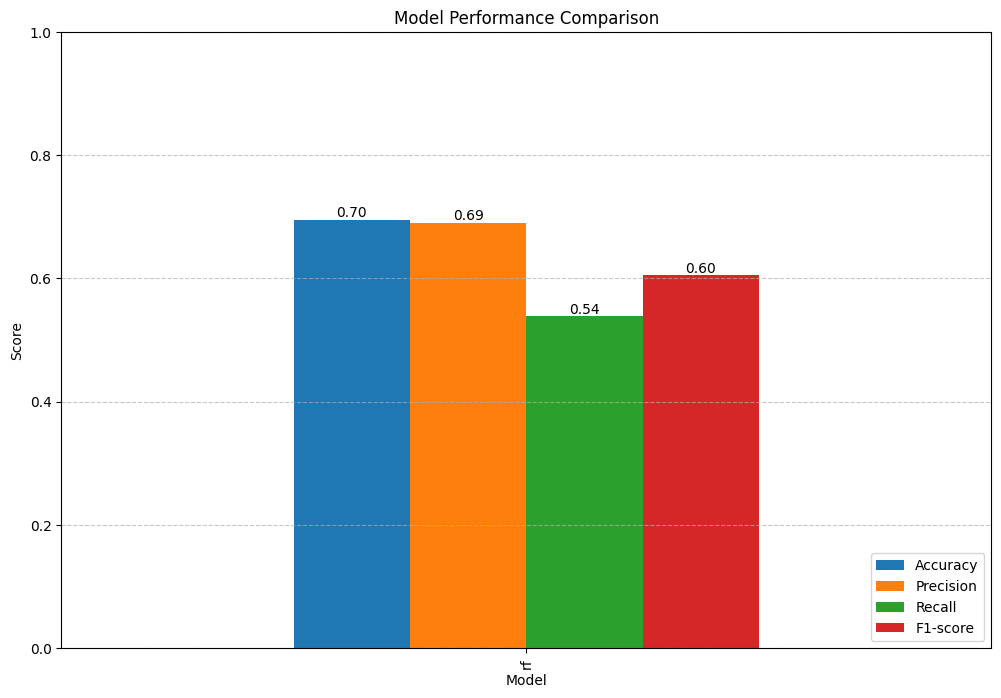

In [77]:
if GRID_SEARCH:
    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt'],
    }

    rf = RandomForestClassifier(random_state=27, n_jobs= -1)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        X_train=X_train_female,
        y_train=y_train_female,
        X_val=X_val_female,
        y_val=y_val_female,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for rf (predicting age_young_old_encoded)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  15.7s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  15.8s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  15.8s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  15.9s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  16.0s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=  31.2s
[CV] END rf__max_dept

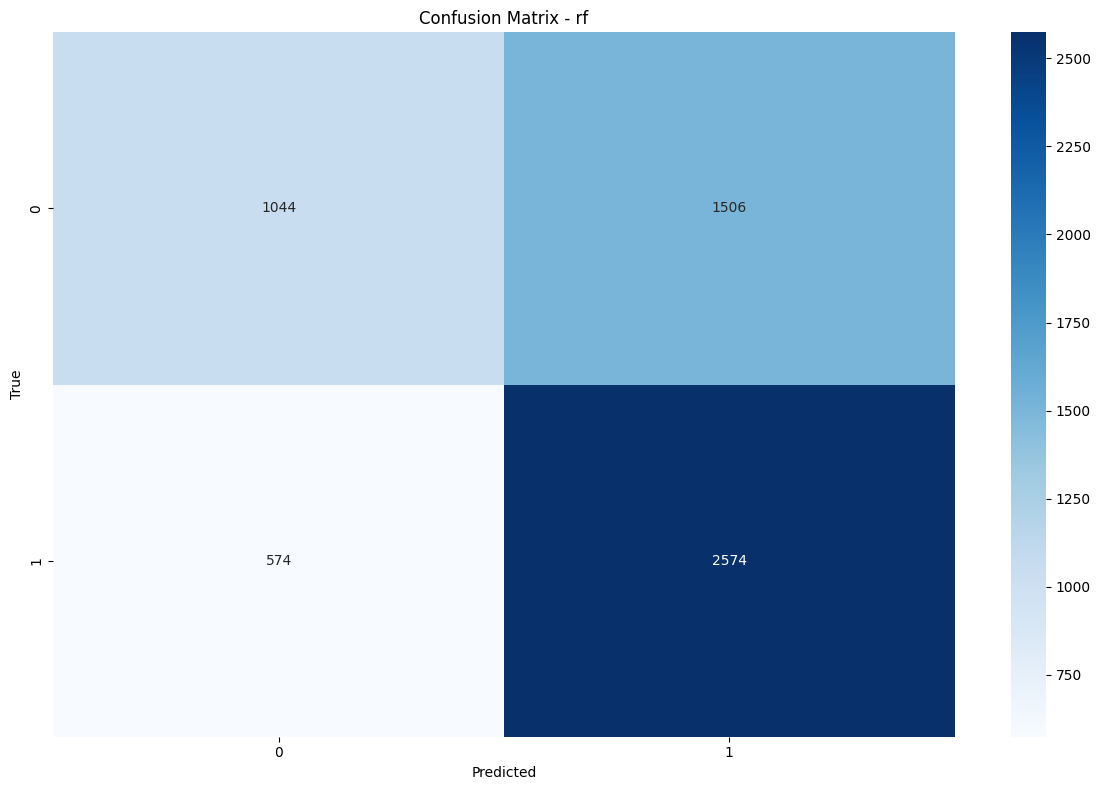

<Figure size 1200x800 with 0 Axes>

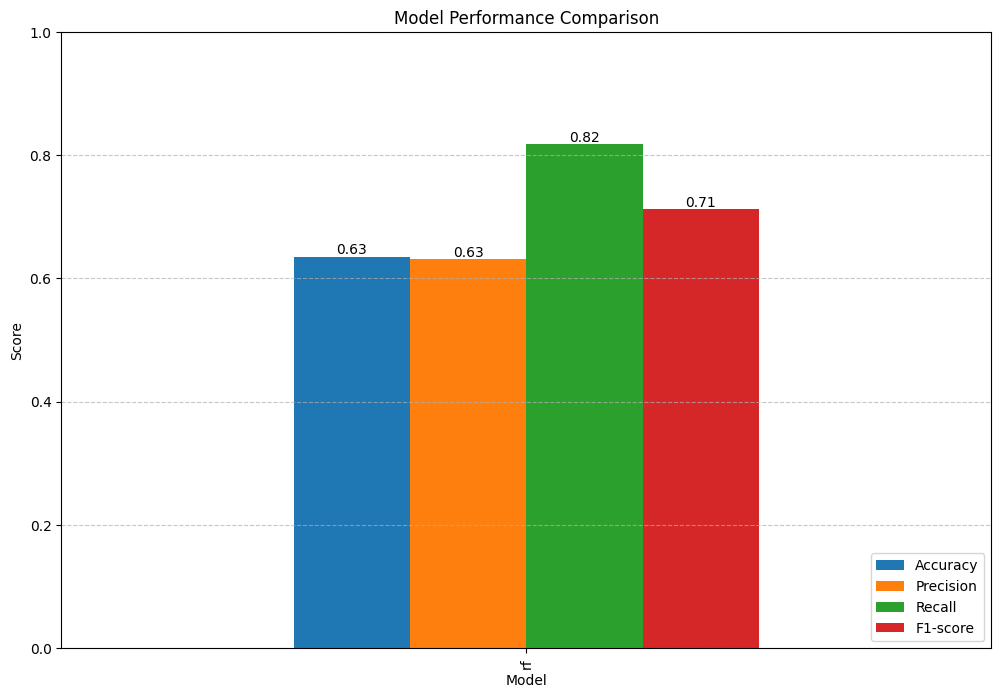

In [78]:
if GRID_SEARCH:
    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt']
    }

    rf = RandomForestClassifier(random_state=27, n_jobs= -1)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        X_train=X_train_male,
        y_train=y_train_male,
        X_val=X_val_male,
        y_val=y_val_male,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for mlp (predicting age_young_old_encoded)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.0005, mlp__max_iter=200, mlp__solver=adam; total time=   4.1s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=   5.3s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=500, mlp__solver=adam; total time=   5.3s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.0005, mlp__max_iter=200, mlp__solver=ad

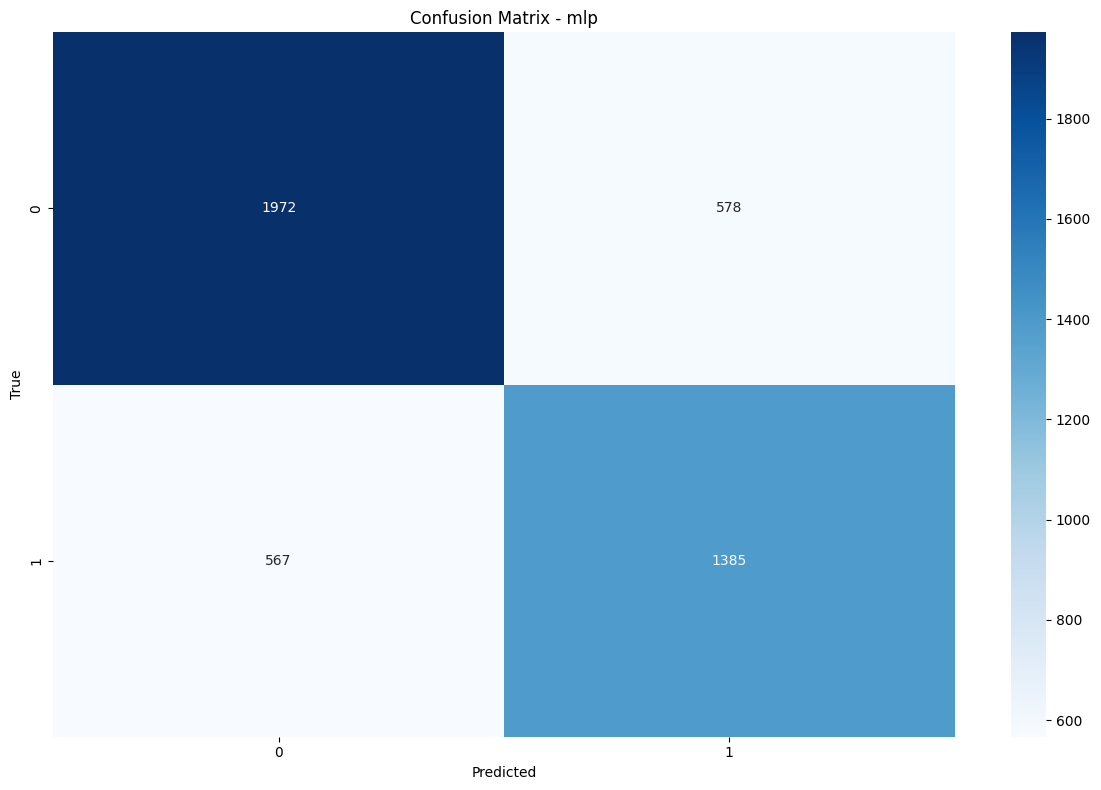

<Figure size 1200x800 with 0 Axes>

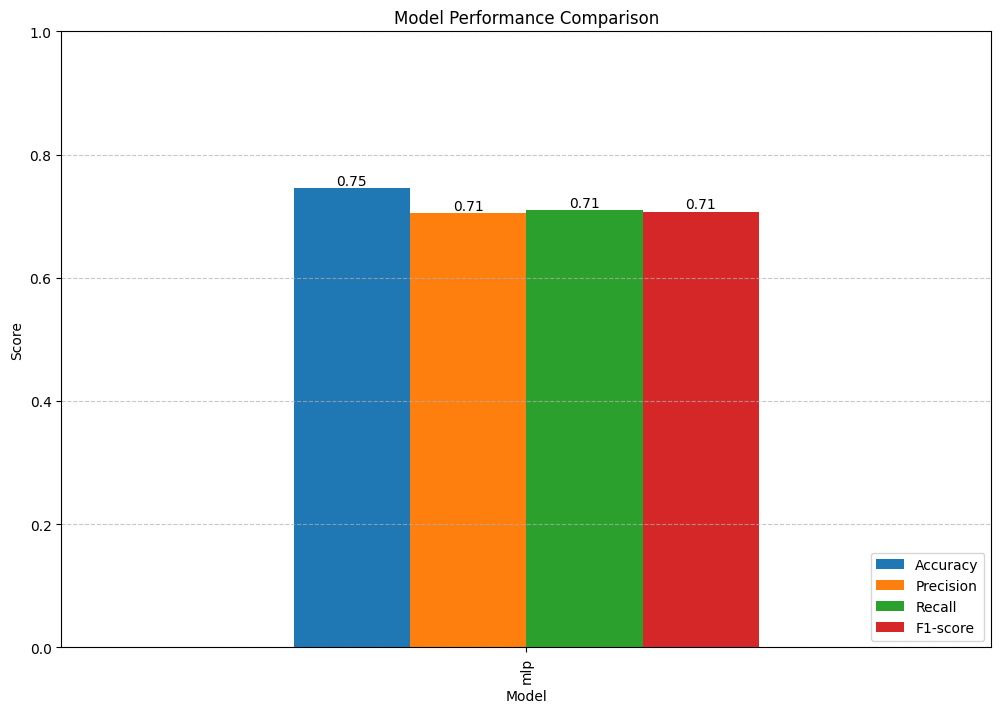

In [100]:
if GRID_SEARCH:    
    param_grid = {
    'mlp__hidden_layer_sizes': [(256, 128, 64),(512, 256),(256, 128)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.0005],
    'mlp__batch_size': [64],
    'mlp__max_iter': [200, 500],
    'mlp__early_stopping': [True],
    'mlp__solver': ['adam']}
    
    mlp = MLPClassifier(random_state=27)
    
    optimize_via_grid_search(mlp,"mlp",param_grid,X_train=X_train_female,
        y_train=y_train_female,
        X_val=X_val_female,
        y_val=y_val_female,y_parameter="age_young_old_encoded")
    

Starting grid search for mlp (predicting age_young_old_encoded)...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  13.2s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256), mlp__learning_rate_init=0.0005, mlp__max_iter=200, mlp__solver=adam; total time=  17.7s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256), mlp__learning_rate_init=0.0005, mlp__max_iter=300, mlp__solver=adam; total time=  17.7s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  21.

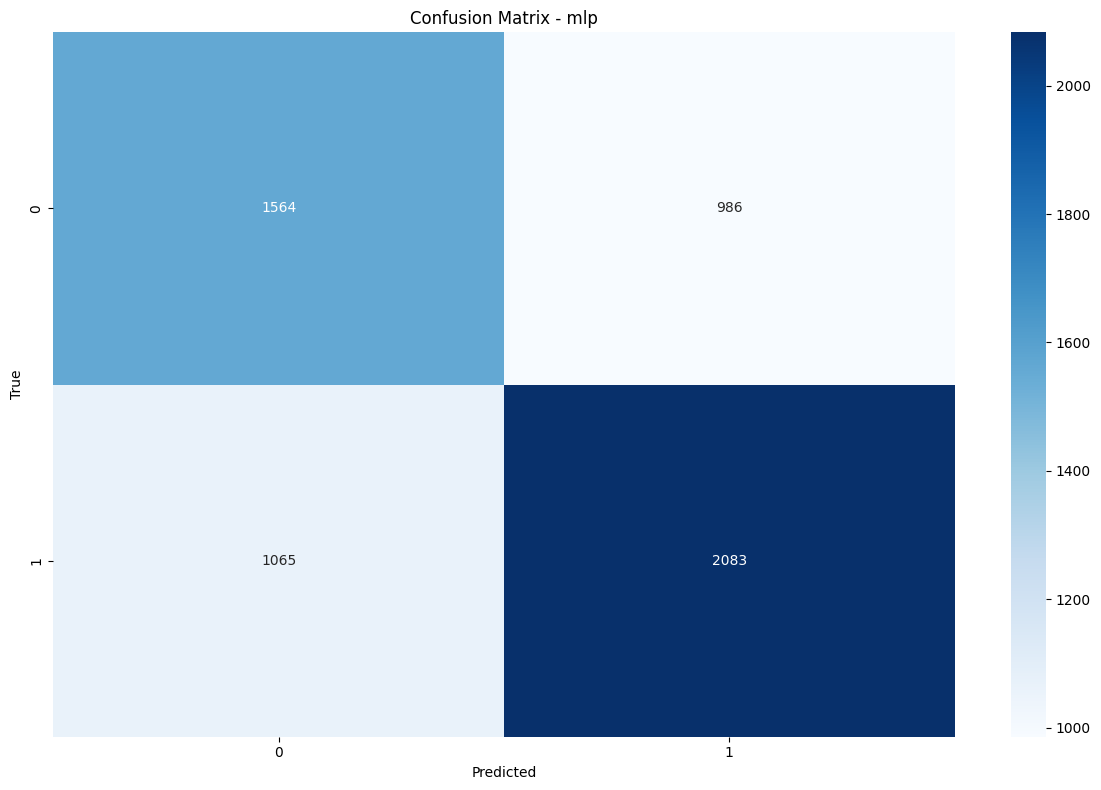

<Figure size 1200x800 with 0 Axes>

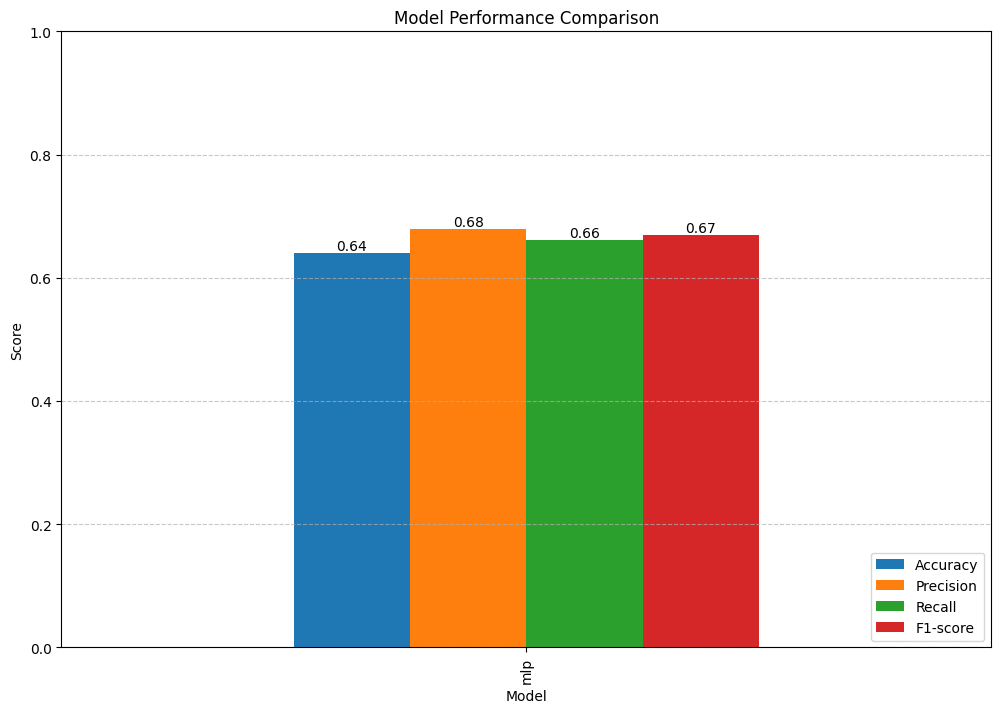

In [ ]:
if GRID_SEARCH:
    param_grid = {
    'mlp__hidden_layer_sizes': [
        (512, 256), (512, 256, 128),
        (256, 128), (256, 128, 64)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.005, 0.01, 0.02],
    'mlp__learning_rate_init': [0.0005, 0.001, 0.002],
    'mlp__batch_size': [64],
    'mlp__max_iter': [200, 300],
    'mlp__early_stopping': [True],
    'mlp__solver': ['adam']
}
    
    mlp = MLPClassifier(random_state=27)
    
    optimize_via_grid_search(mlp,"mlp",param_grid,
        X_train=X_train_male,
        y_train=y_train_male,
        X_val=X_val_male,
        y_val=y_val_male,y_parameter="age_young_old_encoded")

As we can see, age predictors consistently predict better on female data compared to male data. There seems to be a clear performance boost, however the model classes themselves seem to be similarly suited for either gender, with no model predicting the one gender disproportionately better. In summary, gender clearly impacts the performance of age recognition and seems to be much stronger among our female data. With the rest of this notebook, we will try to built more advanced task segmentation or feature enrichment models that predict age in two steps.

## Task Segmented Models

In [94]:
def evaluate_layered_model(predicted_age_comp, y_comp_age, y_comp_gender, age_model_name, label=None, binning=None, encoded=False, expanded=True):
    # Decode gender labels if encoded
    if encoded:
        y_comp_gender = y_comp_gender.map({0: 'female_feminine', 1: 'male_masculine'})

    if expanded:
        metrics = {
            'Model': [],
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-score': []
        }

    for gender in ['female_feminine', 'male_masculine', 'total']:
        if gender == 'total':
            gender_mask = y_comp_gender.notnull()
        else:
            gender_mask = y_comp_gender == gender

        if binning:
            y_true_age = apply_binning(y_comp_age[gender_mask], binning)
            y_pred_age = apply_binning(
                [predicted_age_comp[i] for i in range(len(predicted_age_comp)) if gender_mask.iloc[i]],
                binning
            )
        else:
            y_true_age = y_comp_age[gender_mask]
            y_pred_age = [predicted_age_comp[i] for i in range(len(predicted_age_comp)) if gender_mask.iloc[i]]

        print(f"\n{age_model_name} - Prediction Report on Gender {gender}: {label}")
        print(classification_report(y_true_age, y_pred_age))

        if expanded:
            # Store metrics
            metrics['Model'].append(f'{age_model_name} - {gender}')
            metrics['Accuracy'].append(accuracy_score(y_true_age, y_pred_age))
            metrics['Precision'].append(precision_score(y_true_age, y_pred_age, average='weighted'))
            metrics['Recall'].append(recall_score(y_true_age, y_pred_age, average='weighted'))
            metrics['F1-score'].append(f1_score(y_true_age, y_pred_age, average='weighted'))

            # Plot confusion matrix
            cm_age_gender = confusion_matrix(y_true_age, y_pred_age)
            labels = sorted(set(y_true_age).union(set(y_pred_age)))
            sns.heatmap(cm_age_gender, annot=True, fmt='d', cmap='Blues',
                        xticklabels=labels, yticklabels=labels)
            plt.title(f'Confusion Matrix {age_model_name} - Prediction on Gender {gender}: {label}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

    if expanded:
        # Plot metrics comparison
        plt.figure(figsize=(12, 8))
        metrics_df = pd.DataFrame(metrics)
        metrics_df_plot = metrics_df.set_index('Model')
        ax = metrics_df_plot.plot(kind='bar', figsize=(12, 8))
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
        plt.show()
        return pd.DataFrame(metrics)


In [95]:
def fit_predict_two_stage_gender_age_pipeline(
    gender_model_class,
    age_model_class_female,
    age_model_class_male,
    gender_model_name="GenderModel",
    age_model_name="AgeModel",
    X_train=X_train_clean, y_train_age=y_train_clean["age_young_old"], y_train_gender=y_train_clean["gender"],
    X_comp=X_val, y_comp_age=y_val["age_young_old"], y_comp_gender=y_val["gender"], 
    binning=None, return_pipeline=False, gender_encoded=False):
    
    encoded=gender_encoded
    # Determine gender labels based on encoding
    male_label = 1 if encoded else 'male_masculine'
    female_label = 0 if encoded else 'female_feminine'
    
    # ====== Fit gender model ======
    pipe_gender = make_pipeline(clone(preprocessing), clone(gender_model_class))
    print(f"\nFitting {gender_model_name} on training set")
    pipe_gender.fit(X_train, y_train_gender)

    print(f"\nPredicting {gender_model_name} on training set")
    predicted_gender_train = pipe_gender.predict(X_train)
    print(f"\nPredicting {gender_model_name} on comparison set")
    predicted_gender_comp = pipe_gender.predict(X_comp)

    for split_name, preds, y in [('Training', predicted_gender_train, y_train_gender), ('Comparison', predicted_gender_comp, y_comp_gender)]:
        if encoded:
            preds = np.where(preds == 1, 'male_masculine', 'female_feminine')
            y = np.where(y == 1, 'male_masculine', 'female_feminine')

        print(f"\n{gender_model_name} Gender Model - {split_name} Set:")
        print(classification_report(y, preds))

        if split_name == 'Comparison':
            cm = confusion_matrix(y, preds)
            labels = sorted(set(y).union(set(preds)))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
            plt.title(f'Confusion Matrix - Gender ({gender_model_name}, {split_name} Set)')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

    # ====== Train age models ======
    X_train_male = X_train[y_train_gender == male_label]
    y_train_male = y_train_age[y_train_gender == male_label]
    X_train_female = X_train[y_train_gender == female_label]
    y_train_female = y_train_age[y_train_gender == female_label]

    X_comp_male = X_comp[y_comp_gender == male_label]
    X_comp_female = X_comp[y_comp_gender == female_label]

    pipe_age_male = make_pipeline(clone(preprocessing), clone(age_model_class_male))
    pipe_age_female = make_pipeline(clone(preprocessing), clone(age_model_class_female))

    print(f"\nFitting {age_model_name} on Gender Female")
    pipe_age_female.fit(X_train_female, y_train_female)

    print(f"\nFitting {age_model_name} on Gender Male")
    pipe_age_male.fit(X_train_male, y_train_male)

    # Predict on training set with perfect routing
    print(f"\nPredicting {age_model_name} on training set")
    predicted_age_train_male = pipe_age_male.predict(X_train_male)
    predicted_age_train_female = pipe_age_female.predict(X_train_female)

    idx_train_male = np.where(y_train_gender == male_label)[0]
    idx_train_female = np.where(y_train_gender == female_label)[0]

    predicted_age_train = np.empty_like(y_train_age, dtype=predicted_age_train_male.dtype)
    predicted_age_train[idx_train_male] = predicted_age_train_male
    predicted_age_train[idx_train_female] = predicted_age_train_female

    # ====== Perfect Routing (using true gender) ======
    print(f"\nPredicting {age_model_name} on comparison set with perfect routing")

    idx_comp_true_male = np.where(y_comp_gender == male_label)[0]
    idx_comp_true_female = np.where(y_comp_gender == female_label)[0]

    X_comp_true_male = X_comp.iloc[idx_comp_true_male]
    X_comp_true_female = X_comp.iloc[idx_comp_true_female]

    predicted_age_comp_true_male = pipe_age_male.predict(X_comp_true_male)
    predicted_age_comp_true_female = pipe_age_female.predict(X_comp_true_female)

    predicted_age_true_gender = np.empty_like(y_comp_age, dtype=predicted_age_comp_true_male.dtype)
    predicted_age_true_gender[idx_comp_true_male] = predicted_age_comp_true_male
    predicted_age_true_gender[idx_comp_true_female] = predicted_age_comp_true_female

    # ====== Predicted Routing ======
    X_comp_suspected_male = X_comp[predicted_gender_comp == male_label]
    X_comp_suspected_female = X_comp[predicted_gender_comp == female_label]
    idx_comp_male = np.where(predicted_gender_comp == male_label)[0]
    idx_comp_female = np.where(predicted_gender_comp == female_label)[0]

    print(f"\nPredicting {age_model_name} on comparison set with predicted routing")
    predicted_age_comp_male = pipe_age_male.predict(X_comp_suspected_male)
    predicted_age_comp_female = pipe_age_female.predict(X_comp_suspected_female)

    predicted_age_pred_gender = np.empty_like(y_comp_age, dtype=predicted_age_comp_male.dtype)
    predicted_age_pred_gender[idx_comp_male] = predicted_age_comp_male
    predicted_age_pred_gender[idx_comp_female] = predicted_age_comp_female

    # ====== Evaluation ======
    print(f"\nEvaluating {age_model_name} on training set")
    evaluate_layered_model(predicted_age_train, y_train_age, y_train_gender, age_model_name, "Training Data", binning=binning, encoded=encoded,expanded=False)

    print(f"\nEvaluating {age_model_name} on comparison set")
    evaluate_layered_model(predicted_age_true_gender, y_comp_age, y_comp_gender, age_model_name, "Routed by True Gender", binning=binning,encoded=encoded, expanded=False)
    metrics = evaluate_layered_model(predicted_age_pred_gender, y_comp_age, y_comp_gender, age_model_name, "Routed by Predicted Gender", encoded=encoded,binning=binning)

    # ====== Routing error cost ======
    acc_true = accuracy_score(y_comp_age, predicted_age_true_gender)
    acc_pred = accuracy_score(y_comp_age, predicted_age_pred_gender)
    routing_cost = acc_true - acc_pred
    print(f"\n Accuracy True Gender Routing: {acc_true:.4f}")
    print(f"\n Accuracy Predicted Gender Routing: {acc_pred:.4f}")
    print(f"\n Routing Error Cost (Accuracy Loss from using predicted gender): {routing_cost:.4f}")

    if return_pipeline:
        return pipe_gender, pipe_age_female, pipe_age_male
    else:
        return metrics



Fitting MLPClassifier for Gender on training set

Predicting MLPClassifier for Gender on training set

Predicting MLPClassifier for Gender on comparison set

MLPClassifier for Gender Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.94      0.95      0.95     16517
 male_masculine       0.96      0.96      0.96     21238

       accuracy                           0.95     37755
      macro avg       0.95      0.95      0.95     37755
   weighted avg       0.95      0.95      0.95     37755


MLPClassifier for Gender Gender Model - Comparison Set:
                 precision    recall  f1-score   support

female_feminine       0.90      0.91      0.90      4502
 male_masculine       0.92      0.92      0.92      5698

       accuracy                           0.92     10200
      macro avg       0.91      0.91      0.91     10200
   weighted avg       0.92      0.92      0.92     10200



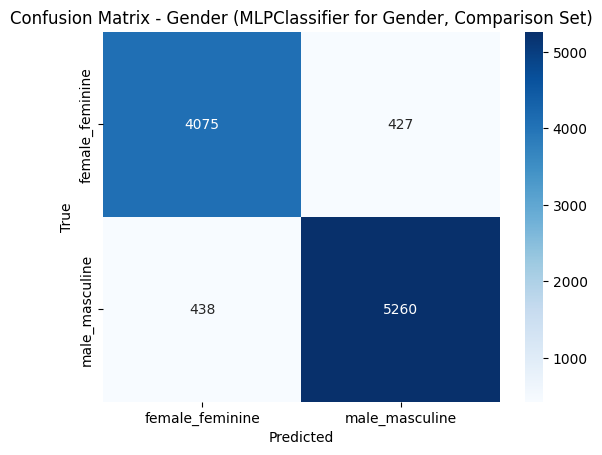


Fitting MLP for Age on Gender Female

Fitting MLP for Age on Gender Male

Predicting MLP for Age on training set

Predicting MLP for Age on comparison set with perfect routing

Predicting MLP for Age on comparison set with predicted routing

Evaluating MLP for Age on training set

MLP for Age - Prediction Report on Gender female_feminine: Training Data
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9365
           1       0.97      0.97      0.97      7152

    accuracy                           0.98     16517
   macro avg       0.98      0.98      0.98     16517
weighted avg       0.98      0.98      0.98     16517


MLP for Age - Prediction Report on Gender male_masculine: Training Data
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      9540
           1       0.86      0.86      0.86     11698

    accuracy                           0.84     21238
   macro avg       0.84   

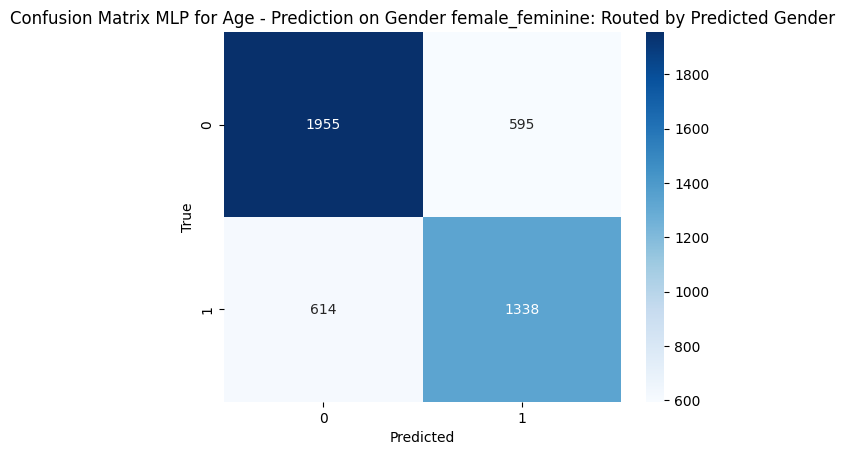


MLP for Age - Prediction Report on Gender male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      2550
           1       0.67      0.67      0.67      3148

    accuracy                           0.63      5698
   macro avg       0.63      0.63      0.63      5698
weighted avg       0.63      0.63      0.63      5698



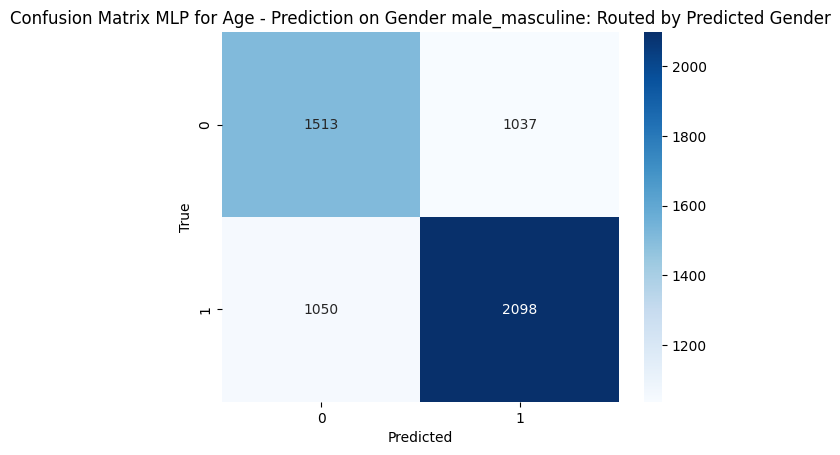


MLP for Age - Prediction Report on Gender total: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      5100
           1       0.68      0.67      0.68      5100

    accuracy                           0.68     10200
   macro avg       0.68      0.68      0.68     10200
weighted avg       0.68      0.68      0.68     10200



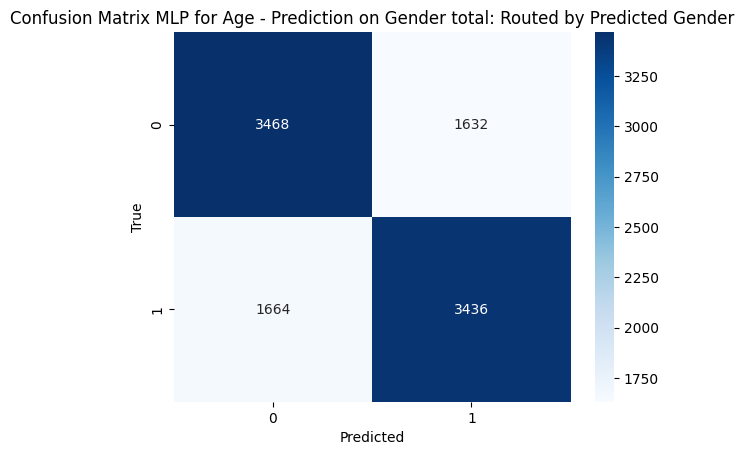

<Figure size 1200x800 with 0 Axes>

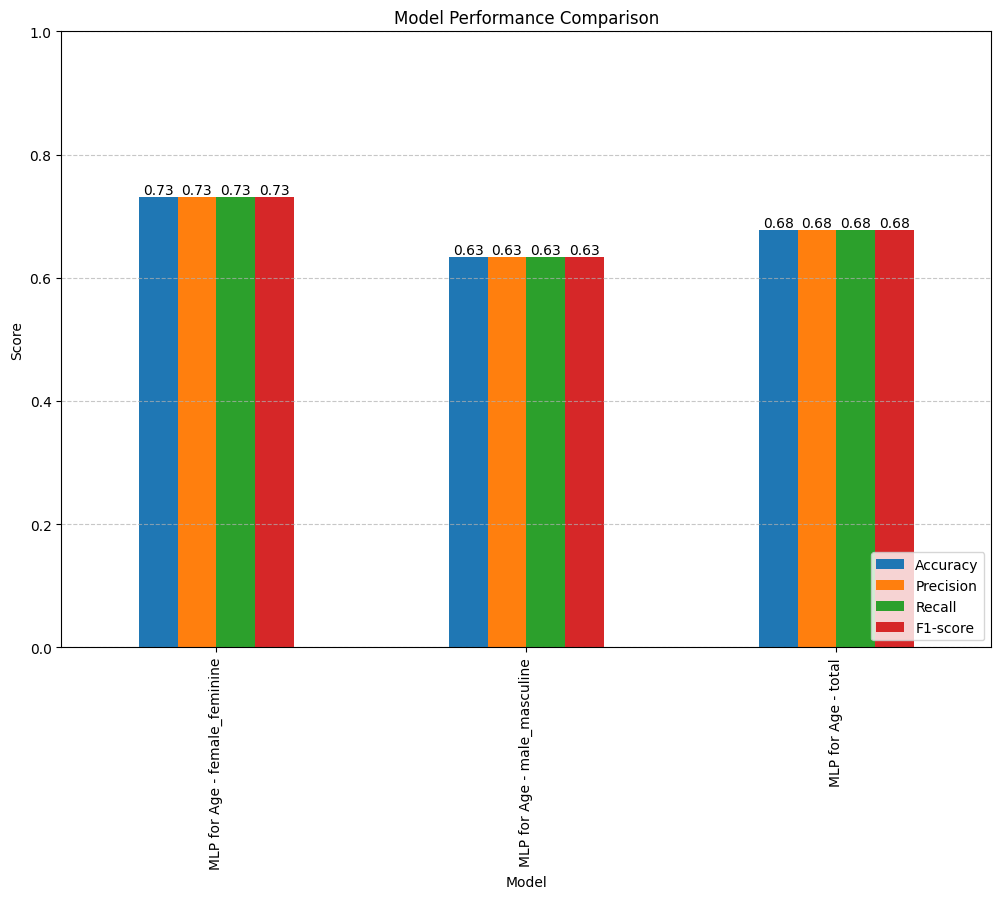


 Accuracy True Gender Routing: 0.6867

 Accuracy Predicted Gender Routing: 0.6769

 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0098


,Model,Accuracy,Precision,Recall,F1-score
0,MLP for Age - female_feminine,0.731453,0.731162,0.731453,0.731294
1,MLP for Age - male_masculine,0.633731,0.633911,0.633731,0.633818
2,MLP for Age - total,0.676863,0.676870,0.676863,0.676860


In [96]:
# MLP Gender + MLP Age Female + MLP Age Male

# Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.0005, 'mlp__batch_size': 64, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (512, 256), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 1000, 'mlp__validation_fraction': 0.1}
# Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__batch_size': 64, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (512, 256), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 200, 'mlp__solver': 'adam'}
# {'mlp__activation': 'relu', 'mlp__alpha': 0.02, 'mlp__batch_size': 64, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (512, 256), 'mlp__learning_rate_init': 0.0005, 'mlp__max_iter': 200, 'mlp__solver': 'adam'}



fit_predict_two_stage_gender_age_pipeline(
    MLPClassifier(hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=1000,
                activation="relu",
                random_state=27,
                learning_rate='adaptive',
                alpha=0.0005,
                early_stopping=True,
                validation_fraction = 0.1),

    MLPClassifier(hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=200,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.001,
              early_stopping=True,
              validation_fraction = 0.1,
              solver = 'adam'),

    MLPClassifier(hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.0005,
                max_iter=200,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.02,
              early_stopping=True,
              validation_fraction = 0.1,
              solver = 'adam'),
              
    "MLPClassifier for Gender",
    "MLP for Age",
    y_train_age=y_train_clean["age_young_old_encoded"],
    y_train_gender=y_train_clean["gender_encoded"],
    y_comp_age = y_val["age_young_old_encoded"],
    y_comp_gender = y_val["gender_encoded"], gender_encoded=True

    )



Fitting MLPClassifier for Gender on training set

Predicting MLPClassifier for Gender on training set

Predicting MLPClassifier for Gender on comparison set

MLPClassifier for Gender Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.94      0.95      0.95     16517
 male_masculine       0.96      0.96      0.96     21238

       accuracy                           0.95     37755
      macro avg       0.95      0.95      0.95     37755
   weighted avg       0.95      0.95      0.95     37755


MLPClassifier for Gender Gender Model - Comparison Set:
                 precision    recall  f1-score   support

female_feminine       0.90      0.91      0.90      4502
 male_masculine       0.92      0.92      0.92      5698

       accuracy                           0.92     10200
      macro avg       0.91      0.91      0.91     10200
   weighted avg       0.92      0.92      0.92     10200



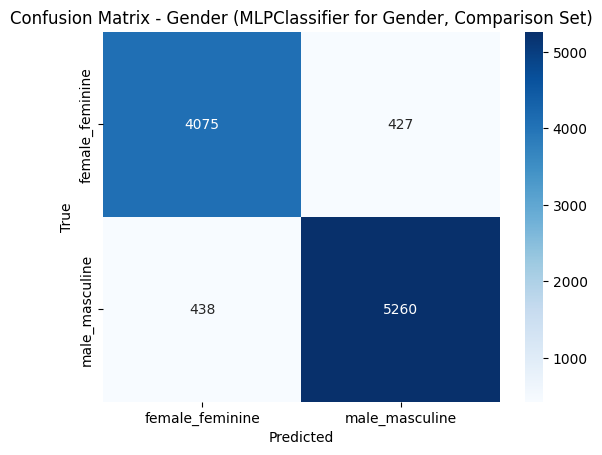


Fitting MLP for Fem Age, RF for Male Age on Gender Female

Fitting MLP for Fem Age, RF for Male Age on Gender Male

Predicting MLP for Fem Age, RF for Male Age on training set

Predicting MLP for Fem Age, RF for Male Age on comparison set with perfect routing

Predicting MLP for Fem Age, RF for Male Age on comparison set with predicted routing

Evaluating MLP for Fem Age, RF for Male Age on training set

MLP for Fem Age, RF for Male Age - Prediction Report on Gender female_feminine: Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9365
           1       1.00      1.00      1.00      7152

    accuracy                           1.00     16517
   macro avg       1.00      1.00      1.00     16517
weighted avg       1.00      1.00      1.00     16517


MLP for Fem Age, RF for Male Age - Prediction Report on Gender male_masculine: Training Data
              precision    recall  f1-score   support

           0       1.

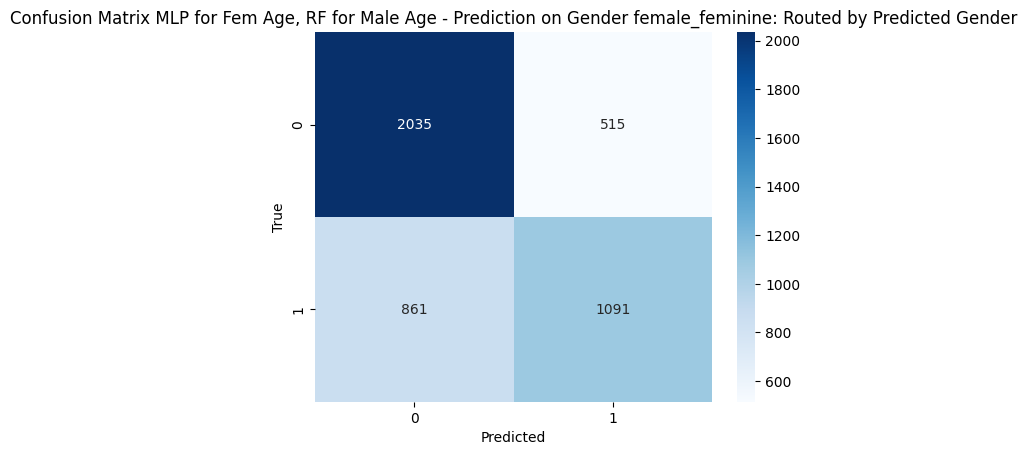


MLP for Fem Age, RF for Male Age - Prediction Report on Gender male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.64      0.41      0.50      2550
           1       0.63      0.81      0.71      3148

    accuracy                           0.63      5698
   macro avg       0.63      0.61      0.60      5698
weighted avg       0.63      0.63      0.62      5698



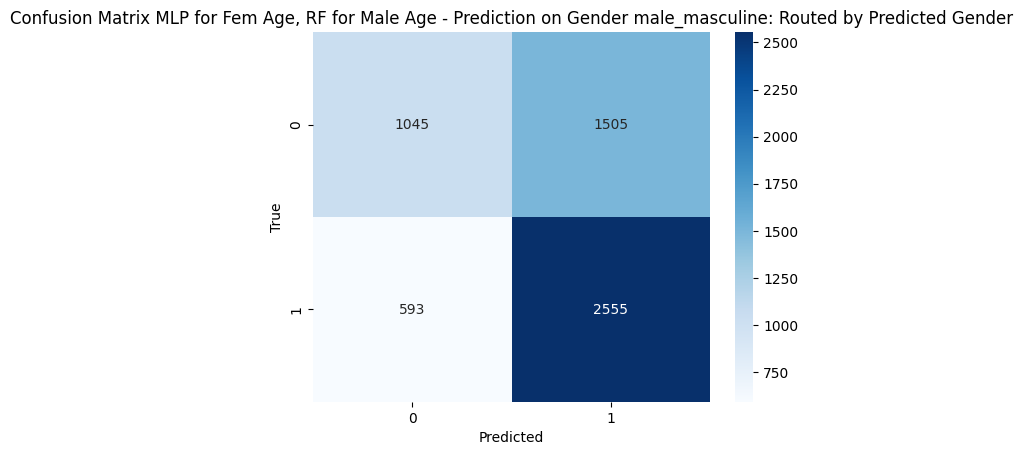


MLP for Fem Age, RF for Male Age - Prediction Report on Gender total: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      5100
           1       0.64      0.71      0.68      5100

    accuracy                           0.66     10200
   macro avg       0.66      0.66      0.66     10200
weighted avg       0.66      0.66      0.66     10200



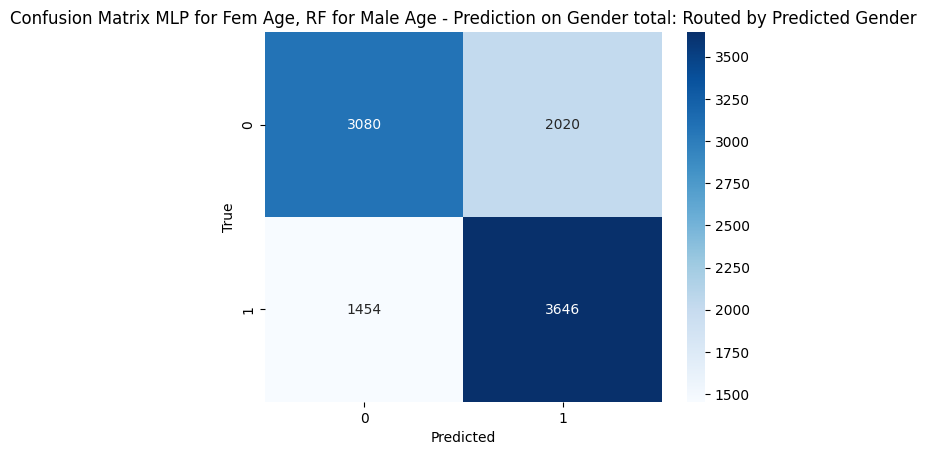

<Figure size 1200x800 with 0 Axes>

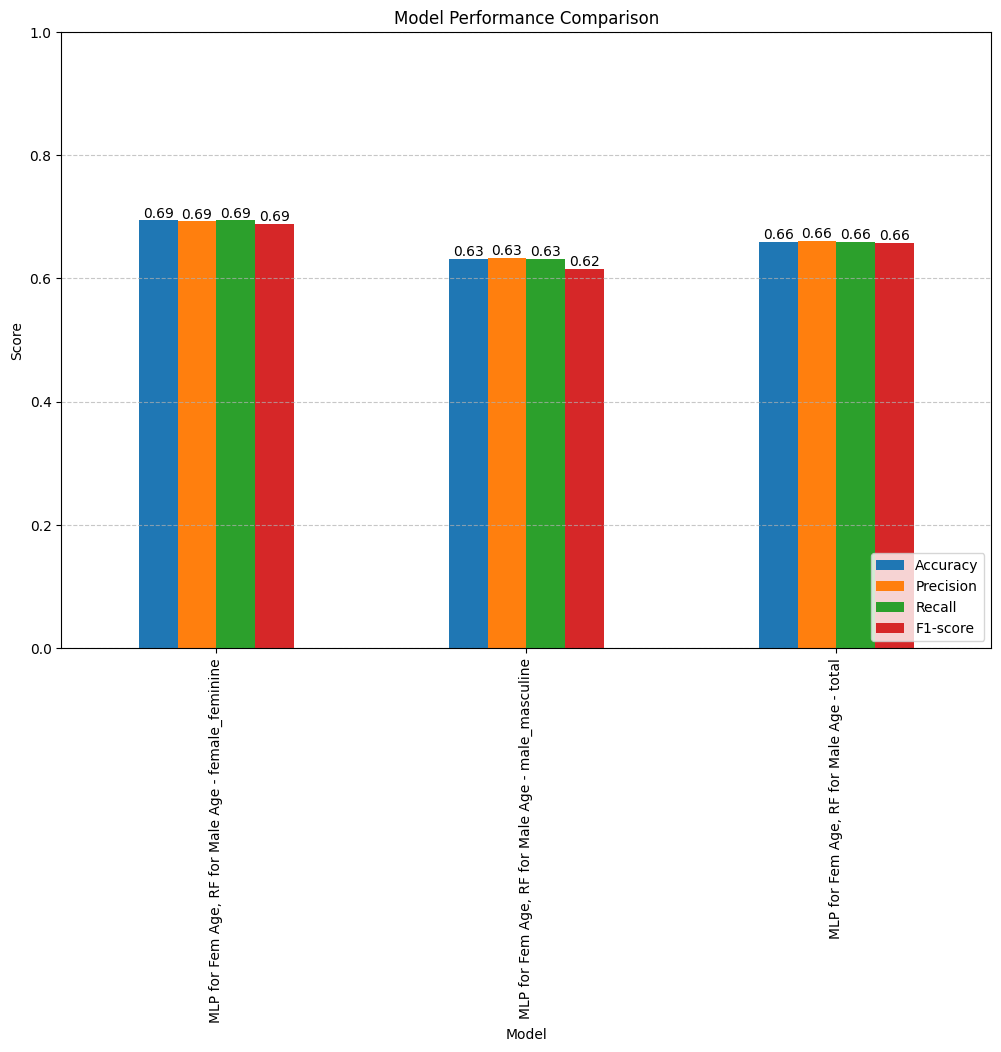


 Accuracy True Gender Routing: 0.6672

 Accuracy Predicted Gender Routing: 0.6594

 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0077


,Model,Accuracy,Precision,Recall,F1-score
0,"MLP for Fem Age, RF for Male Age - female_femi...",0.694358,0.692562,0.694358,0.689206
1,"MLP for Fem Age, RF for Male Age - male_masculine",0.631801,0.633187,0.631801,0.615004
2,"MLP for Fem Age, RF for Male Age - total",0.659412,0.661400,0.659412,0.658360


In [109]:
# MLP Gender + RF Age Female + RF Age Male
# {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
# 'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

fit_predict_two_stage_gender_age_pipeline(
    MLPClassifier(hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=1000,
                activation="relu",
                random_state=27,
                learning_rate='adaptive',
                alpha=0.0005,
                early_stopping=True,
                validation_fraction = 0.1),

    RandomForestClassifier(
        max_depth= 20,
        max_features= "sqrt",
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=200,
        n_jobs=-1
    ),

    RandomForestClassifier(
        max_depth= 20,
        max_features= "sqrt",
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=200,
        n_jobs=-1
    ),
              
    "MLPClassifier for Gender",
    "MLP for Fem Age, RF for Male Age",
    y_train_age=y_train_clean["age_young_old_encoded"],
    y_train_gender=y_train_clean["gender_encoded"],
    y_comp_age = y_val["age_young_old_encoded"],
    y_comp_gender = y_val["gender_encoded"], gender_encoded=True

    )


Fitting RF Classifier for Gender on training set

Predicting RF Classifier for Gender on training set

Predicting RF Classifier for Gender on comparison set

RF Classifier for Gender Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       1.00      1.00      1.00     16517
 male_masculine       1.00      1.00      1.00     21238

       accuracy                           1.00     37755
      macro avg       1.00      1.00      1.00     37755
   weighted avg       1.00      1.00      1.00     37755


RF Classifier for Gender Gender Model - Comparison Set:
                 precision    recall  f1-score   support

female_feminine       0.86      0.83      0.85      4502
 male_masculine       0.87      0.90      0.88      5698

       accuracy                           0.87     10200
      macro avg       0.87      0.87      0.87     10200
   weighted avg       0.87      0.87      0.87     10200



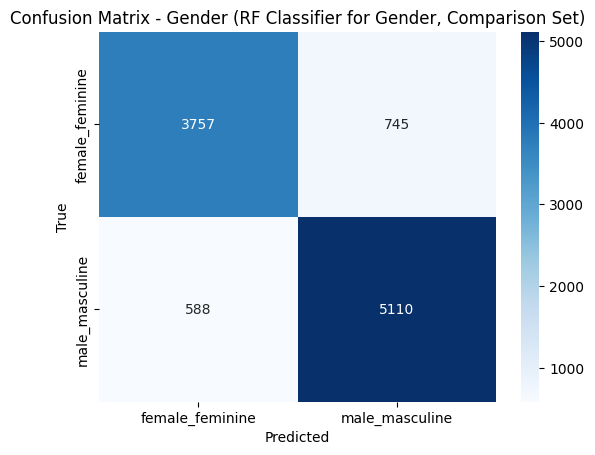


Fitting MLP for Age on Gender Female

Fitting MLP for Age on Gender Male

Predicting MLP for Age on training set

Predicting MLP for Age on comparison set with perfect routing

Predicting MLP for Age on comparison set with predicted routing

Evaluating MLP for Age on training set

MLP for Age - Prediction Report on Gender female_feminine: Training Data
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9365
           1       0.97      0.97      0.97      7152

    accuracy                           0.98     16517
   macro avg       0.98      0.98      0.98     16517
weighted avg       0.98      0.98      0.98     16517


MLP for Age - Prediction Report on Gender male_masculine: Training Data
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      9540
           1       0.76      0.74      0.75     11698

    accuracy                           0.73     21238
   macro avg       0.72   

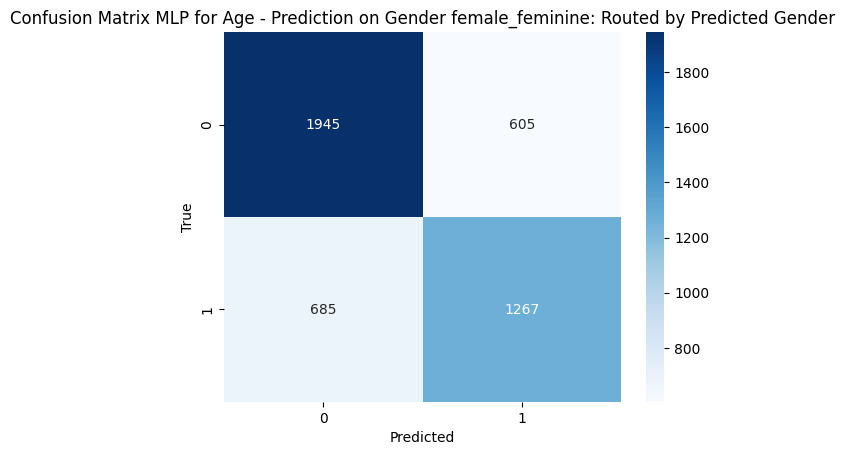


MLP for Age - Prediction Report on Gender male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      2550
           1       0.67      0.66      0.66      3148

    accuracy                           0.63      5698
   macro avg       0.63      0.63      0.63      5698
weighted avg       0.63      0.63      0.63      5698



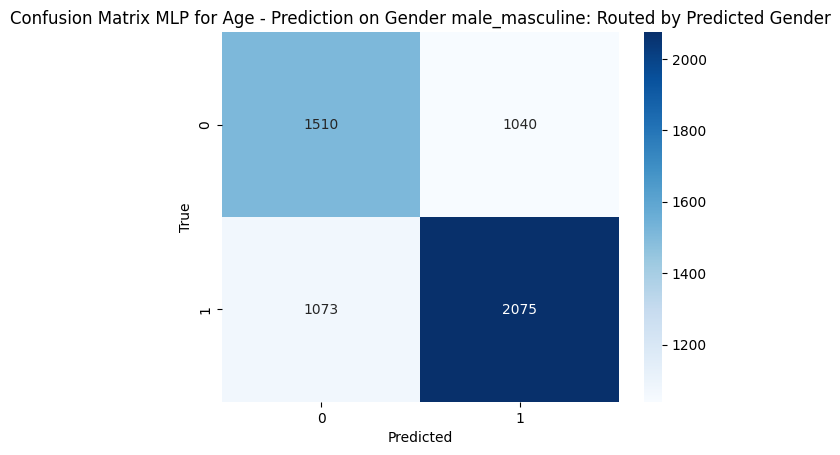


MLP for Age - Prediction Report on Gender total: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      5100
           1       0.67      0.66      0.66      5100

    accuracy                           0.67     10200
   macro avg       0.67      0.67      0.67     10200
weighted avg       0.67      0.67      0.67     10200



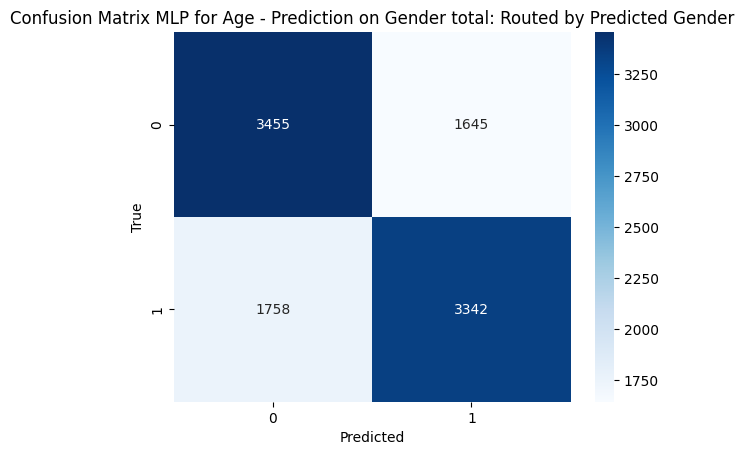

<Figure size 1200x800 with 0 Axes>

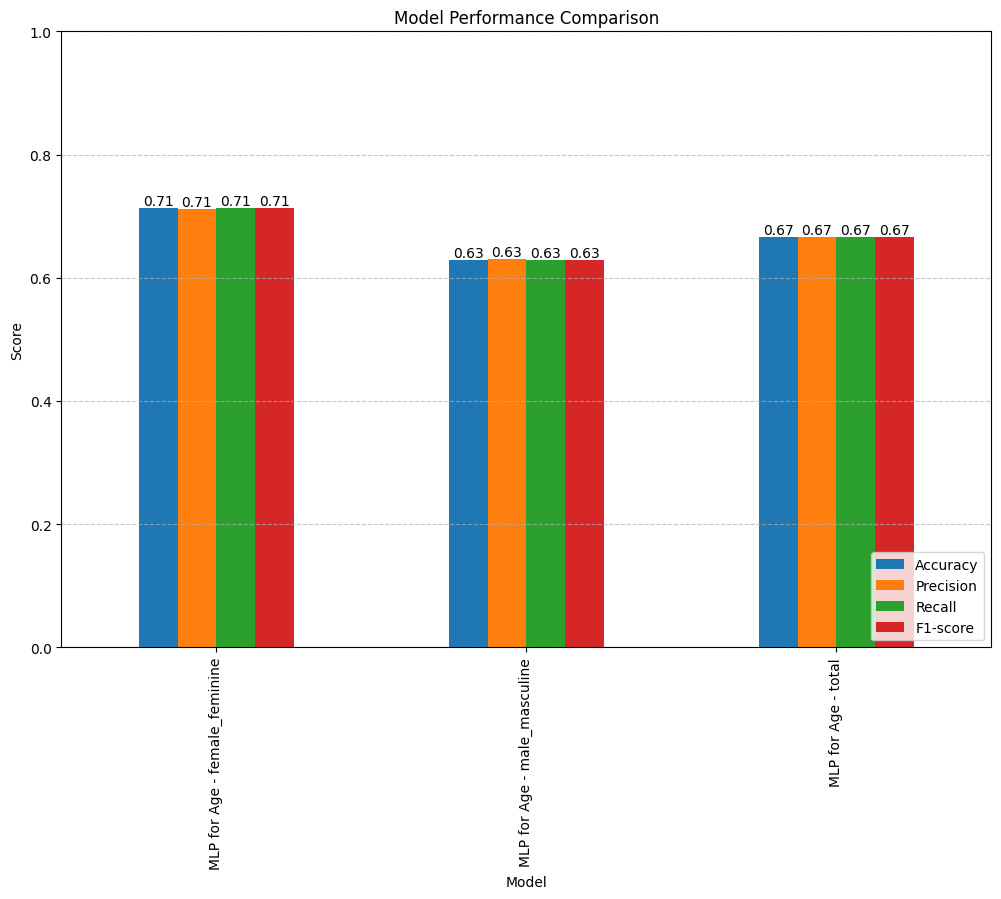


 Accuracy True Gender Routing: 0.6830

 Accuracy Predicted Gender Routing: 0.6664

 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0167


,Model,Accuracy,Precision,Recall,F1-score
0,MLP for Age - female_feminine,0.713461,0.712346,0.713461,0.712676
1,MLP for Age - male_masculine,0.629168,0.629640,0.629168,0.629383
2,MLP for Age - total,0.666373,0.666454,0.666373,0.666332


In [96]:
# RF Gender + MLP Age Female + MLP Age Male

# Best Parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}

fit_predict_two_stage_gender_age_pipeline(
    RandomForestClassifier(
        max_depth=None,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=5,
        n_estimators=300,
        n_jobs=-1
    ),
    MLPClassifier(hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=200,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.001,
              early_stopping=True,
              validation_fraction = 0.1,
              solver = 'adam'),

    MLPClassifier(hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=200,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.01,early_stopping=True,
              validation_fraction = 0.1,
              solver = 'adam'),
              
    "RF Classifier for Gender",
    "MLP for Age",
    y_train_age=y_train_clean["age_young_old_encoded"],
    y_train_gender=y_train_clean["gender_encoded"],
    y_comp_age = y_val["age_young_old_encoded"],
    y_comp_gender = y_val["gender_encoded"], gender_encoded=True

    )

## Feature Enriched Models

In [97]:
def enrich_data(model_class, model_name, X_train, y_train, X_comp, y_comp, y_comp_encoded, return_pipeline=False, graphics=True):
    """
    Enrich the dataset with gender probability from a trained model.
    """
    
    # Fit gender model
    pipe_gender = make_pipeline(clone(preprocessing), clone(model_class))
    print(f"\nFitting {model_name} on training set")
    pipe_gender.fit(X_train, y_train)

    # Predict gender probability
    print(f"\nPredict probability of {model_name} on training set")
    prob_gender_train = pipe_gender.predict_proba(X_train)[:, 1]
    print(f"\nPredict probability of {model_name} on comparison set")
    prob_gender_comp = pipe_gender.predict_proba(X_comp)[:, 1]
    

    # Evaluate gender model
    predicted_gender_comp = pipe_gender.predict(X_comp)
    print(f"\n{model_name} Gender Model - Comparison Set Classification Report:")
    print(classification_report(y_comp, predicted_gender_comp))

    auc_score = roc_auc_score(y_comp_encoded, prob_gender_comp)
    logloss = log_loss(y_comp_encoded, prob_gender_comp)
    print(f"AUC-ROC for Gender Probabilities: {auc_score:.4f}")
    print(f"Log Loss for Gender Probabilities: {logloss:.4f}")

    if graphics:
        RocCurveDisplay.from_predictions(y_comp_encoded, prob_gender_comp)
        plt.title("ROC Curve - Gender Probabilities")
        plt.show()

        prob_true, prob_pred = calibration_curve(y_comp_encoded, prob_gender_comp, n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title("Calibration Curve - Gender Probabilities")
        plt.show()

    # ====== Append gender prob to features ======
    X_train_aug = X_train.copy()
    X_comp_aug = X_comp.copy()
    X_train_aug['prob_gender_male'] = prob_gender_train
    X_comp_aug['prob_gender_male'] = prob_gender_comp
    
    if return_pipeline:
        return X_train_aug, X_comp_aug, pipe_gender
    else:
        return X_train_aug, X_comp_aug


In [98]:
def fit_predict_gender_age_pipeline_with_soft_feature(
    gender_model_class,
    age_model_class,
    gender_model_name="GenderModel",
    age_model_name="AgeModel",
    X_train=X_train_clean, y_train_gender=y_train_clean['gender'],y_train_age=y_train_clean['age_young_old'], X_comp=X_val,
    y_comp_gender=y_val['gender'], y_comp_gender_encoded=y_val['gender_encoded'],y_comp_age=y_val['age_young_old'],
    binning=None, multiclass=False, return_pipeline=False):
    
    X_train_aug, X_comp_aug, pipe_gender = enrich_data(gender_model_class, gender_model_name, X_train, y_train_gender, X_comp, y_comp_gender, y_comp_gender_encoded, return_pipeline=True)

    # ====== Fit age model ======
    age_model = make_pipeline(clone(preprocessing), clone(age_model_class))
    print(f"\nFitting {age_model_name} with gender probability feature")
    age_model.fit(X_train_aug, y_train_age)
    print(f"\nPredicting {age_model_name} on training set")
    pred_train=age_model.predict(X_train_aug)
    print(f"\nPredicting {age_model_name} on comparison set")
    pred_comp = age_model.predict(X_comp_aug)
    
    if multiclass:
        y_train_age = y_train_age[:, 1]
        y_comp_age = y_comp_age[:, 1]
        pred_train = pred_train[:, 1]
        pred_comp = pred_comp[:, 1]
        
    
    evaluate_models(y_train_age, {age_model_name : pred_train}, (12, 8), False, "Training Set", binning=binning)

    # ====== Predict age ======
    if return_pipeline:
        return pipe_gender, age_model
    else:
        return evaluate_models(y_comp_age, {age_model_name : pred_comp}, (12, 8), True, "Comparison Set", binning=binning)


Fitting MLP for Gender on training set


c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Predict probability of MLP for Gender on training set

Predict probability of MLP for Gender on comparison set

MLP for Gender Gender Model - Comparison Set Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.89      0.89      0.89      4502
 male_masculine       0.91      0.92      0.91      5698

       accuracy                           0.90     10200
      macro avg       0.90      0.90      0.90     10200
   weighted avg       0.90      0.90      0.90     10200

AUC-ROC for Gender Probabilities: 0.9608
Log Loss for Gender Probabilities: 0.2512


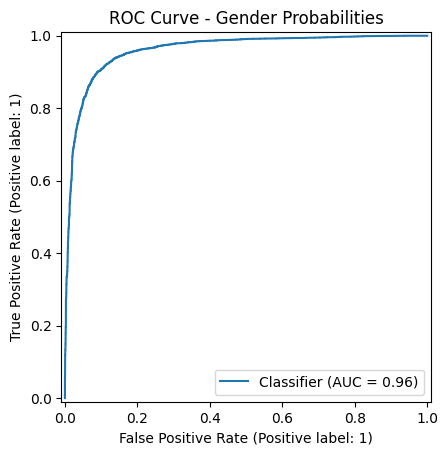

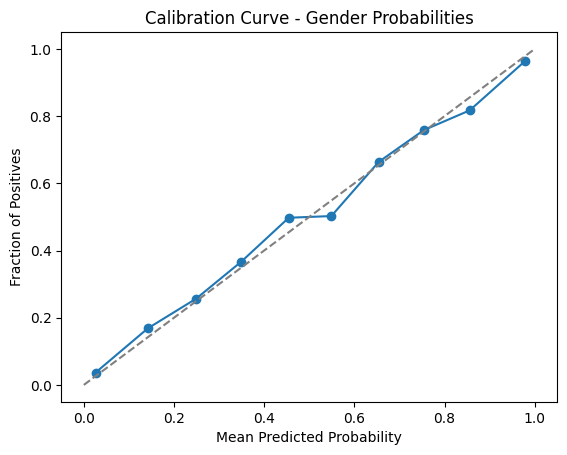


Fitting Pre-Binned RF for Age with gender probability feature

Predicting Pre-Binned RF for Age on training set

Predicting Pre-Binned RF for Age on comparison set

===== Pre-Binned RF for Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       1.00      1.00      1.00     18850
       young       1.00      1.00      1.00     18905

    accuracy                           1.00     37755
   macro avg       1.00      1.00      1.00     37755
weighted avg       1.00      1.00      1.00     37755


===== Pre-Binned RF for Age: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.61      0.66      0.63      5100
       young       0.63      0.59      0.61      5100

    accuracy                           0.62     10200
   macro avg       0.62      0.62      0.62     10200
weighted avg       0.62      0.62      0.62     10200



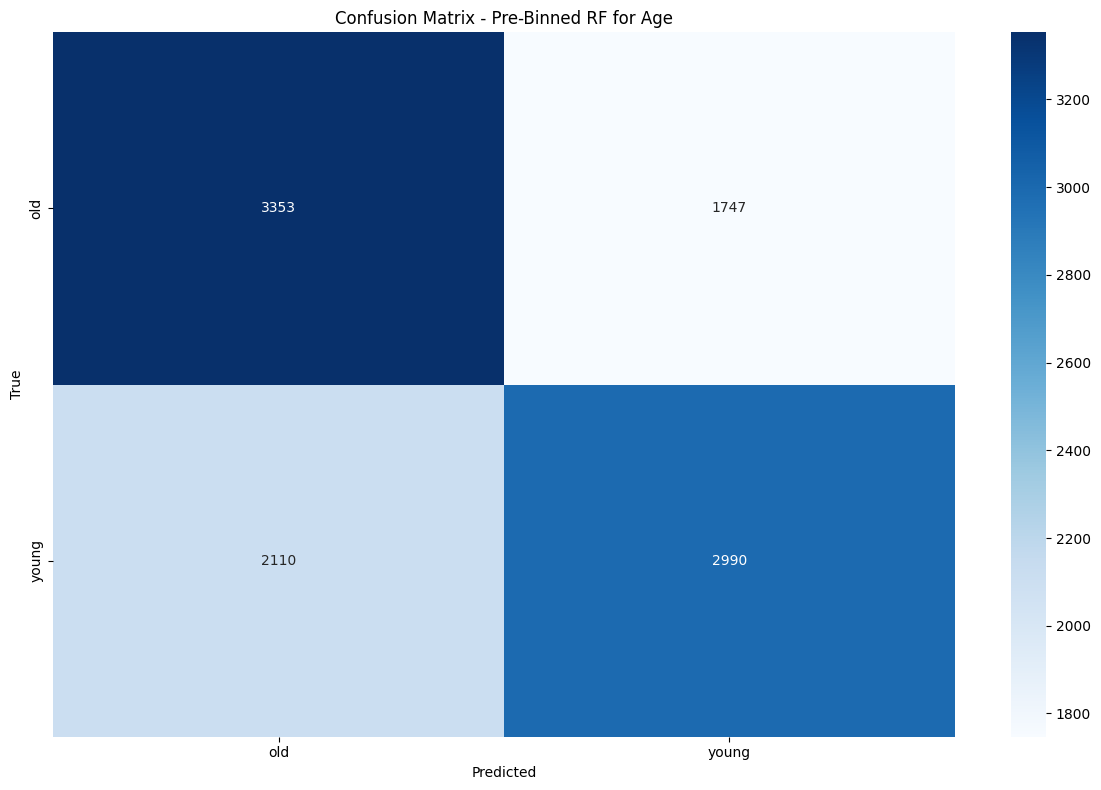

<Figure size 1200x800 with 0 Axes>

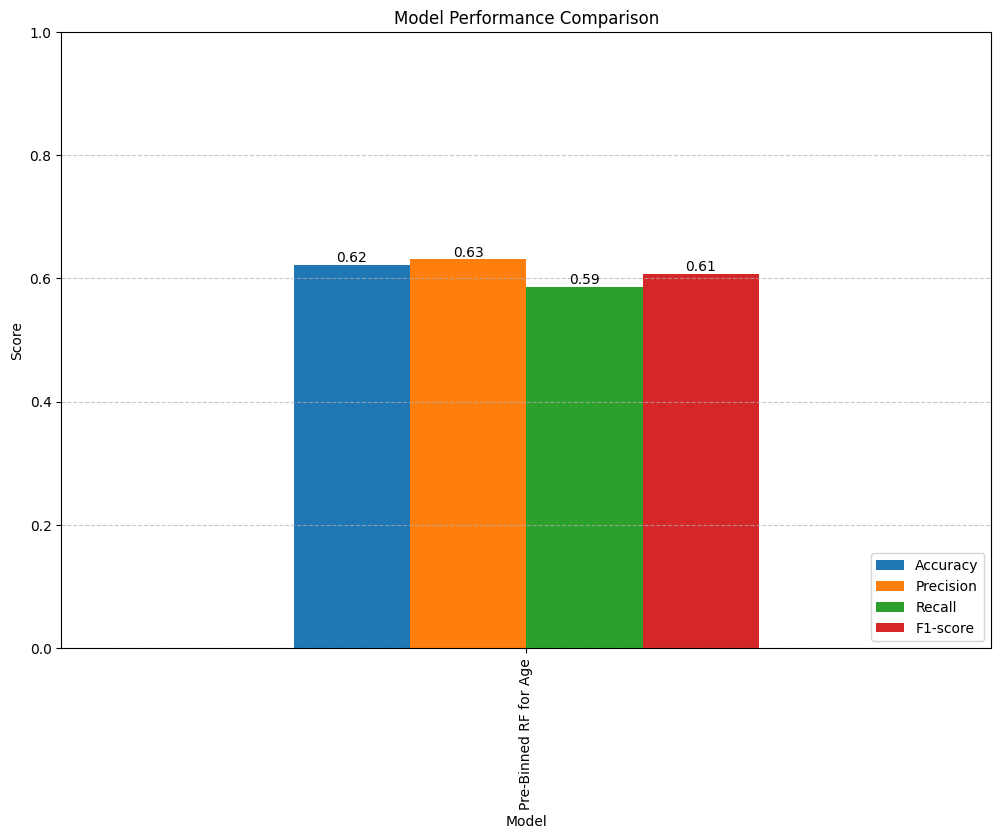

,Model,Accuracy,Precision,Recall,F1-score
0,Pre-Binned RF for Age,0.621863,0.631201,0.586275,0.607909


In [50]:
fit_predict_gender_age_pipeline_with_soft_feature(
    MLPClassifier(hidden_layer_sizes=(16,8), alpha=0.00005, activation="relu", batch_size=64, learning_rate_init=0.001, max_iter=30,  learning_rate="adaptive", random_state=27),
    RandomForestClassifier(max_depth= 30, max_features="sqrt", min_samples_leaf=1, min_samples_split=3, n_estimators=30, random_state=27),
    "MLP for Gender", "Pre-Binned RF for Age"
)


Fitting MLP Gender on training set

Predict probability of MLP Gender on training set

Predict probability of MLP Gender on comparison set

MLP Gender Gender Model - Comparison Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4502
           1       0.92      0.92      0.92      5698

    accuracy                           0.92     10200
   macro avg       0.91      0.91      0.91     10200
weighted avg       0.92      0.92      0.92     10200

AUC-ROC for Gender Probabilities: 0.9651
Log Loss for Gender Probabilities: 0.2496


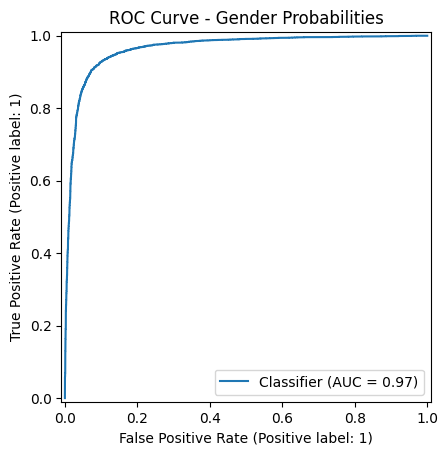

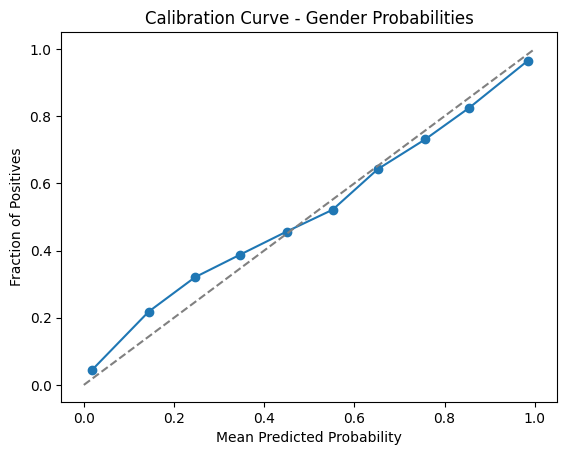


Fitting MLP Age with gender probability feature

Predicting MLP Age on training set

Predicting MLP Age on comparison set

===== MLP Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     18905
           1       0.92      0.95      0.94     18850

    accuracy                           0.94     37755
   macro avg       0.94      0.94      0.94     37755
weighted avg       0.94      0.94      0.94     37755


===== MLP Age: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      5100
           1       0.67      0.70      0.68      5100

    accuracy                           0.67     10200
   macro avg       0.67      0.67      0.67     10200
weighted avg       0.67      0.67      0.67     10200



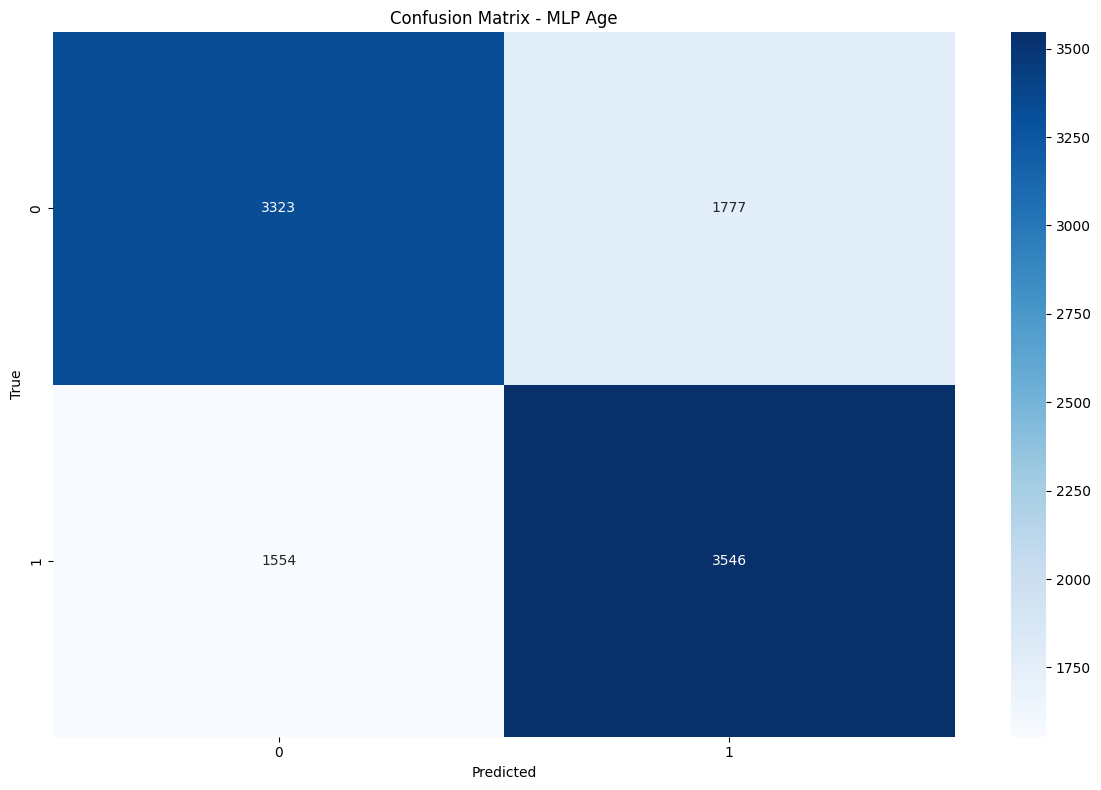

<Figure size 1200x800 with 0 Axes>

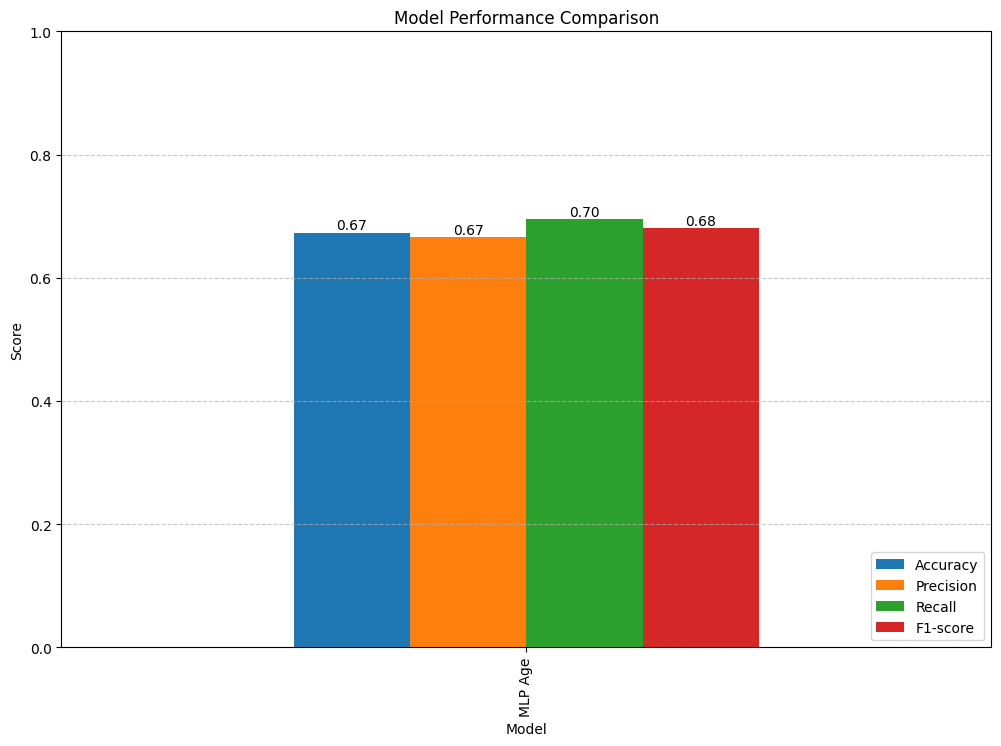

,Model,Accuracy,Precision,Recall,F1-score
0,MLP Age,0.673431,0.666166,0.695294,0.680418


In [99]:
# Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 64, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (512, 256), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 200, 'mlp__solver': 'adam', 'mlp__validation_fraction': 0.1}

fit_predict_gender_age_pipeline_with_soft_feature(
    MLPClassifier(hidden_layer_sizes=(512, 256),
                  batch_size=64,
                  learning_rate_init=0.001,
                  max_iter=1000,
                  activation="relu",
                  random_state=27,
                  learning_rate='adaptive',
                  alpha=0.0005,
                  early_stopping=True,
                  validation_fraction=0.1),

    MLPClassifier(activation="relu",
                  alpha=0.0001,
                  batch_size=64,
                  early_stopping=True,
                  hidden_layer_sizes=(512, 256),
                  learning_rate_init=0.001,
                  max_iter=200,
                  solver="adam",
                  validation_fraction=0.1),

    gender_model_name="MLP Gender",
    age_model_name="MLP Age",
    y_train_gender=y_train_clean['gender_encoded'],
    y_train_age=y_train_clean['age_young_old_encoded'],
    X_comp=X_val,
    y_comp_gender=y_val['gender_encoded'],
    y_comp_gender_encoded=y_val['gender_encoded'],
    y_comp_age=y_val['age_young_old_encoded']
)

In [54]:
if GRID_SEARCH:
    X_train_aug, X_comp_aug= enrich_data(
    MLPClassifier(hidden_layer_sizes=(512, 256),
                  batch_size=64,
                  learning_rate_init=0.001,
                  max_iter=1000,
                  activation="relu",
                  random_state=27,
                  learning_rate='adaptive',
                  alpha=0.0005,
                  early_stopping=True,
                  validation_fraction=0.1),

    model_name="MLP Gender",
    X_train=X_train_clean,
    y_train=y_train_clean['gender_encoded'],
    X_comp=X_val,
    y_comp=y_val['gender_encoded'],
    y_comp_encoded=y_val['gender_encoded'], graphics=False
)


Fitting MLP Gender on training set

Predict probability of MLP Gender on training set

Predict probability of MLP Gender on comparison set

MLP Gender Gender Model - Comparison Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4502
           1       0.92      0.92      0.92      5698

    accuracy                           0.92     10200
   macro avg       0.91      0.91      0.91     10200
weighted avg       0.92      0.92      0.92     10200

AUC-ROC for Gender Probabilities: 0.9651
Log Loss for Gender Probabilities: 0.2496


Starting grid search for mlp (predicting age_young_old_encoded)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256, 128), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam, mlp__validation_fraction=0.1; total time=  32.1s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256, 128), mlp__learning_rate_init=0.001, mlp__max_iter=500, mlp__solver=adam, mlp__validation_fraction=0.1; total time=  32.2s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(512, 256, 128), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam, mlp__validation_fraction=0.1; total time=  39.3s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_la

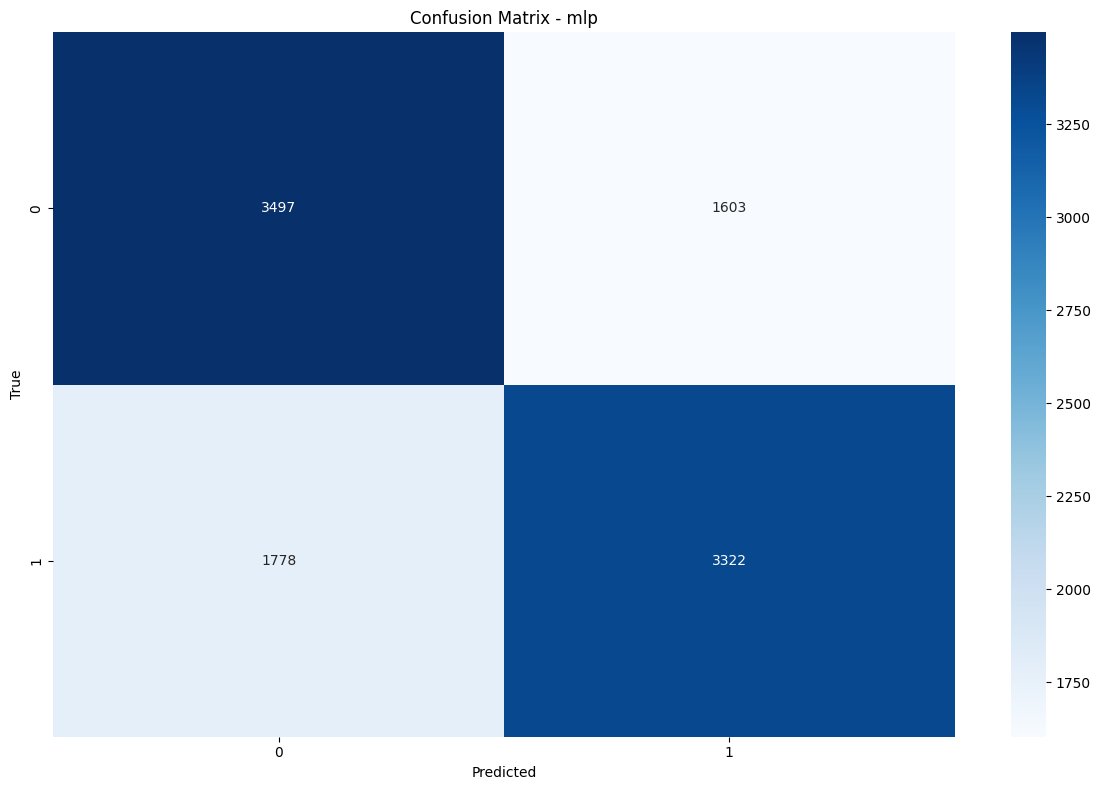

<Figure size 1200x800 with 0 Axes>

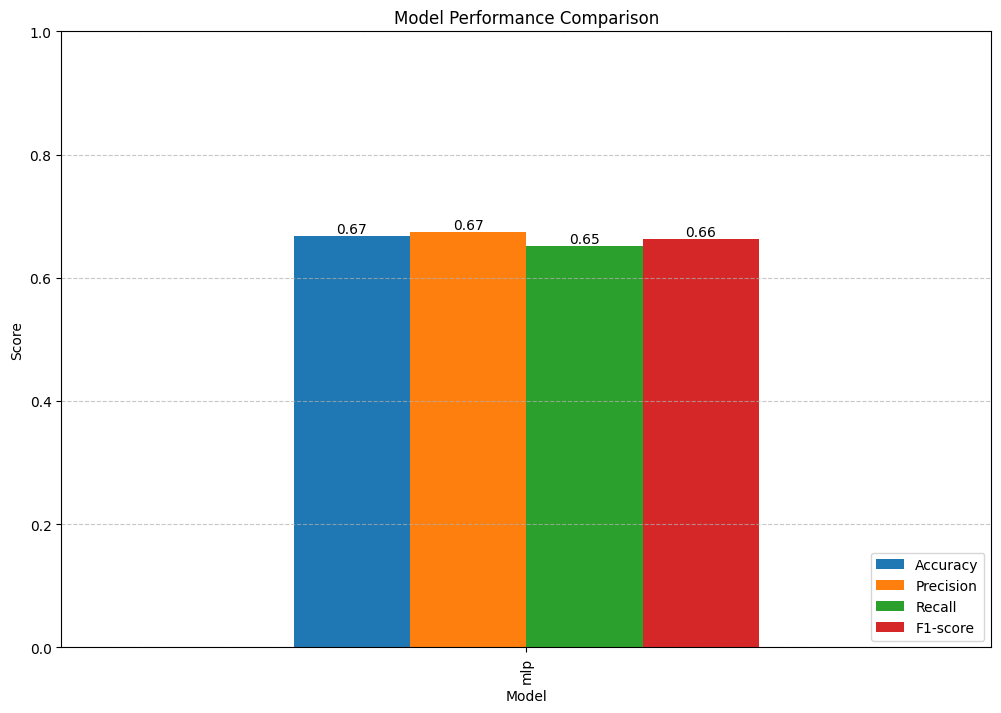

In [56]:
if GRID_SEARCH:

    param_grid = {
    'mlp__hidden_layer_sizes': [(512, 256, 128),(512, 256),],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.0001, 0.02, 0.001],
    'mlp__learning_rate_init': [0.001, 0.0005],
    'mlp__batch_size': [64],
    'mlp__max_iter': [200, 500],
    'mlp__early_stopping': [True],
    'mlp__validation_fraction': [0.1],
    'mlp__solver': ['adam']}
    
    mlp = MLPClassifier(random_state=27, max_iter=300)
    
    optimize_via_grid_search(mlp,"mlp",param_grid,
    X_train=X_train_aug, X_val=X_comp_aug,
    y_parameter="age_young_old_encoded")


Fitting MLP Gender on training set

Predict probability of MLP Gender on training set

Predict probability of MLP Gender on comparison set

MLP Gender Gender Model - Comparison Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4502
           1       0.92      0.92      0.92      5698

    accuracy                           0.92     10200
   macro avg       0.91      0.91      0.91     10200
weighted avg       0.92      0.92      0.92     10200

AUC-ROC for Gender Probabilities: 0.9651
Log Loss for Gender Probabilities: 0.2496


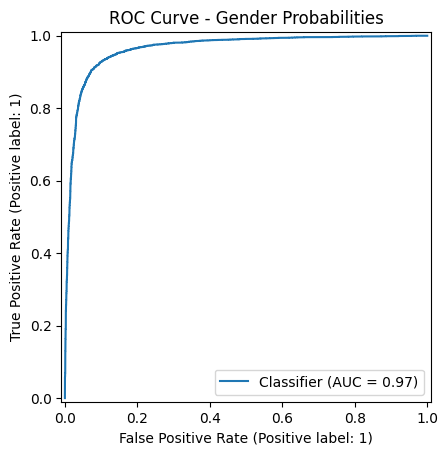

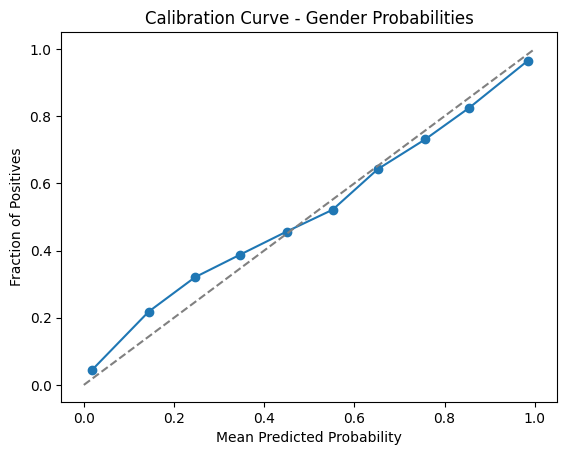


Fitting MLP Age with gender probability feature

Predicting MLP Age on training set

Predicting MLP Age on comparison set

===== MLP Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18905
           1       1.00      1.00      1.00     18850

    accuracy                           1.00     37755
   macro avg       1.00      1.00      1.00     37755
weighted avg       1.00      1.00      1.00     37755


===== MLP Age: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.65      5100
           1       0.65      0.70      0.67      5100

    accuracy                           0.66     10200
   macro avg       0.66      0.66      0.66     10200
weighted avg       0.66      0.66      0.66     10200



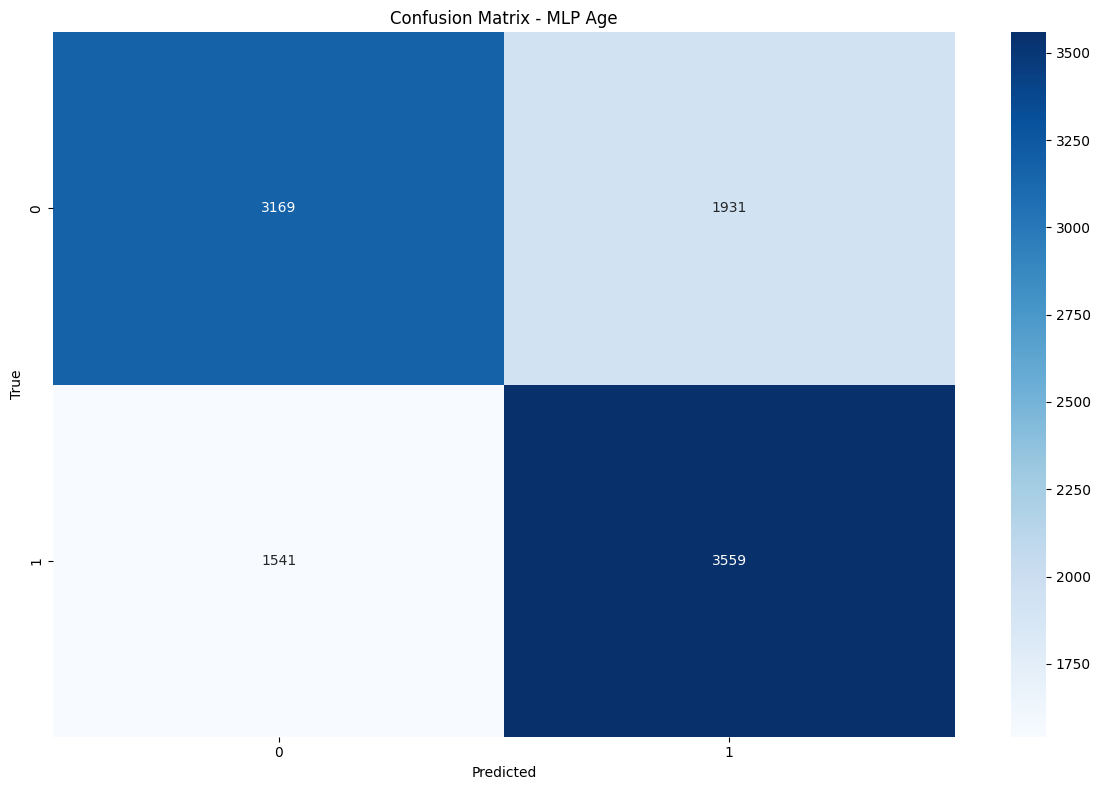

<Figure size 1200x800 with 0 Axes>

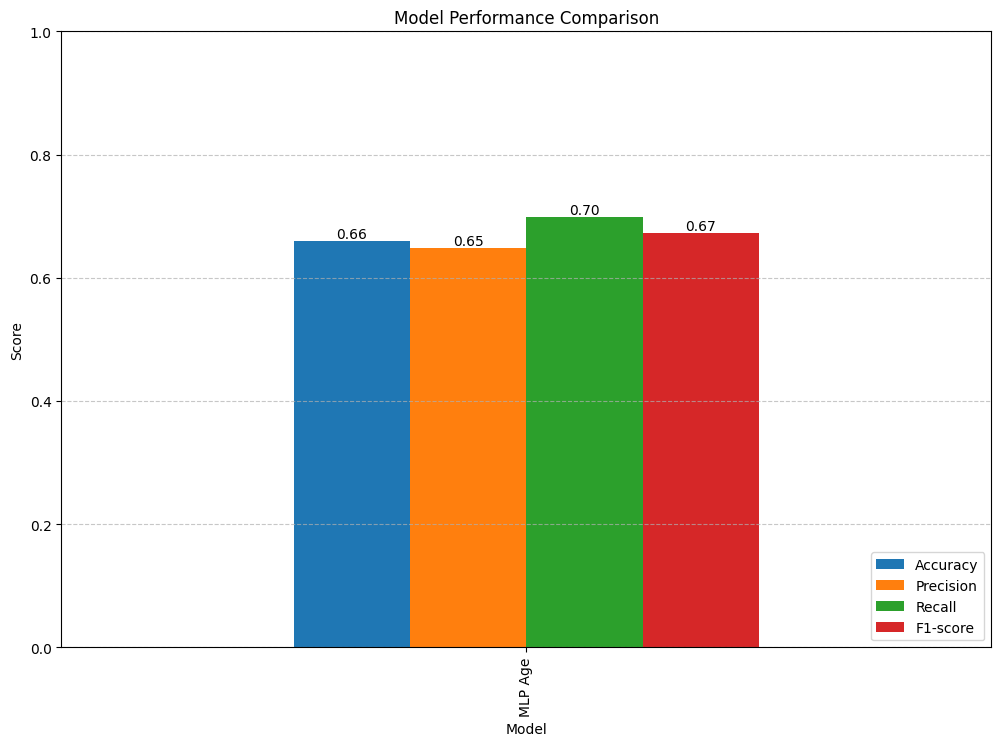

,Model,Accuracy,Precision,Recall,F1-score
0,MLP Age,0.659608,0.64827,0.697843,0.672144


In [117]:
# Best Parameters: {'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}

fit_predict_gender_age_pipeline_with_soft_feature(
    MLPClassifier(hidden_layer_sizes=(512, 256),
                  batch_size=64,
                  learning_rate_init=0.001,
                  max_iter=1000,
                  activation="relu",
                  random_state=27,
                  learning_rate='adaptive',
                  alpha=0.0005,
                  early_stopping=True,
                  validation_fraction=0.1),

    RandomForestClassifier(
        criterion="gini",
        max_depth=None,
        max_features="sqrt",
        min_samples_leaf=1,
        min_samples_split=5,
        n_estimators=300,
        n_jobs=-1
    ),

    gender_model_name="MLP Gender",
    age_model_name="MLP Age",
    y_train_gender=y_train_clean['gender_encoded'],
    y_train_age=y_train_clean['age_young_old_encoded'],
    X_comp=X_val,
    y_comp_gender=y_val['gender_encoded'],
    y_comp_gender_encoded=y_val['gender_encoded'],
    y_comp_age=y_val['age_young_old_encoded']
)

## Final Model Comparisons

Fitting Baseline SVC...
Predicting on training set...
Predicting on comparison set...
Evaluating Baseline SVC on training set...

===== Baseline SVC: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.63      0.65      0.64     18850
       young       0.64      0.61      0.62     18905

    accuracy                           0.63     37755
   macro avg       0.63      0.63      0.63     37755
weighted avg       0.63      0.63      0.63     37755

Evaluating Baseline SVC on comparison set...

===== Baseline SVC: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.62      0.63      0.62      4500
       young       0.62      0.61      0.62      4500

    accuracy                           0.62      9000
   macro avg       0.62      0.62      0.62      9000
weighted avg       0.62      0.62      0.62      9000



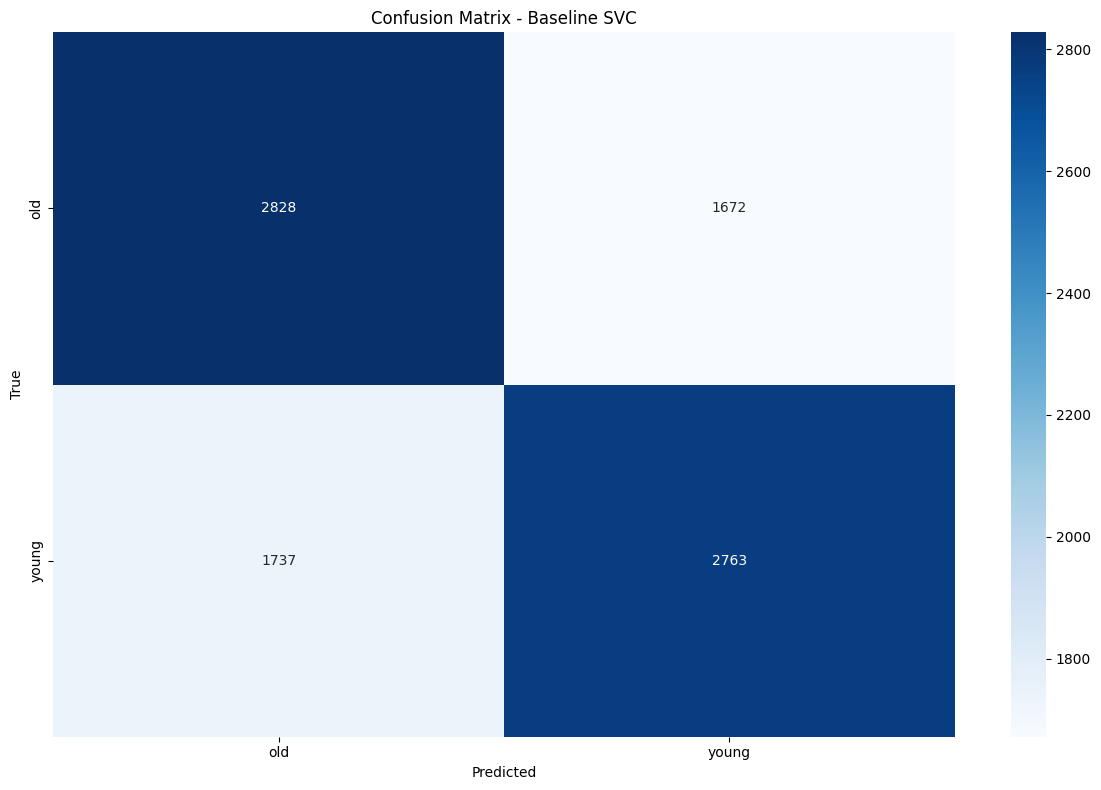

<Figure size 1200x800 with 0 Axes>

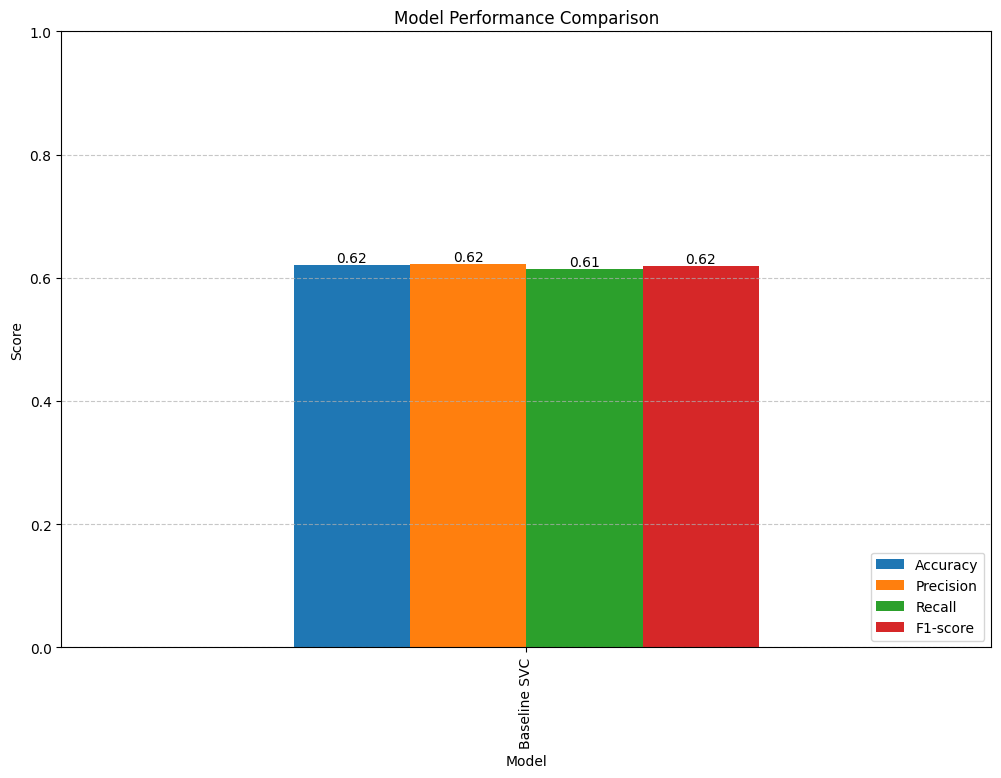

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline SVC,0.621222,0.622999,0.614,0.618467


In [72]:
optimized_svc= fit_pipeline_predict_evaluate(
    LinearSVC(
        random_state=27,
        C=0.1,
        loss='squared_hinge',
        max_iter=1000,
        tol=0.001),
    "Baseline SVC",
    X_comp= X_test,
    y_comp= y_test["age_young_old"]
)
optimized_svc

Fitting Optimized Standard MLP...
Predicting on training set...
Predicting on comparison set...
Evaluating Optimized Standard MLP on training set...

===== Optimized Standard MLP: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     18905
           1       0.82      0.79      0.81     18850

    accuracy                           0.81     37755
   macro avg       0.81      0.81      0.81     37755
weighted avg       0.81      0.81      0.81     37755

Evaluating Optimized Standard MLP on comparison set...

===== Optimized Standard MLP: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      4500
           1       0.68      0.65      0.66      4500

    accuracy                           0.67      9000
   macro avg       0.67      0.67      0.67      9000
weighted avg       0.67      0.67      0.67      

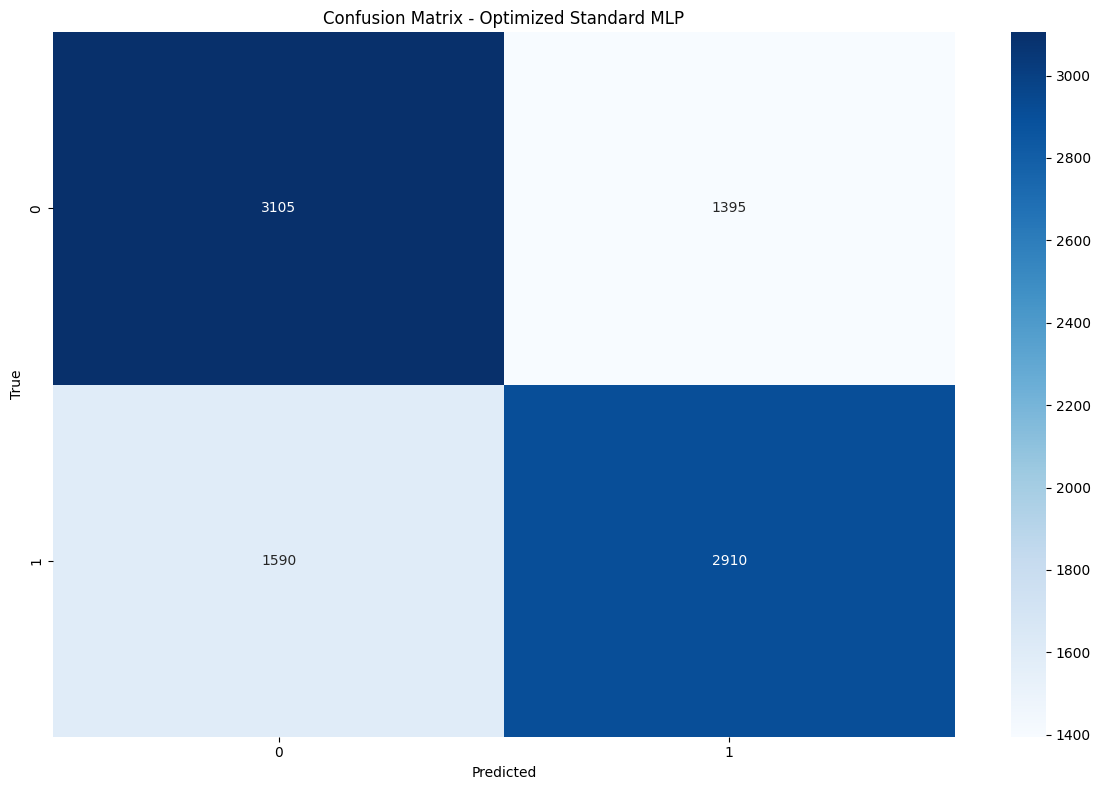

<Figure size 1200x800 with 0 Axes>

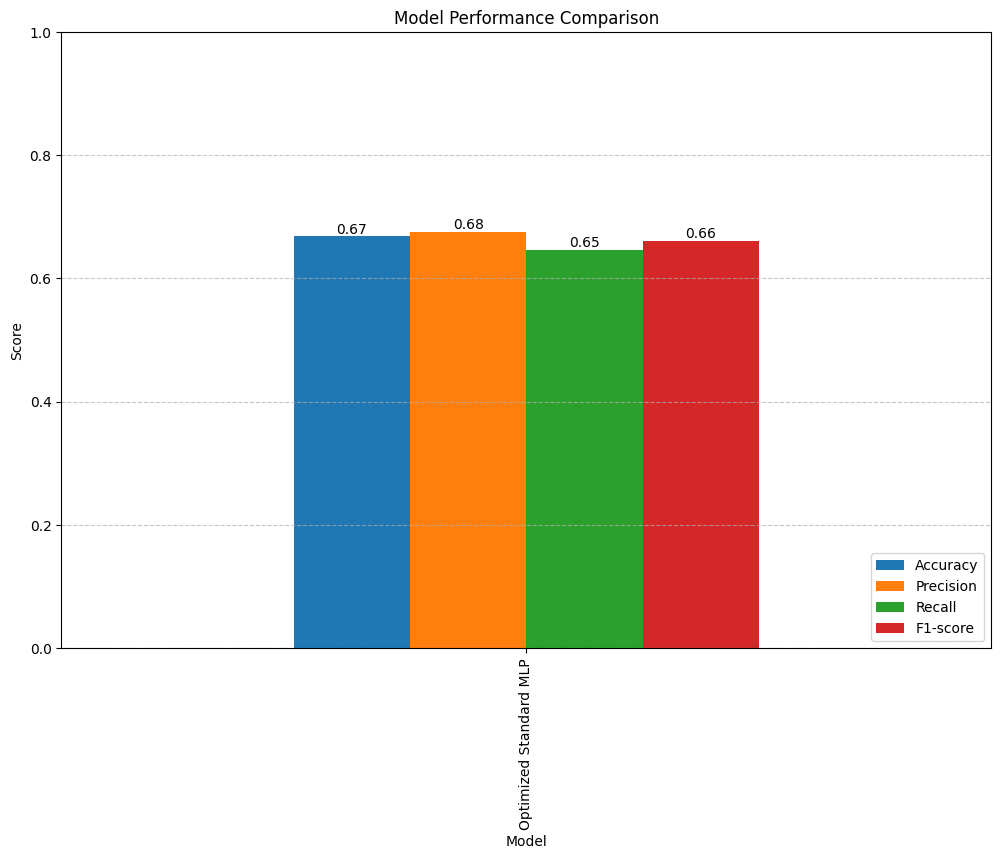

,Model,Accuracy,Precision,Recall,F1-score
0,Optimized Standard MLP,0.668333,0.675958,0.646667,0.660988


In [73]:
optimized_MLP_test_data= fit_pipeline_predict_evaluate(
    MLPClassifier(
        random_state=27,
        activation='relu',
        alpha=0.0001,
        batch_size=64,
        early_stopping=True,
        hidden_layer_sizes=(512, 256),
        learning_rate_init=0.001,
        max_iter=200,
        solver='adam',
        learning_rate='adaptive',
        validation_fraction=0.1),
    "Optimized Standard MLP",
    X_comp= X_test,
    y_train= y_train_clean["age_young_old_encoded"],
    y_comp= y_test["age_young_old_encoded"]
)
optimized_MLP_test_data


Fitting MLP for Gender on training set

Predicting MLP for Gender on training set

Predicting MLP for Gender on comparison set

MLP for Gender Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.94      0.95      0.95     16517
 male_masculine       0.96      0.96      0.96     21238

       accuracy                           0.95     37755
      macro avg       0.95      0.95      0.95     37755
   weighted avg       0.95      0.95      0.95     37755


MLP for Gender Gender Model - Comparison Set:
                 precision    recall  f1-score   support

female_feminine       0.90      0.91      0.90      3973
 male_masculine       0.93      0.92      0.92      5027

       accuracy                           0.92      9000
      macro avg       0.91      0.91      0.91      9000
   weighted avg       0.92      0.92      0.92      9000



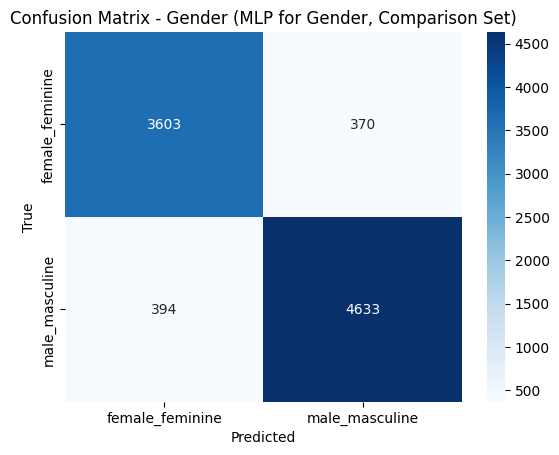


Fitting Gender Segmented MLP for Age on Gender Female

Fitting Gender Segmented MLP for Age on Gender Male

Predicting Gender Segmented MLP for Age on training set

Predicting Gender Segmented MLP for Age on comparison set with perfect routing

Predicting Gender Segmented MLP for Age on comparison set with predicted routing

Evaluating Gender Segmented MLP for Age on training set

Gender Segmented MLP for Age - Prediction Report on Gender female_feminine: Training Data
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9365
           1       0.97      0.97      0.97      7152

    accuracy                           0.98     16517
   macro avg       0.98      0.98      0.98     16517
weighted avg       0.98      0.98      0.98     16517


Gender Segmented MLP for Age - Prediction Report on Gender male_masculine: Training Data
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      9540

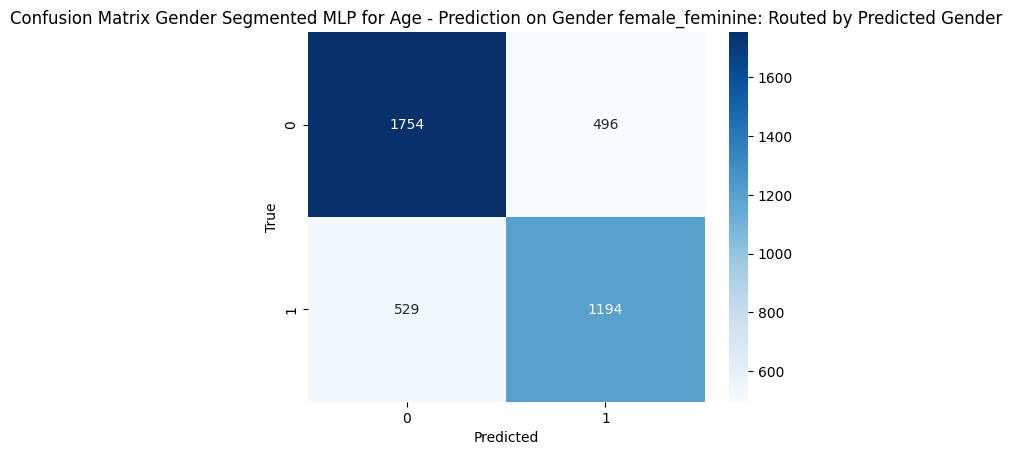


Gender Segmented MLP for Age - Prediction Report on Gender male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      2250
           1       0.68      0.69      0.68      2777

    accuracy                           0.65      5027
   macro avg       0.64      0.64      0.64      5027
weighted avg       0.65      0.65      0.65      5027



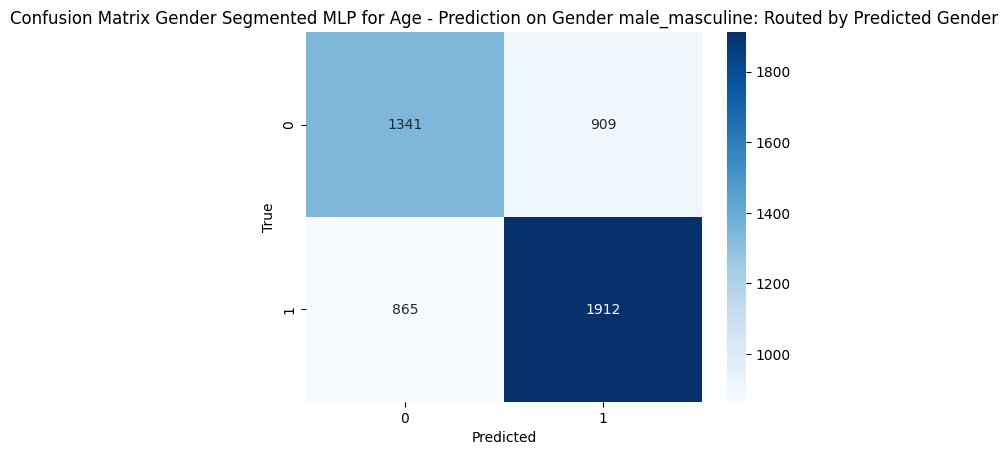


Gender Segmented MLP for Age - Prediction Report on Gender total: Routed by Predicted Gender
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4500
           1       0.69      0.69      0.69      4500

    accuracy                           0.69      9000
   macro avg       0.69      0.69      0.69      9000
weighted avg       0.69      0.69      0.69      9000



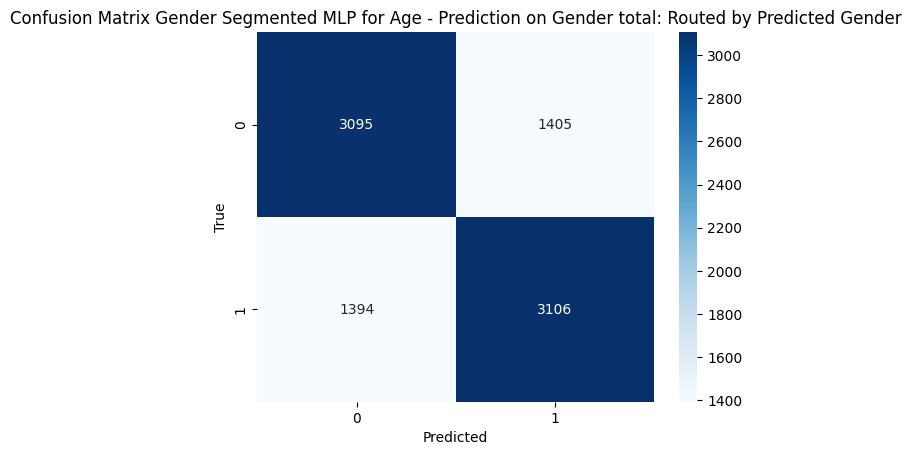

<Figure size 1200x800 with 0 Axes>

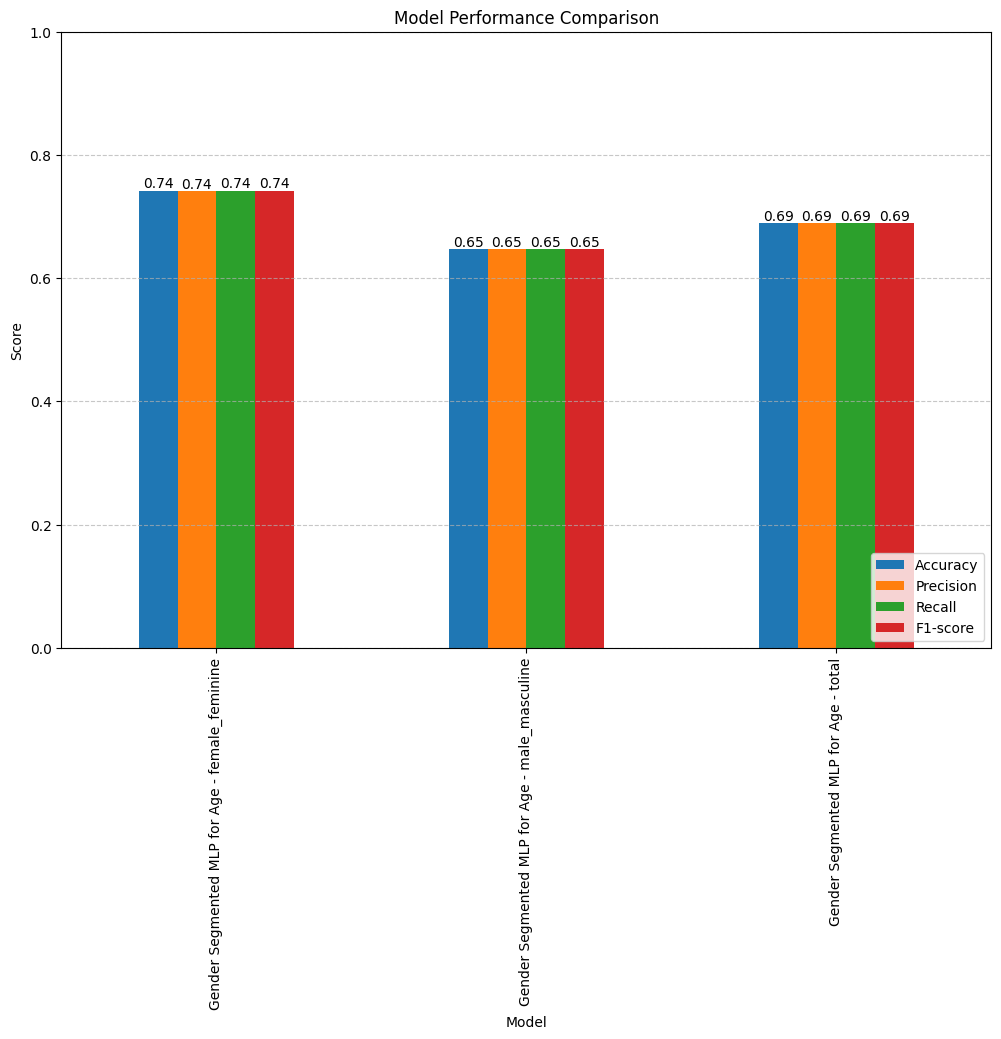


 Accuracy True Gender Routing: 0.6977

 Accuracy Predicted Gender Routing: 0.6890

 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0087


,Model,Accuracy,Precision,Recall,F1-score
0,Gender Segmented MLP for Age - female_feminine,0.742009,0.741495,0.742009,0.74170
1,Gender Segmented MLP for Age - male_masculine,0.647106,0.646494,0.647106,0.64675
2,Gender Segmented MLP for Age - total,0.689000,0.689001,0.689000,0.68900


In [76]:
optimized_segmented_test_data=fit_predict_two_stage_gender_age_pipeline(
    MLPClassifier(
        hidden_layer_sizes=(512, 256),
                  batch_size=64,
                  learning_rate_init=0.001,
                  max_iter=1000,
                  activation="relu",
                  random_state=27,
                  learning_rate='adaptive',
                  alpha=0.0005,
                  early_stopping=True,
                  validation_fraction=0.1),
    MLPClassifier(
        hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=200,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.001,
              early_stopping=True,
              validation_fraction = 0.1,
              solver = 'adam'),

    MLPClassifier(
        hidden_layer_sizes=(512, 256),
                batch_size=64,
                learning_rate_init=0.0005,
                max_iter=200,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.02,
              early_stopping=True,
              validation_fraction = 0.1,
              solver = 'adam'),
    "MLP for Gender",
    "Gender Segmented MLP for Age",
    y_train_age=y_train_clean["age_young_old_encoded"],
    y_train_gender=y_train_clean["gender_encoded"],
    X_comp = X_test,
    y_comp_age = y_test["age_young_old_encoded"],
    y_comp_gender = y_test["gender_encoded"],
    gender_encoded=True
)
optimized_segmented_test_data


Fitting MLP for Gender Probability on training set

Predict probability of MLP for Gender Probability on training set

Predict probability of MLP for Gender Probability on comparison set

MLP for Gender Probability Gender Model - Comparison Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3973
           1       0.93      0.92      0.92      5027

    accuracy                           0.92      9000
   macro avg       0.91      0.91      0.91      9000
weighted avg       0.92      0.92      0.92      9000

AUC-ROC for Gender Probabilities: 0.9680
Log Loss for Gender Probabilities: 0.2382


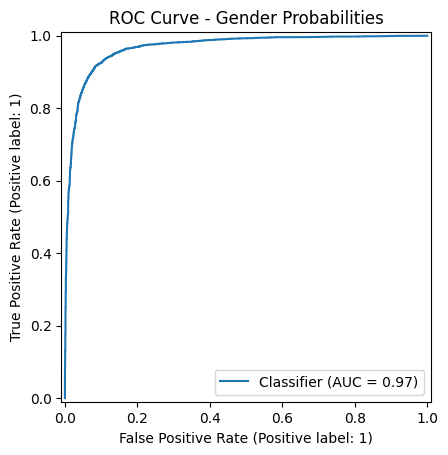

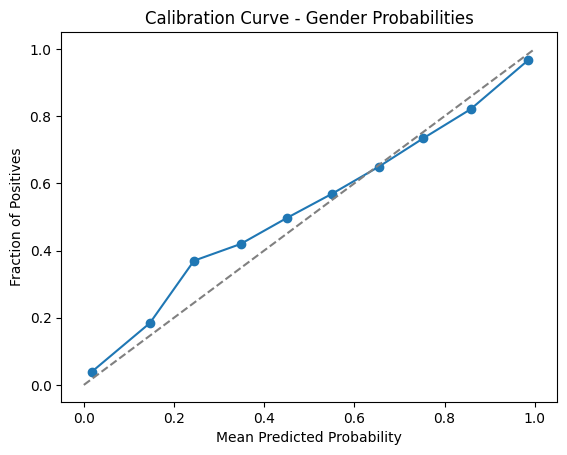


Fitting Feature Augmented MLP for Age with gender probability feature

Predicting Feature Augmented MLP for Age on training set

Predicting Feature Augmented MLP for Age on comparison set

===== Feature Augmented MLP for Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     18905
           1       0.92      0.90      0.91     18850

    accuracy                           0.91     37755
   macro avg       0.91      0.91      0.91     37755
weighted avg       0.91      0.91      0.91     37755


===== Feature Augmented MLP for Age: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      4500
           1       0.69      0.68      0.68      4500

    accuracy                           0.69      9000
   macro avg       0.69      0.69      0.69      9000
weighted avg       0.69      0.69      0.69      9

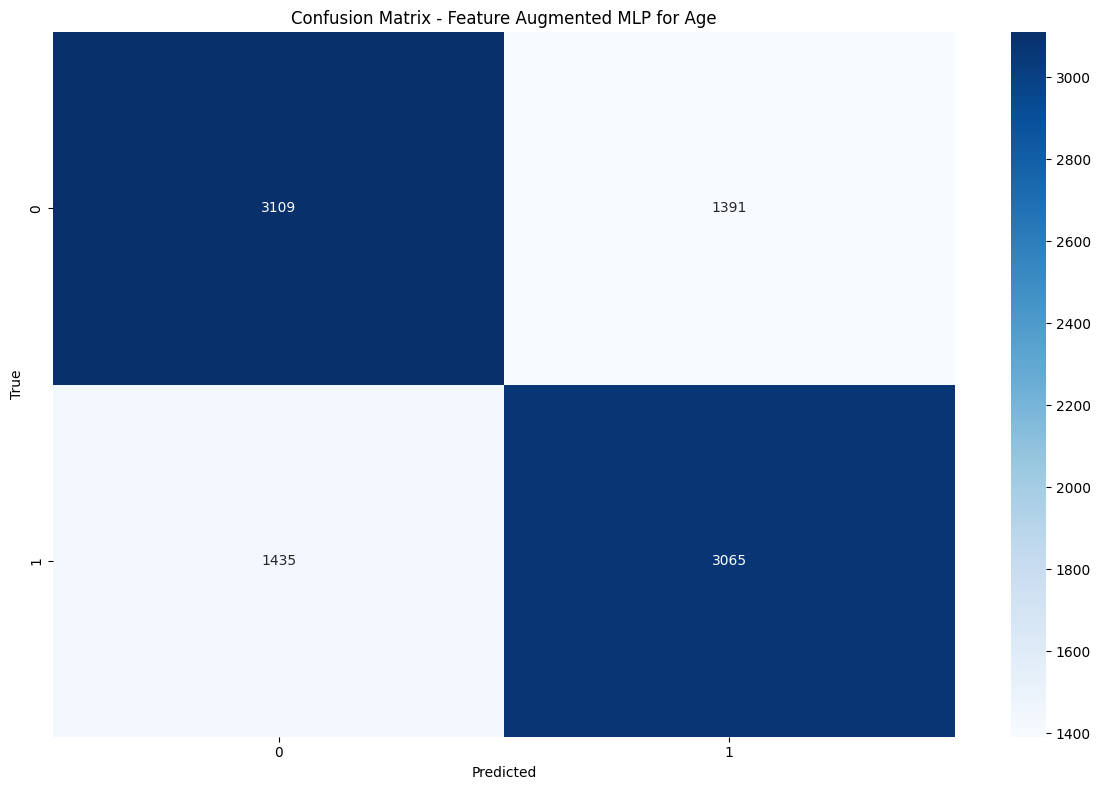

<Figure size 1200x800 with 0 Axes>

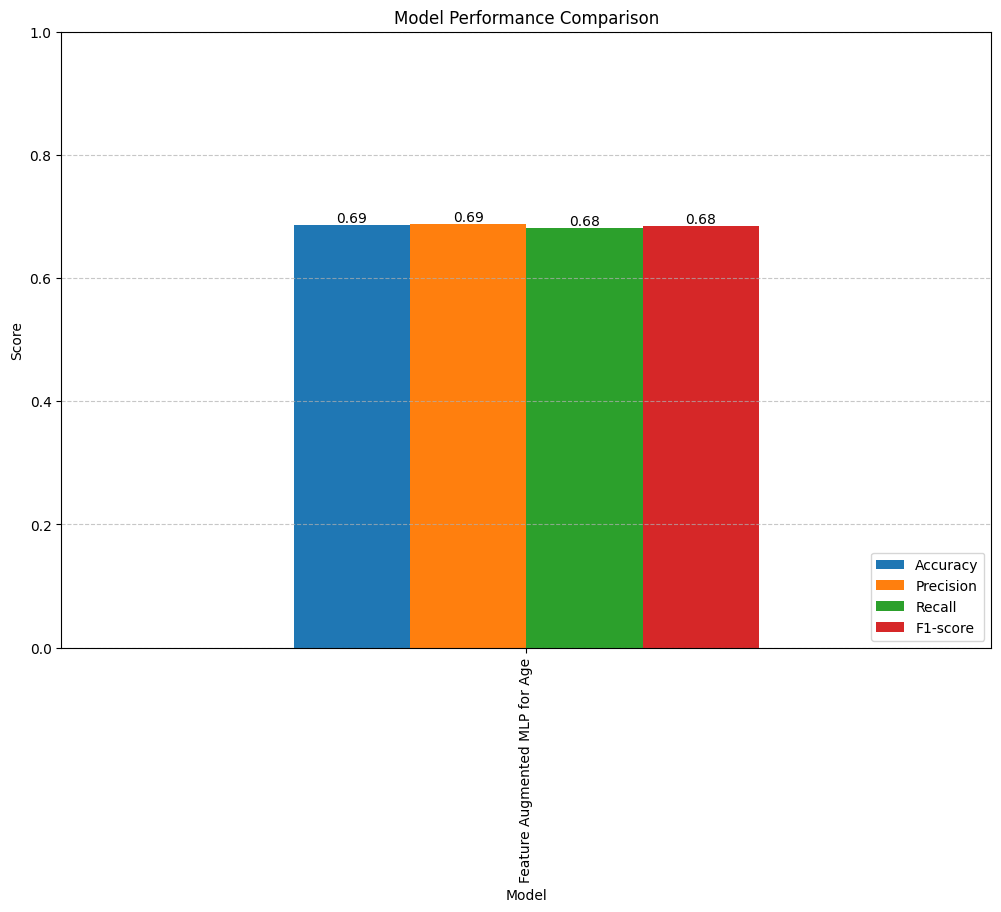

,Model,Accuracy,Precision,Recall,F1-score
0,Feature Augmented MLP for Age,0.686,0.687837,0.681111,0.684457


In [77]:
optimized_augmented_test_data=fit_predict_gender_age_pipeline_with_soft_feature(
    MLPClassifier(hidden_layer_sizes=(512, 256),
                  batch_size=64,
                  learning_rate_init=0.001,
                  max_iter=1000,
                  activation="relu",
                  random_state=27,
                  learning_rate='adaptive',
                  alpha=0.0005,
                  early_stopping=True,
                  validation_fraction=0.1),
    MLPClassifier(
        random_state=27,
        activation='relu',
        alpha=0.0001,
        batch_size=64,
        early_stopping=True,
        hidden_layer_sizes=(512, 256),
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=200,
        solver='adam',
        validation_fraction=0.1),
    "MLP for Gender Probability",
    "Feature Augmented MLP for Age",
    y_train_age=y_train_clean["age_young_old_encoded"],
    y_train_gender=y_train_clean["gender_encoded"],
    X_comp = X_test,
    y_comp_age = y_test["age_young_old_encoded"],
    y_comp_gender = y_test["gender_encoded"],
    y_comp_gender_encoded= y_test["gender_encoded"]
)
optimized_augmented_test_data

<Figure size 1200x800 with 0 Axes>

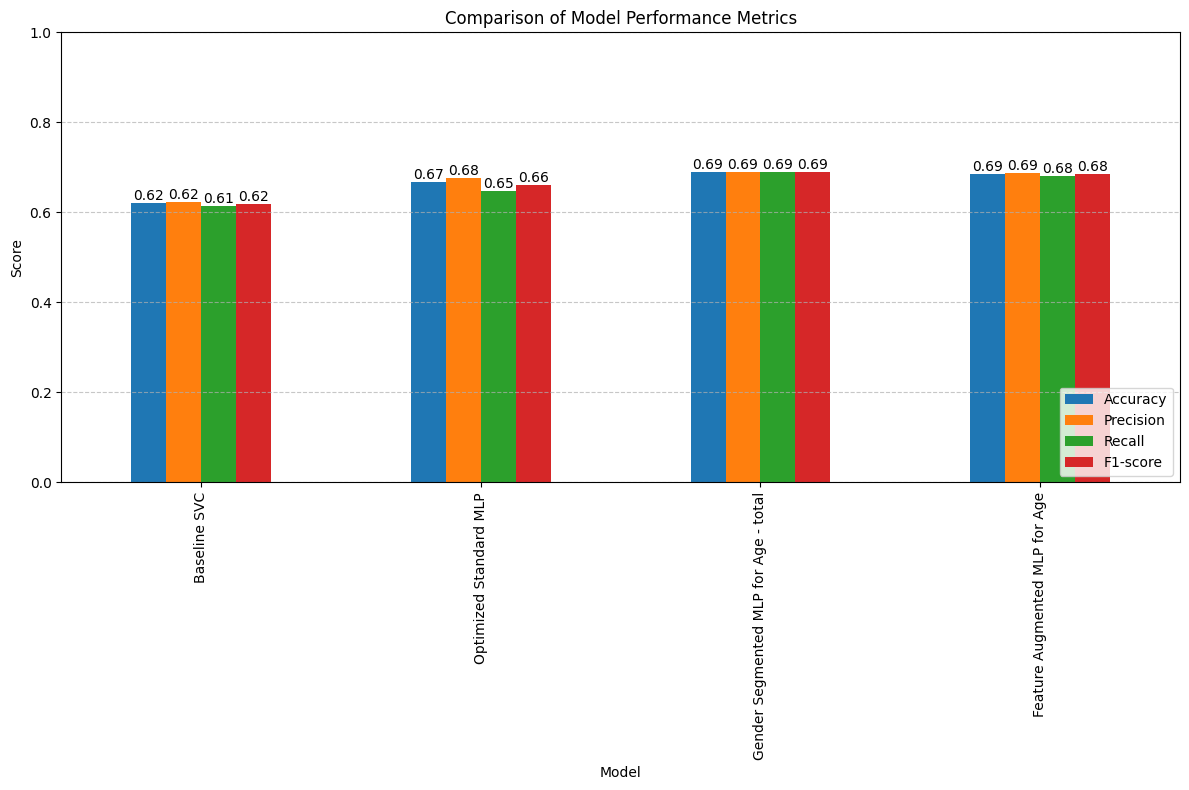

In [80]:
compare_selected_metrics(
    optimized_svc,
    optimized_MLP_test_data,
    optimized_segmented_test_data,
    optimized_augmented_test_data, fig_size=(12, 8), exclude_suffixes=('ine')
    )